# C. CPRNG-GAN (Cryptographically-strong PRNG with GAN)

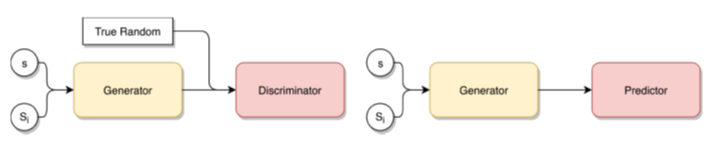

논문에서 공개한 원본 소스(https://github.com/marcellodebernardi )는 Tensorflow로 작성되어 있으며 discriminator, predictor를 각각 이용한 두 개의 GAN 모델이 존재합니다.

이 노트북에서는 predictor를 사용한 GAN 모델을 Keras로 구현했습니다. 아래 설명에서 '예측망'은 원래 GAN의 '판단망'에 대응합니다.

1. 생성망(Generator)
    - 생성망은 latent space에서 하나의 latent vector를 받아, 이에 대응하는 binary sequence를 생성합니다.
    - 생성망은 생성한 자료를 예측망에게 전달하여, 평가받습니다.
    
2. 예측망(Predictor)
    - 예측망은 binary sequence를 받아 이 자료를 이용하여 수열의 예측을 수행합니다.
        - 길이 $n$인 binary sequence의 첫 $n-1$ bits와 마지막 1 bit를 분리합니다.
        - 예측망은 $n-1$ bits를 보고, 그 다음 1 bit를 예측합니다.
        - 예측 결과가 맞았으면 예측망의 승리, 틀렸으면 생성망의 승리가 됩니다.
    - 따라서 예측망은 실제 자료(true random binary sequence)를 필요로 하지 않습니다.

3. 훈련(학습) 진행
    1. 예측망의 학습
        - 예측망은 판단망이 내놓은 binary sequence를 제대로 예측하는 방향으로 학습됩니다.
        - 따라서 이 때 loss는 **binary sequence의 실제 마지막 bit**와 **예측 bit** 사이의 absolute difference, 또는 binary crossentropy입니다.
        - **예측망은 생성망과 관계 없이 독립적으로 학습합니다.** 생성망은 예측망이 학습할 자료를 만들어주는 역할만 합니다.
    2. 예측망의 학습
        - 생성망은 우선 latent vector를 이용하여 binary sequence를 하나 생성합니다.
        - 이 binary sequence를 예측망에 통과시킨 결과, 예측이 실패했다고 가정하고 학습합니다.
        - 따라서 이 때 loss는 **binary sequence의 실제 마지막 bit의 반대값**과 **예측 bit** 사이의 absolute difference, 또는 binary crossentropy입니다.
            - 여기서 핵심은, 생성망에게 예측망이 예측한 bit와 반대되는 bit를 생성하도록 유도하는 것입니다.
        - **생성망은 예측망과 연결된 상태로 학습합니다.** 예측망은 적절한 gradient를 생성망으로 전달하는 역할을 합니다. 그러므로 생성망이 학습할 때 예측망은 학습되지 않는 고정된 상태입니다.


4. 결과 해석
    - accuracy는 별도의 함수를 이용하여 계산했습니다.
        - 단순하게 **metrics = ['accuracy']**를 이용하지 않습니다. 이유는, keras 자체의 accuracy 계산은 target과 prediction 사이의 일치비율인데 우리 모델은 target을 안 쓰기 때문입니다.
        - accuracy를 함수로 정의해서 사용하는 방법은 loss 함수 정의와 비슷하게 진행하면 됩니다.
    - accuracy는 0.5에 가까울 수록 PRNG가 안전한 것, 즉 생성망이 우수한 것이 됩니다.
        - 다만 이 해석은 공격자(예측망)가 충분히 머리가 좋아서, "동전 던져서 찍는 것보다 내가 더 잘 틀리면, 차라리 결과를 뒤집는 게 낫겠다"는 생각을 할 수 있다고 가정해야 성립합니다. (즉 2지선다 문자에서 100% 틀린다는 것은 사실 100% 맞추는 것과 같다는 통찰이 가능한 경우에만!)
        - 그러나 실제로 생성망이 충분히 큰데 비해 예측망이 너무 작으면, 예측망의 accuracy가 0에 가깝게 나오기도 합니다. 이러면 생성망은 자기가 잘 하는 줄 알지만 사실은 꽤나 엉망인 경우...
    - 어떻게 해야 accuracy가 0.5에 가깝게 되도록 할 수 있을까요?
        - 생성망과 예측망을 충분히 키워 잘 경쟁시키는 것도 방법일 것이고,
        - loss를 잘 정의할 수도 있을 겁니다. 하지만 loss를 건드려서 accuracy가 0.5에 가까워지도록 생성망을 학습시켰을 때, 그 생성망이 정말 좋은 PRNG가 될 것인지는 알 수 없습니다.
    - 어쨌거나. 예측망이 충분히 크면, accuracy가 0에서 1로, 또는 1에서 0으로 순식간에 뒤집히는 경우가 많이 발생합니다.
        - 예측망이 충분히 크면 '결과를 뒤집는 게 차라리 더 유리하다'는 걸 신경망이 배우게 된다는 것 (하지만 이게 무슨 통찰을 가지게 된 그런 건 아니고...^^;)
        - 비슷하게, 생성망도 '예측망이 다 맞추는 거 같으니 결과를 뒤집어버리자'는 식으로 반응한다는 얘기이기도 합니다.

5. 기타사항
    - 생성망과 예측망은 모두 학습자료 중 target(y)를 필요로 하지 않습니다. 따라서 코드에 등장하는 target들은 모두 dummy입니다. Keras 구조상 아예 입력하지 않는 건 힘들어서...
    - **Lambda** layer를 눈여겨 봐 둡시다. Python의 lambda 문법과 관련이 있습니다.
    - **keras.backend**는 tensor를 다루는 보조함수들을 가지고 있습니다.
    - loss 정의에 따라 학습 곡선이 매우 많이 달라지며, 학습 결과 또한 천차만별입니다. 물론, 단순히 loss 정의에 따른 차이가 아니라 GAN 자체의 학습 불안전성도 영향을 준 결과이긴 합니다.
        - loss 정의하는 함수에서 주석처리한 부분이 있습니다. 다양한 loss 정의를 남겨둔 것인데, 바꿔가며 테스트해보시기 바랍니다.
    - 왜 loss에 0.5를 곱했을까요? :)

## 1. CPRNG_GAN class 정의

위 설명을 충분히 읽어봤다면, 그리고 이전 노트북을 미리 살펴봤다면 아래 코드는 그다지 어렵지 않습니다.

In [7]:
from __future__ import print_function, division

import keras as keras
import keras.backend as K
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Lambda
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

from keras.utils import plot_model
import matplotlib.pyplot as plt

import sys

import numpy as np

def display_model_structure(model, figsize = (10, 20), saveTo = 'dummy.png'):
    plot_model(model, to_file=saveTo, show_shapes = True, show_layer_names=True)
    fig = plt.figure(figsize = figsize)
    ax = plt.axes()
    ax.axis('off')
    ax.imshow(plt.imread(saveTo))
    plt.show()
    return

class CPRNG_GAN():
    def __init__(self, latent_dim = 2, gen_width = 10,
                 generator = [300, 300, 300],
                 predictor = [100],
                 optimizer = Adam(0.0002, 0.5)):
        self.latent_dim = latent_dim
        self.input_shape = (latent_dim,)
        self.output_shape = (gen_width, )
        self.optimizer = optimizer
        self.generator_param = generator
        self.predictor_param = predictor

        # Build and compile the predictor
        self.predictor = self.build_predictor()

        # Build the generator
        self.generator = self.build_generator()
        
        # Build the combined model(to train the generator)
        self.combined  = self.build_combined()
        return

    def build_generator(self):

        model = Sequential()
        model.add(Dense(self.generator_param[0], input_dim = self.latent_dim, name = 'g_dense_1'))
        model.add(LeakyReLU(alpha=0.2, name = 'g_leakyReLU_1'))
        for i, num_units in enumerate(self.generator_param[1:]):
            model.add(Dense(num_units, name = 'g_dense_{}'.format(i + 2)))
            model.add(LeakyReLU(alpha = 0.2, name = 'g_leakyReLU_{}'.format(i + 2)))

        model.add(Dense(np.prod(self.output_shape), activation = 'sigmoid', name = 'g_dense_{}'.format(len(self.generator_param) + 1)))
        model.add(Reshape(self.output_shape, name = 'g_reshape_output'))
        model.summary(100)
        display_model_structure(model, saveTo = 'cprng_generator.png')
        
        z = Input(shape=(self.latent_dim,), name = 'latent_input')
        sequence = model(z)
        m = Model(z, sequence, name = 'generator')
        return m

    def build_predictor(self):

        sequence = Input(shape=self.output_shape, name = 'sequence_input')
        split = Lambda(lambda x: K.tf.split(x, [self.output_shape[0] - 1, 1], 1), name = 'splitter')(sequence)
        dense = split[0]
        for i, num_units in enumerate(self.predictor_param):
            dense = Dense(num_units, name = 'dense_{}'.format(i + 1))(dense)
            dense = LeakyReLU(alpha = 0.2, name = 'leakyReLU_{}'.format(i + 1))(dense)
        predicted = Dense(1, activation = 'sigmoid', name = 'predicted')(dense)

        m = Model(sequence, [predicted, split[1]], name = 'predictor')
        def loss(y_true, y_pred):
            l = K.mean(K.abs(predicted - split[1]), axis = -1) * 0.5
            #l = K.mean(K.binary_crossentropy(predicted, split[1]), axis = -1) * 0.5
            return l
        
        def accuracy(y_true, y_pred):
            acc = K.mean(K.equal(K.round(predicted), K.round(split[1])), axis = -1)
            return acc
        
        m.compile(optimizer = self.optimizer, loss = loss, metrics = [accuracy])
        m.summary(100)
        display_model_structure(m, saveTo = 'cprng_predictor.png')
        
        return m

    def build_combined(self):
        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,), name = 'latent_input')
        sequence = self.generator(z)

        # For the combined model we will only train the generator
        self.predictor.trainable = False

        # The discriminator takes generated sequence as input and determines predicted
        predicted = self.predictor(sequence)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        m = Model(z, predicted, name = 'combined')
        m.summary(100)
        display_model_structure(m, saveTo = 'cprng_combined.png')
        def loss(y_true, y_pred):
            #l = K.mean(1 - K.abs(predicted[0] - predicted[1]), axis = -1) * 0.5
            l = K.mean(K.abs(1 - predicted[0] - predicted[1]), axis = -1) * 0.5
            #l = K.mean(K.binary_crossentropy(1 - predicted[0], predicted[1]), axis = -1) * 0.5
            return l
            
        m.compile(loss=loss, optimizer=self.optimizer)
        return m
    
    def train(self, epochs, batch_size=128, adv_multiplier = 3, sample_interval=50, verbose = 1):
        self.history = dict.fromkeys(['g_loss', 'p_loss', 'acc', 'adv'])
        self.history['g_loss'] = []
        self.history['p_loss'] = []
        self.history['acc'] = []
        self.history['adv'] = []
        dummy_target = np.zeros((batch_size, 1))
        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            for _ in range(adv_multiplier):
                #noise = np.random.random(0, 1, (batch_size, self.latent_dim))
                noise = np.random.rand(batch_size, self.latent_dim)

                # Generate a batch of new sequences
                gen_seqs = self.generator.predict(noise)

                # Train the predictor
                p_loss = self.predictor.train_on_batch(gen_seqs, [dummy_target, dummy_target])

            # ---------------------
            #  Train Generator
            # ---------------------

            #noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            noise = np.random.rand(batch_size, self.latent_dim)

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, [dummy_target, dummy_target])

            # Plot the progress
            print ("%d [P loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, p_loss[0], 100*p_loss[3], g_loss[0]))
            self.history['g_loss'].append(g_loss[0])
            self.history['p_loss'].append(p_loss[0])
            self.history['acc'].append(p_loss[3])
            self.history['adv'].append(abs(p_loss[3] - 0.5))

            # If at save interval => save generated image samples
            if verbose == 1 and epoch % sample_interval == 0:
                self.sample_sequences(epoch)

    def sample_sequences(self, epoch, num_samples = 10):
        noise = np.random.normal(0, 1, (num_samples, self.latent_dim))
        gen_seqs = self.generator.predict(noise)
        gen_seqs = np.array(gen_seqs > 0.5, dtype = int)

        for i in range(num_samples):
            print(gen_seqs[i])

        return

    def show_curves(self):
        fig = plt.figure(figsize = (16, 12))
        ax = fig.subplots(2, 1)
        ax[0].plot(self.history['g_loss'])
        ax[0].plot(self.history['p_loss'])
        ax[0].set_title('Losses')
        ax[0].legend(['Generator', 'Predictor'])
        ax[1].plot(self.history['acc'])
        ax[1].plot(self.history['adv'])
        ax[1].set_title('Predictions')
        ax[1].legend(['Accuracy', 'Advantage'])
        plt.show()
        return

## 2. Bernardi et al. 논문에서 사용된 CPRNG 구현

논문에서 사용된 predictor는 CNN 구조이지만, 여기서는 단순한 DNN을 사용해서 만들었습니다. 대신에 unit의 개수를 조절해서 원래 CNN과 비슷한 느낌이 되도록 맞추었습니다.

아울러 논문에서는 생성 단위가 16비트로, 실제 생성 및 평가되는 단위는 0~65535 사이의 정수입니다. 이것은 효율 및 predictor가 얻는 추가 이득을 줄이기 위한 것으로 보이는데 여기서는 1비트 단위로 갑니다.

____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
sequence_input (InputLayer)                  (None, 112)                             0              
____________________________________________________________________________________________________
splitter (Lambda)                            [(None, 111), (None, 1)]                0              
____________________________________________________________________________________________________
dense_1 (Dense)                              (None, 30)                              3360           
____________________________________________________________________________________________________
leakyReLU_1 (LeakyReLU)                      (None, 30)                              0              
___________________________________________________________________________________________

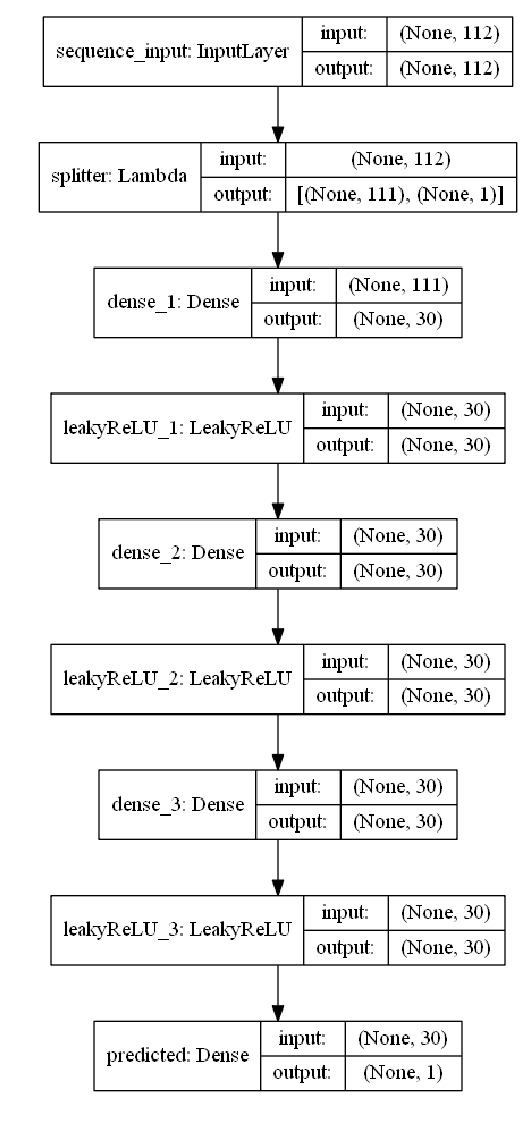

____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
g_dense_1 (Dense)                            (None, 30)                              990            
____________________________________________________________________________________________________
g_leakyReLU_1 (LeakyReLU)                    (None, 30)                              0              
____________________________________________________________________________________________________
g_dense_2 (Dense)                            (None, 30)                              930            
____________________________________________________________________________________________________
g_leakyReLU_2 (LeakyReLU)                    (None, 30)                              0              
___________________________________________________________________________________________

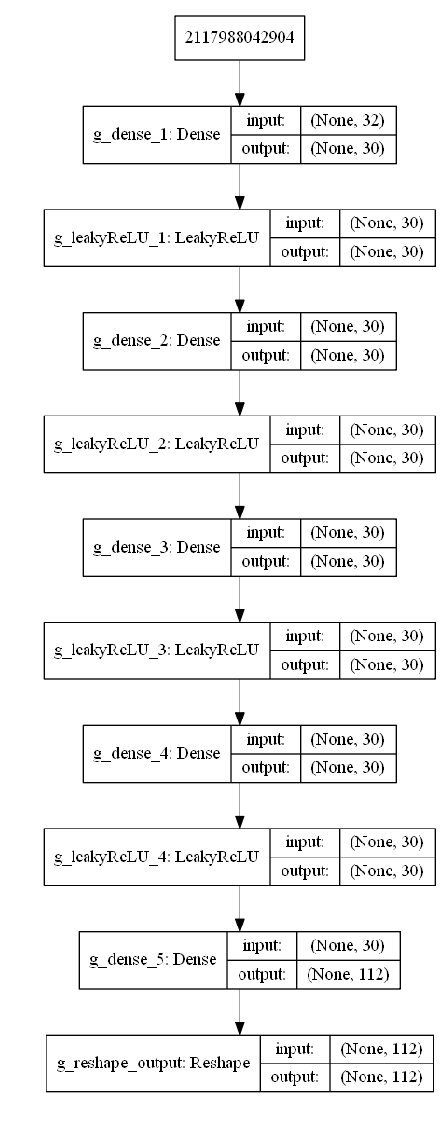

____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
latent_input (InputLayer)                    (None, 32)                              0              
____________________________________________________________________________________________________
generator (Model)                            (None, 112)                             7252           
____________________________________________________________________________________________________
predictor (Model)                            [(None, 1), (None, 1)]                  5251           
Total params: 12,503
Trainable params: 7,252
Non-trainable params: 5,251
____________________________________________________________________________________________________


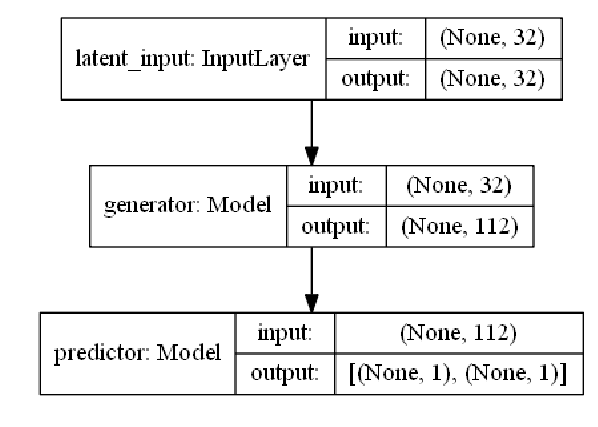

D:\Anaconda3\envs\keras\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [P loss: 0.105154, acc.: 41.09%] [G loss: 0.092091]
[1 0 0 1 1 0 0 0 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 0 0
 0 0 1 0 0 1 1 0 1 1 1 0 0 0 1 1 1 0 0 0 1 1 0 0 0 0 0 1 0 1 1 0 0 1 0 1 1
 1 1 0 1 0 1 0 1 1 1 1 0 0 1 0 1 0 1 1 0 1 1 1 0 0 0 0 1 0 1 0 1 1 1 0 1 0
 0]
[1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1 1 0 0 0 0 0 1 1 1 0 1 1 0 0
 1 0 1 1 1 0 1 1 0 0 1 0 0 0 1 1 1 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0 0 1 1 0 1
 1 1 0 1 1 1 0 1 1 1 1 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 0 0
 1]
[1 0 0 1 1 0 0 0 1 1 0 0 0 0 1 1 0 0 1 1 0 1 1 1 1 1 0 1 0 1 0 1 0 1 1 0 0
 0 0 1 0 0 1 1 0 1 0 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 1 1 0 0 1 0 0 0 1 0 1
 1 1 0 0 1 1 0 1 0 1 0 0 0 1 1 0 0 1 0 0 1 0 1 0 0 0 0 1 1 1 1 0 1 0 1 0 0
 0]
[1 0 0 1 1 0 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0 0 0
 0 1 1 0 0 1 0 0 0 1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 1 1 0 1 1 0 0 0 1 0 1
 1 1 0 1 1 1 0 1 0 1 1 0 0 0 1 1 0 1 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 1 0 1 0
 1]
[1 0 0 1 1 0 0 0 1 1 0 0 0 0 1

108 [P loss: 0.001501, acc.: 29.92%] [G loss: 0.001998]
109 [P loss: 0.001374, acc.: 44.53%] [G loss: 0.001129]
110 [P loss: 0.001424, acc.: 41.56%] [G loss: 0.001389]
111 [P loss: 0.001433, acc.: 31.72%] [G loss: 0.001717]
112 [P loss: 0.001613, acc.: 46.95%] [G loss: 0.001311]
113 [P loss: 0.001355, acc.: 32.42%] [G loss: 0.001355]
114 [P loss: 0.001620, acc.: 40.70%] [G loss: 0.001553]
115 [P loss: 0.001306, acc.: 32.11%] [G loss: 0.001142]
116 [P loss: 0.001230, acc.: 34.61%] [G loss: 0.000921]
117 [P loss: 0.001545, acc.: 40.16%] [G loss: 0.001740]
118 [P loss: 0.001286, acc.: 32.19%] [G loss: 0.001317]
119 [P loss: 0.001482, acc.: 50.63%] [G loss: 0.001115]
120 [P loss: 0.001340, acc.: 29.45%] [G loss: 0.001549]
121 [P loss: 0.001556, acc.: 41.02%] [G loss: 0.001404]
122 [P loss: 0.001344, acc.: 36.95%] [G loss: 0.001309]
123 [P loss: 0.001306, acc.: 33.52%] [G loss: 0.001295]
124 [P loss: 0.001266, acc.: 44.77%] [G loss: 0.001070]
125 [P loss: 0.001355, acc.: 39.38%] [G loss: 0.

214 [P loss: 0.001039, acc.: 35.55%] [G loss: 0.001100]
215 [P loss: 0.001226, acc.: 37.66%] [G loss: 0.001150]
216 [P loss: 0.001068, acc.: 38.28%] [G loss: 0.000997]
217 [P loss: 0.001136, acc.: 34.92%] [G loss: 0.001128]
218 [P loss: 0.001055, acc.: 39.14%] [G loss: 0.001026]
219 [P loss: 0.001100, acc.: 37.89%] [G loss: 0.000991]
220 [P loss: 0.001000, acc.: 37.11%] [G loss: 0.000889]
221 [P loss: 0.001110, acc.: 41.25%] [G loss: 0.001279]
222 [P loss: 0.000974, acc.: 32.11%] [G loss: 0.000799]
223 [P loss: 0.000895, acc.: 45.78%] [G loss: 0.000780]
224 [P loss: 0.001359, acc.: 39.69%] [G loss: 0.001157]
225 [P loss: 0.001136, acc.: 42.27%] [G loss: 0.001199]
226 [P loss: 0.001092, acc.: 31.87%] [G loss: 0.001266]
227 [P loss: 0.001027, acc.: 43.36%] [G loss: 0.000928]
228 [P loss: 0.001037, acc.: 37.19%] [G loss: 0.001077]
229 [P loss: 0.001045, acc.: 33.75%] [G loss: 0.001102]
230 [P loss: 0.001113, acc.: 40.86%] [G loss: 0.001104]
231 [P loss: 0.001003, acc.: 31.95%] [G loss: 0.

362 [P loss: 0.000917, acc.: 47.27%] [G loss: 0.000737]
363 [P loss: 0.000874, acc.: 34.53%] [G loss: 0.001201]
364 [P loss: 0.000828, acc.: 38.12%] [G loss: 0.000812]
365 [P loss: 0.000951, acc.: 44.77%] [G loss: 0.000873]
366 [P loss: 0.000944, acc.: 31.17%] [G loss: 0.001161]
367 [P loss: 0.000849, acc.: 43.67%] [G loss: 0.000657]
368 [P loss: 0.000914, acc.: 40.86%] [G loss: 0.000841]
369 [P loss: 0.000812, acc.: 32.42%] [G loss: 0.001080]
370 [P loss: 0.000857, acc.: 42.19%] [G loss: 0.000821]
371 [P loss: 0.000773, acc.: 32.27%] [G loss: 0.000905]
372 [P loss: 0.000956, acc.: 41.09%] [G loss: 0.000732]
373 [P loss: 0.000829, acc.: 39.92%] [G loss: 0.000845]
374 [P loss: 0.000935, acc.: 28.83%] [G loss: 0.001089]
375 [P loss: 0.000844, acc.: 44.53%] [G loss: 0.000707]
376 [P loss: 0.000923, acc.: 39.69%] [G loss: 0.000982]
377 [P loss: 0.000814, acc.: 29.53%] [G loss: 0.001002]
378 [P loss: 0.000897, acc.: 43.44%] [G loss: 0.000681]
379 [P loss: 0.000793, acc.: 36.09%] [G loss: 0.

468 [P loss: 0.000789, acc.: 33.75%] [G loss: 0.000726]
469 [P loss: 0.000726, acc.: 41.33%] [G loss: 0.000677]
470 [P loss: 0.000761, acc.: 40.23%] [G loss: 0.000689]
471 [P loss: 0.000821, acc.: 36.02%] [G loss: 0.000743]
472 [P loss: 0.000890, acc.: 39.61%] [G loss: 0.000823]
473 [P loss: 0.000725, acc.: 33.13%] [G loss: 0.000904]
474 [P loss: 0.000800, acc.: 38.05%] [G loss: 0.000735]
475 [P loss: 0.000731, acc.: 38.83%] [G loss: 0.000687]
476 [P loss: 0.000789, acc.: 34.77%] [G loss: 0.000756]
477 [P loss: 0.000875, acc.: 37.66%] [G loss: 0.000836]
478 [P loss: 0.000769, acc.: 35.39%] [G loss: 0.000772]
479 [P loss: 0.000795, acc.: 38.83%] [G loss: 0.000813]
480 [P loss: 0.000751, acc.: 33.52%] [G loss: 0.000938]
481 [P loss: 0.000686, acc.: 33.83%] [G loss: 0.000564]
482 [P loss: 0.000732, acc.: 45.55%] [G loss: 0.000594]
483 [P loss: 0.000753, acc.: 28.83%] [G loss: 0.000838]
484 [P loss: 0.000774, acc.: 44.92%] [G loss: 0.000766]
485 [P loss: 0.000659, acc.: 30.78%] [G loss: 0.

602 [P loss: 0.000555, acc.: 33.67%] [G loss: 0.000617]
603 [P loss: 0.000744, acc.: 53.05%] [G loss: 0.000584]
604 [P loss: 0.000633, acc.: 27.34%] [G loss: 0.000837]
605 [P loss: 0.000725, acc.: 46.95%] [G loss: 0.000614]
606 [P loss: 0.000653, acc.: 27.11%] [G loss: 0.000857]
607 [P loss: 0.000633, acc.: 35.70%] [G loss: 0.000732]
608 [P loss: 0.000695, acc.: 41.72%] [G loss: 0.000682]
609 [P loss: 0.000631, acc.: 31.41%] [G loss: 0.000704]
610 [P loss: 0.000699, acc.: 40.78%] [G loss: 0.000671]
611 [P loss: 0.000618, acc.: 31.64%] [G loss: 0.000651]
612 [P loss: 0.000777, acc.: 44.30%] [G loss: 0.000652]
613 [P loss: 0.000660, acc.: 30.94%] [G loss: 0.000883]
614 [P loss: 0.000691, acc.: 41.09%] [G loss: 0.000531]
615 [P loss: 0.000669, acc.: 43.98%] [G loss: 0.000686]
616 [P loss: 0.000591, acc.: 29.06%] [G loss: 0.000754]
617 [P loss: 0.000749, acc.: 49.30%] [G loss: 0.000577]
618 [P loss: 0.000608, acc.: 27.50%] [G loss: 0.000885]
619 [P loss: 0.000641, acc.: 37.50%] [G loss: 0.

750 [P loss: 0.000580, acc.: 36.25%] [G loss: 0.000585]
751 [P loss: 0.000561, acc.: 36.48%] [G loss: 0.000584]
752 [P loss: 0.000611, acc.: 38.20%] [G loss: 0.000690]
753 [P loss: 0.000479, acc.: 37.73%] [G loss: 0.000465]
754 [P loss: 0.000574, acc.: 48.44%] [G loss: 0.000575]
755 [P loss: 0.000487, acc.: 36.25%] [G loss: 0.000553]
756 [P loss: 0.000580, acc.: 52.50%] [G loss: 0.000421]
757 [P loss: 0.000621, acc.: 31.17%] [G loss: 0.000842]
758 [P loss: 0.000544, acc.: 34.38%] [G loss: 0.000647]
759 [P loss: 0.000572, acc.: 44.69%] [G loss: 0.000502]
760 [P loss: 0.000608, acc.: 36.17%] [G loss: 0.000676]
761 [P loss: 0.000536, acc.: 38.36%] [G loss: 0.000568]
762 [P loss: 0.000630, acc.: 42.19%] [G loss: 0.000602]
763 [P loss: 0.000525, acc.: 32.50%] [G loss: 0.000656]
764 [P loss: 0.000612, acc.: 42.27%] [G loss: 0.000516]
765 [P loss: 0.000553, acc.: 37.97%] [G loss: 0.000544]
766 [P loss: 0.000549, acc.: 35.39%] [G loss: 0.000612]
767 [P loss: 0.000606, acc.: 39.14%] [G loss: 0.

856 [P loss: 0.000527, acc.: 30.39%] [G loss: 0.000587]
857 [P loss: 0.000554, acc.: 41.72%] [G loss: 0.000503]
858 [P loss: 0.000557, acc.: 32.50%] [G loss: 0.000696]
859 [P loss: 0.000492, acc.: 36.09%] [G loss: 0.000497]
860 [P loss: 0.000571, acc.: 42.03%] [G loss: 0.000535]
861 [P loss: 0.000508, acc.: 31.95%] [G loss: 0.000512]
862 [P loss: 0.000476, acc.: 42.66%] [G loss: 0.000550]
863 [P loss: 0.000497, acc.: 30.23%] [G loss: 0.000663]
864 [P loss: 0.000523, acc.: 44.14%] [G loss: 0.000440]
865 [P loss: 0.000551, acc.: 39.30%] [G loss: 0.000561]
866 [P loss: 0.000523, acc.: 29.53%] [G loss: 0.000664]
867 [P loss: 0.000562, acc.: 43.28%] [G loss: 0.000553]
868 [P loss: 0.000501, acc.: 32.11%] [G loss: 0.000605]
869 [P loss: 0.000519, acc.: 36.80%] [G loss: 0.000516]
870 [P loss: 0.000543, acc.: 36.33%] [G loss: 0.000560]
871 [P loss: 0.000520, acc.: 36.02%] [G loss: 0.000528]
872 [P loss: 0.000567, acc.: 37.73%] [G loss: 0.000576]
873 [P loss: 0.000523, acc.: 33.98%] [G loss: 0.

1002 [P loss: 0.000435, acc.: 30.55%] [G loss: 0.000526]
1003 [P loss: 0.000493, acc.: 38.98%] [G loss: 0.000547]
1004 [P loss: 0.000435, acc.: 26.72%] [G loss: 0.000623]
1005 [P loss: 0.000464, acc.: 42.81%] [G loss: 0.000404]
1006 [P loss: 0.000452, acc.: 36.88%] [G loss: 0.000522]
1007 [P loss: 0.000442, acc.: 32.27%] [G loss: 0.000475]
1008 [P loss: 0.000488, acc.: 49.30%] [G loss: 0.000450]
1009 [P loss: 0.000396, acc.: 32.42%] [G loss: 0.000531]
1010 [P loss: 0.000559, acc.: 45.16%] [G loss: 0.000441]
1011 [P loss: 0.000458, acc.: 28.67%] [G loss: 0.000649]
1012 [P loss: 0.000454, acc.: 31.80%] [G loss: 0.000581]
1013 [P loss: 0.000433, acc.: 37.66%] [G loss: 0.000429]
1014 [P loss: 0.000528, acc.: 41.48%] [G loss: 0.000483]
1015 [P loss: 0.000481, acc.: 38.20%] [G loss: 0.000555]
1016 [P loss: 0.000485, acc.: 36.02%] [G loss: 0.000548]
1017 [P loss: 0.000454, acc.: 38.59%] [G loss: 0.000527]
1018 [P loss: 0.000455, acc.: 31.80%] [G loss: 0.000538]
1019 [P loss: 0.000462, acc.: 4

1146 [P loss: 0.000459, acc.: 40.00%] [G loss: 0.000408]
1147 [P loss: 0.000424, acc.: 35.47%] [G loss: 0.000506]
1148 [P loss: 0.000444, acc.: 37.50%] [G loss: 0.000496]
1149 [P loss: 0.000391, acc.: 38.05%] [G loss: 0.000442]
1150 [P loss: 0.000459, acc.: 38.28%] [G loss: 0.000509]
1151 [P loss: 0.000394, acc.: 34.61%] [G loss: 0.000537]
1152 [P loss: 0.000452, acc.: 36.56%] [G loss: 0.000471]
1153 [P loss: 0.000403, acc.: 38.52%] [G loss: 0.000529]
1154 [P loss: 0.000442, acc.: 31.41%] [G loss: 0.000553]
1155 [P loss: 0.000401, acc.: 38.28%] [G loss: 0.000388]
1156 [P loss: 0.000497, acc.: 39.61%] [G loss: 0.000499]
1157 [P loss: 0.000345, acc.: 38.83%] [G loss: 0.000478]
1158 [P loss: 0.000465, acc.: 46.33%] [G loss: 0.000399]
1159 [P loss: 0.000404, acc.: 29.22%] [G loss: 0.000562]
1160 [P loss: 0.000393, acc.: 36.41%] [G loss: 0.000341]
1161 [P loss: 0.000481, acc.: 43.36%] [G loss: 0.000431]
1162 [P loss: 0.000405, acc.: 27.27%] [G loss: 0.000590]
1163 [P loss: 0.000399, acc.: 4

1250 [P loss: 0.000387, acc.: 30.23%] [G loss: 0.000524]
1251 [P loss: 0.000362, acc.: 39.77%] [G loss: 0.000362]
1252 [P loss: 0.000456, acc.: 41.41%] [G loss: 0.000450]
1253 [P loss: 0.000333, acc.: 33.67%] [G loss: 0.000497]
1254 [P loss: 0.000375, acc.: 43.83%] [G loss: 0.000319]
1255 [P loss: 0.000393, acc.: 40.47%] [G loss: 0.000454]
1256 [P loss: 0.000361, acc.: 29.30%] [G loss: 0.000539]
1257 [P loss: 0.000376, acc.: 50.70%] [G loss: 0.000290]
1258 [P loss: 0.000433, acc.: 36.09%] [G loss: 0.000528]
1259 [P loss: 0.000323, acc.: 38.20%] [G loss: 0.000427]
1260 [P loss: 0.000432, acc.: 50.47%] [G loss: 0.000339]
1261 [P loss: 0.000376, acc.: 30.39%] [G loss: 0.000552]
1262 [P loss: 0.000420, acc.: 41.41%] [G loss: 0.000369]
1263 [P loss: 0.000353, acc.: 36.88%] [G loss: 0.000457]
1264 [P loss: 0.000381, acc.: 28.52%] [G loss: 0.000471]
1265 [P loss: 0.000385, acc.: 42.34%] [G loss: 0.000377]
1266 [P loss: 0.000411, acc.: 32.73%] [G loss: 0.000480]
1267 [P loss: 0.000348, acc.: 3

1394 [P loss: 0.000325, acc.: 33.20%] [G loss: 0.000424]
1395 [P loss: 0.000331, acc.: 37.58%] [G loss: 0.000355]
1396 [P loss: 0.000408, acc.: 35.23%] [G loss: 0.000427]
1397 [P loss: 0.000337, acc.: 30.63%] [G loss: 0.000484]
1398 [P loss: 0.000342, acc.: 31.25%] [G loss: 0.000392]
1399 [P loss: 0.000336, acc.: 36.80%] [G loss: 0.000401]
1400 [P loss: 0.000353, acc.: 32.34%] [G loss: 0.000504]
[1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 0 1 0 0 1 1 0
 0 0 1 0 0 1 1 0 0 1 1 0 0 0 1 1 1 1 0 0 1 1 0 0 1 0 1 1 1 0 1 0 0 0 1 0 1
 1 1 0 0 1 1 0 0 0 1 0 1 0 1 1 0 0 1 0 1 1 0 1 0 1 1 0 1 1 0 0 0 0 1 0 0 0
 1]
[1 0 0 1 1 0 0 0 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 0 0 0
 0 0 1 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 1 0 1 1 0 1 0 0 0 1
 1 1 0 1 1 1 0 1 0 1 0 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 1 1 0 1 0 0 1 1 1 1 0
 0]
[1 0 1 1 1 0 1 0 1 1 0 0 0 0 0 1 1 0 1 1 1 1 1 0 1 0 1 0 0 1 1 1 0 0 1 1 0
 1 0 1 0 1 1 1 0 0 1 1 0 0 0 1 1 1 1 0 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0

1498 [P loss: 0.000302, acc.: 28.59%] [G loss: 0.000407]
1499 [P loss: 0.000353, acc.: 38.28%] [G loss: 0.000387]
1500 [P loss: 0.000305, acc.: 27.73%] [G loss: 0.000456]
1501 [P loss: 0.000284, acc.: 37.50%] [G loss: 0.000317]
1502 [P loss: 0.000384, acc.: 40.23%] [G loss: 0.000407]
1503 [P loss: 0.000278, acc.: 39.92%] [G loss: 0.000479]
1504 [P loss: 0.000346, acc.: 43.91%] [G loss: 0.000318]
1505 [P loss: 0.000298, acc.: 33.52%] [G loss: 0.000447]
1506 [P loss: 0.000308, acc.: 32.27%] [G loss: 0.000376]
1507 [P loss: 0.000291, acc.: 38.05%] [G loss: 0.000371]
1508 [P loss: 0.000310, acc.: 30.47%] [G loss: 0.000387]
1509 [P loss: 0.000343, acc.: 38.59%] [G loss: 0.000405]
1510 [P loss: 0.000330, acc.: 30.16%] [G loss: 0.000465]
1511 [P loss: 0.000285, acc.: 40.94%] [G loss: 0.000318]
1512 [P loss: 0.000328, acc.: 34.53%] [G loss: 0.000406]
1513 [P loss: 0.000276, acc.: 34.45%] [G loss: 0.000388]
1514 [P loss: 0.000325, acc.: 40.23%] [G loss: 0.000343]
1515 [P loss: 0.000307, acc.: 3

1602 [P loss: 0.000256, acc.: 38.52%] [G loss: 0.000389]
1603 [P loss: 0.000294, acc.: 41.95%] [G loss: 0.000272]
1604 [P loss: 0.000302, acc.: 32.27%] [G loss: 0.000404]
1605 [P loss: 0.000293, acc.: 30.00%] [G loss: 0.000377]
1606 [P loss: 0.000315, acc.: 42.27%] [G loss: 0.000331]
1607 [P loss: 0.000322, acc.: 26.56%] [G loss: 0.000480]
1608 [P loss: 0.000281, acc.: 38.98%] [G loss: 0.000302]
1609 [P loss: 0.000320, acc.: 38.44%] [G loss: 0.000351]
1610 [P loss: 0.000279, acc.: 31.56%] [G loss: 0.000445]
1611 [P loss: 0.000303, acc.: 36.56%] [G loss: 0.000342]
1612 [P loss: 0.000307, acc.: 33.20%] [G loss: 0.000416]
1613 [P loss: 0.000269, acc.: 30.16%] [G loss: 0.000394]
1614 [P loss: 0.000258, acc.: 36.72%] [G loss: 0.000302]
1615 [P loss: 0.000341, acc.: 33.44%] [G loss: 0.000425]
1616 [P loss: 0.000259, acc.: 36.02%] [G loss: 0.000336]
1617 [P loss: 0.000378, acc.: 43.05%] [G loss: 0.000302]
1618 [P loss: 0.000270, acc.: 30.39%] [G loss: 0.000426]
1619 [P loss: 0.000285, acc.: 3

1746 [P loss: 0.000283, acc.: 31.33%] [G loss: 0.000390]
1747 [P loss: 0.000278, acc.: 29.22%] [G loss: 0.000400]
1748 [P loss: 0.000237, acc.: 34.77%] [G loss: 0.000303]
1749 [P loss: 0.000267, acc.: 35.00%] [G loss: 0.000310]
1750 [P loss: 0.000259, acc.: 31.02%] [G loss: 0.000353]
1751 [P loss: 0.000267, acc.: 29.69%] [G loss: 0.000353]
1752 [P loss: 0.000245, acc.: 32.42%] [G loss: 0.000357]
1753 [P loss: 0.000260, acc.: 34.77%] [G loss: 0.000298]
1754 [P loss: 0.000255, acc.: 32.97%] [G loss: 0.000369]
1755 [P loss: 0.000252, acc.: 28.91%] [G loss: 0.000392]
1756 [P loss: 0.000233, acc.: 38.20%] [G loss: 0.000252]
1757 [P loss: 0.000311, acc.: 35.94%] [G loss: 0.000386]
1758 [P loss: 0.000221, acc.: 50.16%] [G loss: 0.000416]
1759 [P loss: 0.000277, acc.: 39.45%] [G loss: 0.000240]
1760 [P loss: 0.000279, acc.: 35.62%] [G loss: 0.000384]
1761 [P loss: 0.000272, acc.: 24.84%] [G loss: 0.000500]
1762 [P loss: 0.000213, acc.: 38.75%] [G loss: 0.000207]
1763 [P loss: 0.000358, acc.: 4

1850 [P loss: 0.000255, acc.: 39.53%] [G loss: 0.000324]
1851 [P loss: 0.000236, acc.: 27.58%] [G loss: 0.000429]
1852 [P loss: 0.000232, acc.: 37.11%] [G loss: 0.000292]
1853 [P loss: 0.000234, acc.: 32.03%] [G loss: 0.000273]
1854 [P loss: 0.000257, acc.: 35.31%] [G loss: 0.000344]
1855 [P loss: 0.000246, acc.: 31.41%] [G loss: 0.000378]
1856 [P loss: 0.000238, acc.: 31.33%] [G loss: 0.000330]
1857 [P loss: 0.000235, acc.: 32.42%] [G loss: 0.000318]
1858 [P loss: 0.000240, acc.: 32.34%] [G loss: 0.000345]
1859 [P loss: 0.000243, acc.: 30.63%] [G loss: 0.000326]
1860 [P loss: 0.000233, acc.: 33.05%] [G loss: 0.000283]
1861 [P loss: 0.000245, acc.: 33.13%] [G loss: 0.000310]
1862 [P loss: 0.000264, acc.: 31.87%] [G loss: 0.000370]
1863 [P loss: 0.000220, acc.: 31.80%] [G loss: 0.000315]
1864 [P loss: 0.000221, acc.: 36.64%] [G loss: 0.000267]
1865 [P loss: 0.000270, acc.: 29.69%] [G loss: 0.000361]
1866 [P loss: 0.000218, acc.: 32.73%] [G loss: 0.000297]
1867 [P loss: 0.000281, acc.: 3

1994 [P loss: 0.000208, acc.: 34.61%] [G loss: 0.000264]
1995 [P loss: 0.000247, acc.: 41.02%] [G loss: 0.000288]
1996 [P loss: 0.000211, acc.: 40.23%] [G loss: 0.000379]
1997 [P loss: 0.000208, acc.: 35.00%] [G loss: 0.000244]
1998 [P loss: 0.000247, acc.: 37.27%] [G loss: 0.000283]
1999 [P loss: 0.000216, acc.: 30.16%] [G loss: 0.000361]
2000 [P loss: 0.000233, acc.: 34.77%] [G loss: 0.000296]
[1 0 0 1 1 0 0 0 1 1 1 1 0 0 1 1 0 0 1 1 0 1 1 1 1 0 0 1 0 1 1 1 0 1 1 0 0
 0 0 1 0 0 0 1 1 1 0 1 0 0 0 1 1 0 1 0 0 1 0 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1
 1 1 0 0 1 1 0 1 0 1 0 0 0 1 1 0 0 0 1 1 1 0 1 0 1 0 1 0 1 1 1 0 1 1 0 1 0
 1]
[1 0 0 1 1 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 1 1 1 1 0 0 1 0 1 0 1 0 1 1 0 0
 1 0 1 1 0 0 1 1 1 1 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 1 1 1 0 1 0 0 0 0 0 1
 1 1 0 0 1 1 0 1 1 1 0 0 0 1 1 0 0 1 1 0 1 0 0 0 0 0 1 0 1 1 1 1 1 1 0 1 0
 1]
[1 0 1 1 1 0 0 0 1 1 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0 1 0 1 0 1 1 1 0
 1 0 1 0 0 1 1 0 0 1 1 0 0 0 1 1 1 0 0 0 1 1 0 0 1 0 0 1 1 0 1 0 0 0

2098 [P loss: 0.000159, acc.: 88.44%] [G loss: 0.000352]
2099 [P loss: 0.000289, acc.: 65.47%] [G loss: 0.000154]
2100 [P loss: 0.000226, acc.: 29.69%] [G loss: 0.000375]
2101 [P loss: 0.000184, acc.: 82.34%] [G loss: 0.000400]
2102 [P loss: 0.000220, acc.: 57.50%] [G loss: 0.000150]
2103 [P loss: 0.000247, acc.: 39.45%] [G loss: 0.000332]
2104 [P loss: 0.000174, acc.: 88.75%] [G loss: 0.000263]
2105 [P loss: 0.000246, acc.: 25.31%] [G loss: 0.000465]
2106 [P loss: 0.000168, acc.: 85.31%] [G loss: 0.000265]
2107 [P loss: 0.000250, acc.: 20.55%] [G loss: 0.000522]
2108 [P loss: 0.000242, acc.: 86.25%] [G loss: 0.000146]
2109 [P loss: 0.000167, acc.: 93.28%] [G loss: 0.000501]
2110 [P loss: 0.000221, acc.: 68.44%] [G loss: 0.000149]
2111 [P loss: 0.000330, acc.: 31.95%] [G loss: 0.000371]
2112 [P loss: 0.000166, acc.: 74.92%] [G loss: 0.000205]
2113 [P loss: 0.000243, acc.: 59.92%] [G loss: 0.000216]
2114 [P loss: 0.000165, acc.: 85.70%] [G loss: 0.000424]
2115 [P loss: 0.000201, acc.: 5

2202 [P loss: 0.000178, acc.: 48.12%] [G loss: 0.000144]
2203 [P loss: 0.000242, acc.: 47.50%] [G loss: 0.000266]
2204 [P loss: 0.000155, acc.: 91.33%] [G loss: 0.000324]
2205 [P loss: 0.000266, acc.: 71.64%] [G loss: 0.000137]
2206 [P loss: 0.000238, acc.: 34.06%] [G loss: 0.000355]
2207 [P loss: 0.000146, acc.: 88.91%] [G loss: 0.000356]
2208 [P loss: 0.000270, acc.: 68.83%] [G loss: 0.000152]
2209 [P loss: 0.000232, acc.: 22.89%] [G loss: 0.000437]
2210 [P loss: 0.000159, acc.: 78.83%] [G loss: 0.000276]
2211 [P loss: 0.000280, acc.: 59.45%] [G loss: 0.000180]
2212 [P loss: 0.000192, acc.: 55.08%] [G loss: 0.000440]
2213 [P loss: 0.000180, acc.: 31.56%] [G loss: 0.000247]
2214 [P loss: 0.000205, acc.: 33.20%] [G loss: 0.000274]
2215 [P loss: 0.000187, acc.: 35.86%] [G loss: 0.000350]
2216 [P loss: 0.000197, acc.: 38.28%] [G loss: 0.000228]
2217 [P loss: 0.000222, acc.: 30.55%] [G loss: 0.000345]
2218 [P loss: 0.000176, acc.: 41.72%] [G loss: 0.000306]
2219 [P loss: 0.000197, acc.: 3

2346 [P loss: 0.000277, acc.: 81.80%] [G loss: 0.000850]
2347 [P loss: 0.001958, acc.: 98.98%] [G loss: 0.002025]
2348 [P loss: 0.000817, acc.: 0.78%] [G loss: 0.002260]
2349 [P loss: 0.001337, acc.: 6.33%] [G loss: 0.000259]
2350 [P loss: 0.000346, acc.: 96.64%] [G loss: 0.000712]
2351 [P loss: 0.000778, acc.: 99.30%] [G loss: 0.001416]
2352 [P loss: 0.000432, acc.: 96.02%] [G loss: 0.002407]
2353 [P loss: 0.000781, acc.: 7.81%] [G loss: 0.000208]
2354 [P loss: 0.000714, acc.: 20.39%] [G loss: 0.000510]
2355 [P loss: 0.000502, acc.: 64.69%] [G loss: 0.000263]
2356 [P loss: 0.000402, acc.: 9.45%] [G loss: 0.000940]
2357 [P loss: 0.000336, acc.: 64.22%] [G loss: 0.000474]
2358 [P loss: 0.000135, acc.: 92.97%] [G loss: 0.000282]
2359 [P loss: 0.000213, acc.: 30.63%] [G loss: 0.000642]
2360 [P loss: 0.000173, acc.: 92.58%] [G loss: 0.000873]
2361 [P loss: 0.000253, acc.: 85.78%] [G loss: 0.000139]
2362 [P loss: 0.000293, acc.: 21.17%] [G loss: 0.000622]
2363 [P loss: 0.000224, acc.: 28.75

2450 [P loss: 0.000215, acc.: 35.86%] [G loss: 0.000263]
2451 [P loss: 0.000189, acc.: 29.77%] [G loss: 0.000333]
2452 [P loss: 0.000188, acc.: 33.36%] [G loss: 0.000240]
2453 [P loss: 0.000191, acc.: 30.31%] [G loss: 0.000312]
2454 [P loss: 0.000174, acc.: 31.95%] [G loss: 0.000234]
2455 [P loss: 0.000201, acc.: 42.66%] [G loss: 0.000234]
2456 [P loss: 0.000166, acc.: 52.58%] [G loss: 0.000293]
2457 [P loss: 0.000178, acc.: 38.91%] [G loss: 0.000176]
2458 [P loss: 0.000231, acc.: 39.69%] [G loss: 0.000273]
2459 [P loss: 0.000165, acc.: 68.28%] [G loss: 0.000391]
2460 [P loss: 0.000170, acc.: 44.92%] [G loss: 0.000176]
2461 [P loss: 0.000199, acc.: 31.95%] [G loss: 0.000269]
2462 [P loss: 0.000180, acc.: 35.16%] [G loss: 0.000319]
2463 [P loss: 0.000174, acc.: 41.02%] [G loss: 0.000193]
2464 [P loss: 0.000193, acc.: 30.39%] [G loss: 0.000254]
2465 [P loss: 0.000155, acc.: 46.64%] [G loss: 0.000247]
2466 [P loss: 0.000202, acc.: 39.92%] [G loss: 0.000207]
2467 [P loss: 0.000193, acc.: 2

2594 [P loss: 0.000147, acc.: 54.84%] [G loss: 0.000285]
2595 [P loss: 0.000147, acc.: 38.44%] [G loss: 0.000147]
2596 [P loss: 0.000242, acc.: 42.97%] [G loss: 0.000226]
2597 [P loss: 0.000130, acc.: 87.34%] [G loss: 0.000272]
2598 [P loss: 0.000227, acc.: 57.66%] [G loss: 0.000141]
2599 [P loss: 0.000168, acc.: 28.67%] [G loss: 0.000331]
2600 [P loss: 0.000151, acc.: 56.56%] [G loss: 0.000338]
[1 0 0 1 1 0 0 0 1 1 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 0 1 1 0 0
 0 1 1 0 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1
 1 1 0 1 1 1 0 1 1 1 1 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 1 1 0 1 0 0 0 1 0 0 0
 1]
[1 0 0 1 1 0 0 0 1 1 0 1 0 0 1 1 0 0 1 1 0 1 1 1 1 0 0 1 0 1 0 1 0 1 1 0 0
 0 0 1 0 0 0 1 1 1 0 1 0 0 1 1 1 0 1 0 0 1 0 0 1 1 0 1 1 1 0 1 0 0 1 1 0 1
 1 1 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0
 1]
[1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 1 1 0 0 1 1 0 1 0 1 1 0 1 1 0 1
 1 1 0 0 1 0 0 1 0 0 1 1 0 0 1 0 1 0 1 1 1 0 0 1 0 0 0 1 0 0 1 1 0 1

2698 [P loss: 0.000183, acc.: 27.66%] [G loss: 0.000397]
2699 [P loss: 0.000173, acc.: 27.89%] [G loss: 0.000371]
2700 [P loss: 0.000174, acc.: 24.77%] [G loss: 0.000394]
2701 [P loss: 0.000174, acc.: 27.97%] [G loss: 0.000355]
2702 [P loss: 0.000163, acc.: 27.03%] [G loss: 0.000351]
2703 [P loss: 0.000186, acc.: 26.33%] [G loss: 0.000351]
2704 [P loss: 0.000156, acc.: 28.28%] [G loss: 0.000366]
2705 [P loss: 0.000175, acc.: 29.06%] [G loss: 0.000336]
2706 [P loss: 0.000173, acc.: 25.86%] [G loss: 0.000369]
2707 [P loss: 0.000183, acc.: 30.00%] [G loss: 0.000326]
2708 [P loss: 0.000159, acc.: 26.48%] [G loss: 0.000351]
2709 [P loss: 0.000169, acc.: 30.47%] [G loss: 0.000311]
2710 [P loss: 0.000185, acc.: 26.95%] [G loss: 0.000339]
2711 [P loss: 0.000177, acc.: 28.59%] [G loss: 0.000337]
2712 [P loss: 0.000160, acc.: 27.58%] [G loss: 0.000337]
2713 [P loss: 0.000165, acc.: 26.56%] [G loss: 0.000316]
2714 [P loss: 0.000175, acc.: 25.78%] [G loss: 0.000346]
2715 [P loss: 0.000152, acc.: 2

2802 [P loss: 0.000149, acc.: 30.63%] [G loss: 0.000211]
2803 [P loss: 0.000154, acc.: 30.00%] [G loss: 0.000220]
2804 [P loss: 0.000153, acc.: 28.98%] [G loss: 0.000253]
2805 [P loss: 0.000142, acc.: 29.14%] [G loss: 0.000230]
2806 [P loss: 0.000143, acc.: 31.25%] [G loss: 0.000260]
2807 [P loss: 0.000150, acc.: 29.06%] [G loss: 0.000246]
2808 [P loss: 0.000157, acc.: 28.83%] [G loss: 0.000245]
2809 [P loss: 0.000145, acc.: 30.55%] [G loss: 0.000237]
2810 [P loss: 0.000139, acc.: 38.28%] [G loss: 0.000223]
2811 [P loss: 0.000142, acc.: 32.66%] [G loss: 0.000178]
2812 [P loss: 0.000156, acc.: 31.48%] [G loss: 0.000224]
2813 [P loss: 0.000129, acc.: 53.91%] [G loss: 0.000199]
2814 [P loss: 0.000185, acc.: 40.00%] [G loss: 0.000204]
2815 [P loss: 0.000149, acc.: 44.84%] [G loss: 0.000333]
2816 [P loss: 0.000148, acc.: 31.33%] [G loss: 0.000216]
2817 [P loss: 0.000139, acc.: 32.03%] [G loss: 0.000207]
2818 [P loss: 0.000151, acc.: 28.59%] [G loss: 0.000216]
2819 [P loss: 0.000143, acc.: 3

2946 [P loss: 0.000161, acc.: 64.69%] [G loss: 0.000317]
2947 [P loss: 0.000412, acc.: 96.17%] [G loss: 0.000718]
2948 [P loss: 0.000162, acc.: 65.39%] [G loss: 0.000658]
2949 [P loss: 0.000383, acc.: 89.84%] [G loss: 0.000497]
2950 [P loss: 0.000156, acc.: 28.91%] [G loss: 0.000522]
2951 [P loss: 0.000369, acc.: 93.52%] [G loss: 0.000567]
2952 [P loss: 0.000173, acc.: 19.30%] [G loss: 0.000633]
2953 [P loss: 0.000384, acc.: 90.23%] [G loss: 0.000464]
2954 [P loss: 0.000122, acc.: 47.73%] [G loss: 0.000575]
2955 [P loss: 0.000709, acc.: 93.75%] [G loss: 0.000737]
2956 [P loss: 0.000131, acc.: 79.14%] [G loss: 0.000576]
2957 [P loss: 0.000554, acc.: 91.80%] [G loss: 0.000528]
2958 [P loss: 0.000128, acc.: 46.56%] [G loss: 0.000510]
2959 [P loss: 0.000599, acc.: 93.91%] [G loss: 0.000697]
2960 [P loss: 0.000174, acc.: 18.13%] [G loss: 0.000669]
2961 [P loss: 0.000417, acc.: 89.22%] [G loss: 0.000527]
2962 [P loss: 0.000165, acc.: 27.50%] [G loss: 0.000606]
2963 [P loss: 0.000383, acc.: 9

In [8]:
cprng_gan = CPRNG_GAN(latent_dim=2 * 16, gen_width=7 * 16,
                     generator = [30, 30, 30, 30],
                     predictor = [30, 30, 30])
cprng_gan.train(epochs=3000, batch_size=1280, sample_interval=200)

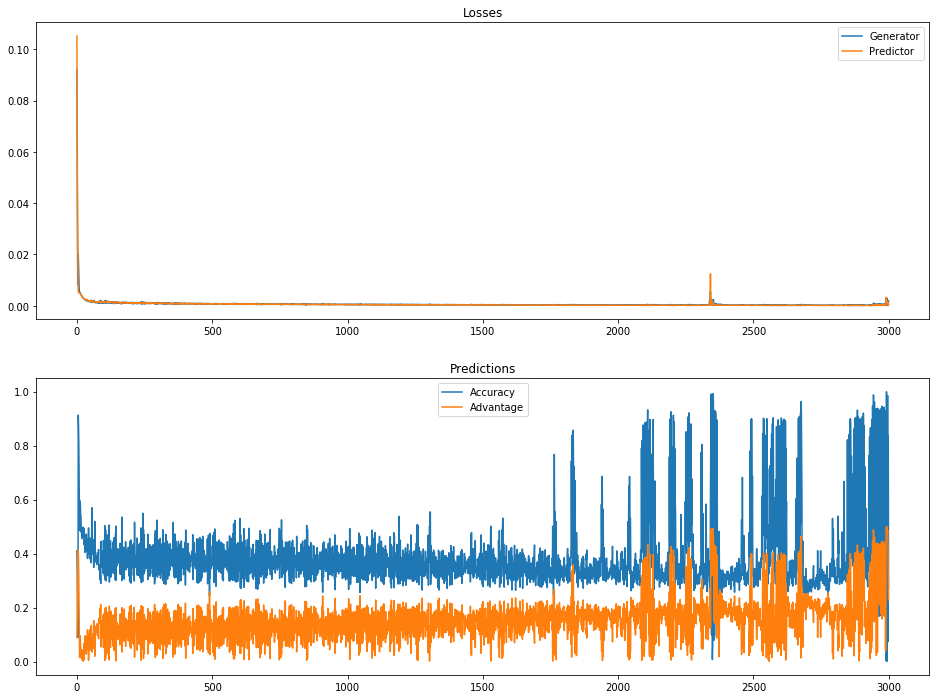

In [9]:
cprng_gan.show_curves()

Predictor의 성능을 아주 조금 낮췄습니다.

____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
sequence_input (InputLayer)                  (None, 112)                             0              
____________________________________________________________________________________________________
splitter (Lambda)                            [(None, 111), (None, 1)]                0              
____________________________________________________________________________________________________
dense_1 (Dense)                              (None, 30)                              3360           
____________________________________________________________________________________________________
leakyReLU_1 (LeakyReLU)                      (None, 30)                              0              
___________________________________________________________________________________________

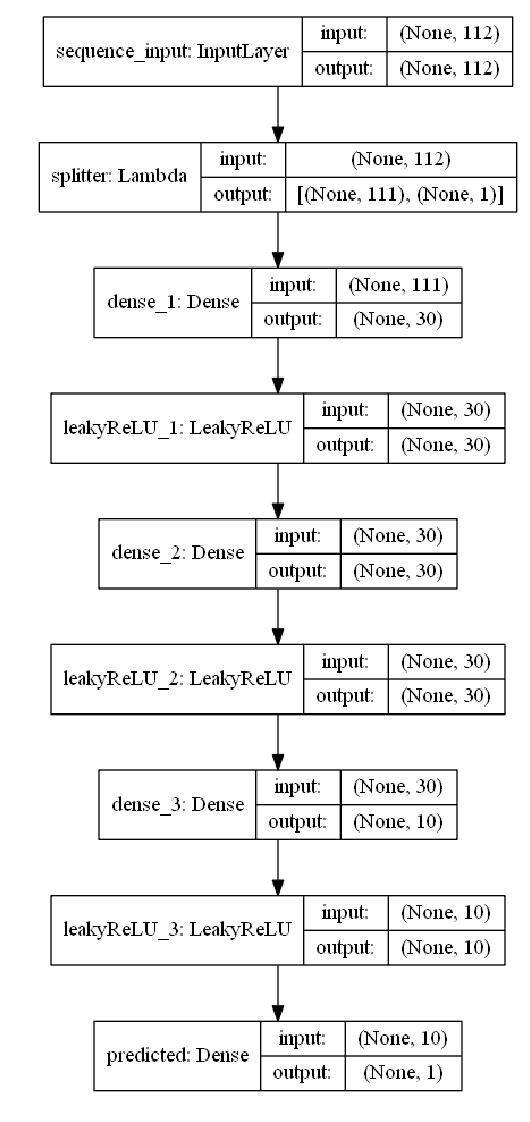

____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
g_dense_1 (Dense)                            (None, 30)                              990            
____________________________________________________________________________________________________
g_leakyReLU_1 (LeakyReLU)                    (None, 30)                              0              
____________________________________________________________________________________________________
g_dense_2 (Dense)                            (None, 30)                              930            
____________________________________________________________________________________________________
g_leakyReLU_2 (LeakyReLU)                    (None, 30)                              0              
___________________________________________________________________________________________

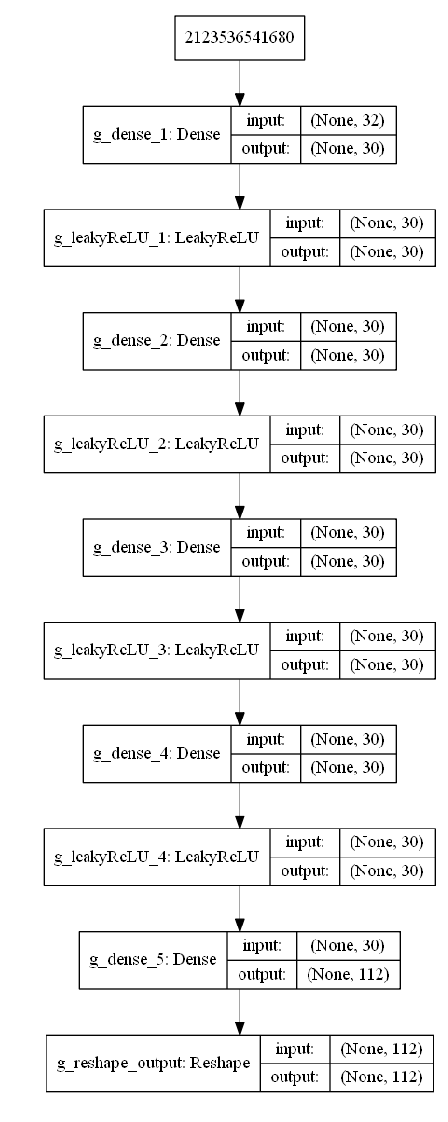

____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
latent_input (InputLayer)                    (None, 32)                              0              
____________________________________________________________________________________________________
generator (Model)                            (None, 112)                             7252           
____________________________________________________________________________________________________
predictor (Model)                            [(None, 1), (None, 1)]                  4611           
Total params: 11,863
Trainable params: 7,252
Non-trainable params: 4,611
____________________________________________________________________________________________________


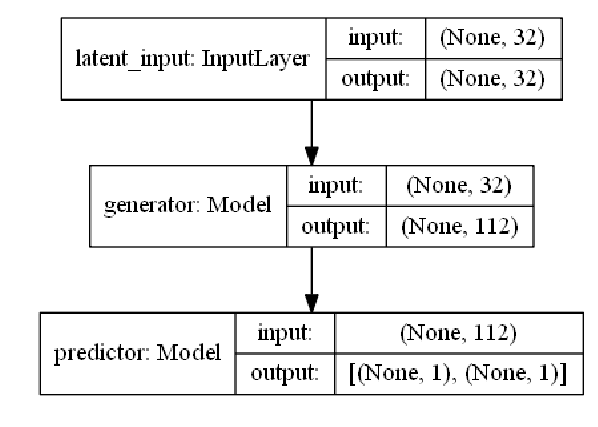

0 [P loss: 0.018209, acc.: 100.00%] [G loss: 0.039851]
[0 1 1 1 0 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1 0 0 0 0 1 0 0
 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 1 0 1 0 1 1 1 0 0 1 1 1 0 0
 0 1 0 1 0 0 0 0 1 1 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 1 1 1 0 0 1
 0]
[0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0
 0 0 1 1 1 1 1 0 0 1 0 0 1 0 0 1 1 0 0 1 1 1 0 1 0 1 1 1 1 0 0 1 0 1 0 0 1
 0 1 0 0 0 1 0 0 1 1 0 0 0 1 1 1 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 1 1 1 0 0 1
 0]
[1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 1 0 0 1 0 0 1 1 1 0 0 1 0 0 0
 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 1 1 0 1 1 1 1 0 0 0 0 1
 0 0 0 1 0 1 1 0 1 1 0 1 0 0 1 0 0 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 1 0 1
 0]
[0 0 1 0 1 1 0 1 0 0 1 1 0 0 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 0
 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1
 0 1 0 0 1 1 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 1
 0]
[0 1 1 0 1 1 0 1 1 0 1 1 0 1 

112 [P loss: 0.000945, acc.: 58.59%] [G loss: 0.000643]
113 [P loss: 0.000860, acc.: 32.81%] [G loss: 0.001084]
114 [P loss: 0.000807, acc.: 31.25%] [G loss: 0.001176]
115 [P loss: 0.000767, acc.: 30.47%] [G loss: 0.001118]
116 [P loss: 0.000836, acc.: 39.06%] [G loss: 0.000824]
117 [P loss: 0.000846, acc.: 30.47%] [G loss: 0.001127]
118 [P loss: 0.000870, acc.: 32.03%] [G loss: 0.000843]
119 [P loss: 0.000850, acc.: 53.12%] [G loss: 0.000650]
120 [P loss: 0.001228, acc.: 39.06%] [G loss: 0.001361]
121 [P loss: 0.000950, acc.: 82.03%] [G loss: 0.000601]
122 [P loss: 0.000650, acc.: 86.72%] [G loss: 0.001073]
123 [P loss: 0.001201, acc.: 49.22%] [G loss: 0.001007]
124 [P loss: 0.000958, acc.: 39.06%] [G loss: 0.002526]
125 [P loss: 0.000878, acc.: 72.66%] [G loss: 0.000946]
126 [P loss: 0.001921, acc.: 97.66%] [G loss: 0.002505]
127 [P loss: 0.001041, acc.: 89.84%] [G loss: 0.001443]
128 [P loss: 0.000645, acc.: 58.59%] [G loss: 0.000607]
129 [P loss: 0.000716, acc.: 86.72%] [G loss: 0.

224 [P loss: 0.000633, acc.: 40.62%] [G loss: 0.000811]
225 [P loss: 0.000484, acc.: 31.25%] [G loss: 0.000424]
226 [P loss: 0.000613, acc.: 32.81%] [G loss: 0.000993]
227 [P loss: 0.000700, acc.: 35.94%] [G loss: 0.000950]
228 [P loss: 0.000813, acc.: 34.38%] [G loss: 0.000637]
229 [P loss: 0.000529, acc.: 55.47%] [G loss: 0.000941]
230 [P loss: 0.000717, acc.: 39.84%] [G loss: 0.000837]
231 [P loss: 0.000487, acc.: 72.66%] [G loss: 0.000923]
232 [P loss: 0.000800, acc.: 44.53%] [G loss: 0.000621]
233 [P loss: 0.000571, acc.: 56.25%] [G loss: 0.000868]
234 [P loss: 0.000697, acc.: 39.06%] [G loss: 0.000470]
235 [P loss: 0.000509, acc.: 55.47%] [G loss: 0.000406]
236 [P loss: 0.000697, acc.: 22.66%] [G loss: 0.001100]
237 [P loss: 0.000476, acc.: 74.22%] [G loss: 0.000608]
238 [P loss: 0.000699, acc.: 55.47%] [G loss: 0.000713]
239 [P loss: 0.000533, acc.: 80.47%] [G loss: 0.001186]
240 [P loss: 0.000566, acc.: 35.16%] [G loss: 0.000417]
241 [P loss: 0.000466, acc.: 55.47%] [G loss: 0.

371 [P loss: 0.000473, acc.: 40.62%] [G loss: 0.000525]
372 [P loss: 0.000528, acc.: 40.62%] [G loss: 0.000523]
373 [P loss: 0.000539, acc.: 35.16%] [G loss: 0.000641]
374 [P loss: 0.000584, acc.: 31.25%] [G loss: 0.000745]
375 [P loss: 0.000389, acc.: 52.34%] [G loss: 0.000647]
376 [P loss: 0.000513, acc.: 39.84%] [G loss: 0.000376]
377 [P loss: 0.000454, acc.: 34.38%] [G loss: 0.000782]
378 [P loss: 0.000449, acc.: 37.50%] [G loss: 0.000684]
379 [P loss: 0.000386, acc.: 59.38%] [G loss: 0.000687]
380 [P loss: 0.000882, acc.: 98.44%] [G loss: 0.001028]
381 [P loss: 0.000421, acc.: 95.31%] [G loss: 0.001625]
382 [P loss: 0.000466, acc.: 43.75%] [G loss: 0.000630]
383 [P loss: 0.000498, acc.: 57.03%] [G loss: 0.000467]
384 [P loss: 0.000492, acc.: 28.12%] [G loss: 0.000721]
385 [P loss: 0.000586, acc.: 41.41%] [G loss: 0.000633]
386 [P loss: 0.000392, acc.: 57.81%] [G loss: 0.000494]
387 [P loss: 0.000801, acc.: 53.12%] [G loss: 0.000492]
388 [P loss: 0.000445, acc.: 32.81%] [G loss: 0.

477 [P loss: 0.000505, acc.: 73.44%] [G loss: 0.000464]
478 [P loss: 0.000407, acc.: 68.75%] [G loss: 0.000382]
479 [P loss: 0.000347, acc.: 95.31%] [G loss: 0.001617]
480 [P loss: 0.000459, acc.: 89.06%] [G loss: 0.000687]
481 [P loss: 0.000396, acc.: 40.62%] [G loss: 0.000368]
482 [P loss: 0.000420, acc.: 96.09%] [G loss: 0.001551]
483 [P loss: 0.000569, acc.: 89.84%] [G loss: 0.000530]
484 [P loss: 0.000773, acc.: 42.19%] [G loss: 0.000339]
485 [P loss: 0.000432, acc.: 46.09%] [G loss: 0.000406]
486 [P loss: 0.000404, acc.: 64.06%] [G loss: 0.001029]
487 [P loss: 0.000439, acc.: 57.81%] [G loss: 0.000298]
488 [P loss: 0.000499, acc.: 44.53%] [G loss: 0.000381]
489 [P loss: 0.000377, acc.: 60.94%] [G loss: 0.000778]
490 [P loss: 0.000446, acc.: 55.47%] [G loss: 0.000539]
491 [P loss: 0.000317, acc.: 81.25%] [G loss: 0.000692]
492 [P loss: 0.000400, acc.: 57.81%] [G loss: 0.000328]
493 [P loss: 0.000632, acc.: 38.28%] [G loss: 0.000510]
494 [P loss: 0.000504, acc.: 30.47%] [G loss: 0.

604 [P loss: 0.000407, acc.: 29.69%] [G loss: 0.000748]
605 [P loss: 0.000399, acc.: 39.06%] [G loss: 0.000498]
606 [P loss: 0.000344, acc.: 61.72%] [G loss: 0.000401]
607 [P loss: 0.000343, acc.: 50.00%] [G loss: 0.000368]
608 [P loss: 0.000426, acc.: 28.91%] [G loss: 0.000561]
609 [P loss: 0.000351, acc.: 32.03%] [G loss: 0.000412]
610 [P loss: 0.000491, acc.: 42.97%] [G loss: 0.000416]
611 [P loss: 0.000388, acc.: 33.59%] [G loss: 0.000502]
612 [P loss: 0.000425, acc.: 28.91%] [G loss: 0.000456]
613 [P loss: 0.000372, acc.: 41.41%] [G loss: 0.000329]
614 [P loss: 0.000415, acc.: 39.84%] [G loss: 0.000477]
615 [P loss: 0.000376, acc.: 40.62%] [G loss: 0.000684]
616 [P loss: 0.000307, acc.: 42.97%] [G loss: 0.000246]
617 [P loss: 0.000340, acc.: 32.81%] [G loss: 0.000453]
618 [P loss: 0.000384, acc.: 27.34%] [G loss: 0.000813]
619 [P loss: 0.000367, acc.: 43.75%] [G loss: 0.000246]
620 [P loss: 0.000521, acc.: 35.94%] [G loss: 0.000659]
621 [P loss: 0.000272, acc.: 71.09%] [G loss: 0.

752 [P loss: 0.000543, acc.: 49.22%] [G loss: 0.000436]
753 [P loss: 0.000328, acc.: 49.22%] [G loss: 0.000794]
754 [P loss: 0.000319, acc.: 38.28%] [G loss: 0.000393]
755 [P loss: 0.000390, acc.: 39.06%] [G loss: 0.000621]
756 [P loss: 0.000330, acc.: 62.50%] [G loss: 0.000250]
757 [P loss: 0.000406, acc.: 25.78%] [G loss: 0.000550]
758 [P loss: 0.000367, acc.: 39.84%] [G loss: 0.000273]
759 [P loss: 0.000380, acc.: 57.03%] [G loss: 0.000286]
760 [P loss: 0.000394, acc.: 28.12%] [G loss: 0.000687]
761 [P loss: 0.000349, acc.: 35.94%] [G loss: 0.000389]
762 [P loss: 0.000375, acc.: 28.91%] [G loss: 0.000521]
763 [P loss: 0.000327, acc.: 40.62%] [G loss: 0.000334]
764 [P loss: 0.000332, acc.: 50.78%] [G loss: 0.000327]
765 [P loss: 0.000290, acc.: 59.38%] [G loss: 0.000547]
766 [P loss: 0.000459, acc.: 49.22%] [G loss: 0.000383]
767 [P loss: 0.000295, acc.: 55.47%] [G loss: 0.000585]
768 [P loss: 0.000352, acc.: 35.16%] [G loss: 0.000477]
769 [P loss: 0.000402, acc.: 28.12%] [G loss: 0.

859 [P loss: 0.000326, acc.: 49.22%] [G loss: 0.000414]
860 [P loss: 0.000335, acc.: 24.22%] [G loss: 0.000683]
861 [P loss: 0.000322, acc.: 39.06%] [G loss: 0.000326]
862 [P loss: 0.000315, acc.: 28.91%] [G loss: 0.000498]
863 [P loss: 0.000303, acc.: 45.31%] [G loss: 0.000341]
864 [P loss: 0.000504, acc.: 55.47%] [G loss: 0.000254]
865 [P loss: 0.000282, acc.: 32.81%] [G loss: 0.000343]
866 [P loss: 0.000338, acc.: 27.34%] [G loss: 0.000362]
867 [P loss: 0.000366, acc.: 39.84%] [G loss: 0.000266]
868 [P loss: 0.000373, acc.: 37.50%] [G loss: 0.000469]
869 [P loss: 0.000244, acc.: 63.28%] [G loss: 0.000471]
870 [P loss: 0.000379, acc.: 46.88%] [G loss: 0.000256]
871 [P loss: 0.000286, acc.: 46.09%] [G loss: 0.000264]
872 [P loss: 0.000391, acc.: 29.69%] [G loss: 0.000479]
873 [P loss: 0.000310, acc.: 32.03%] [G loss: 0.000575]
874 [P loss: 0.000270, acc.: 39.84%] [G loss: 0.000380]
875 [P loss: 0.000344, acc.: 36.72%] [G loss: 0.000485]
876 [P loss: 0.000321, acc.: 53.12%] [G loss: 0.

1007 [P loss: 0.000322, acc.: 42.97%] [G loss: 0.000301]
1008 [P loss: 0.000326, acc.: 29.69%] [G loss: 0.000498]
1009 [P loss: 0.000244, acc.: 42.19%] [G loss: 0.000235]
1010 [P loss: 0.000224, acc.: 89.06%] [G loss: 0.000431]
1011 [P loss: 0.000448, acc.: 57.81%] [G loss: 0.000255]
1012 [P loss: 0.000245, acc.: 39.06%] [G loss: 0.000403]
1013 [P loss: 0.000239, acc.: 40.62%] [G loss: 0.000265]
1014 [P loss: 0.000301, acc.: 35.16%] [G loss: 0.000460]
1015 [P loss: 0.000322, acc.: 28.91%] [G loss: 0.000627]
1016 [P loss: 0.000302, acc.: 58.59%] [G loss: 0.000276]
1017 [P loss: 0.000280, acc.: 44.53%] [G loss: 0.000568]
1018 [P loss: 0.000250, acc.: 47.66%] [G loss: 0.000452]
1019 [P loss: 0.000367, acc.: 44.53%] [G loss: 0.000256]
1020 [P loss: 0.000486, acc.: 28.91%] [G loss: 0.000496]
1021 [P loss: 0.000302, acc.: 31.25%] [G loss: 0.000573]
1022 [P loss: 0.000324, acc.: 37.50%] [G loss: 0.000271]
1023 [P loss: 0.000316, acc.: 42.19%] [G loss: 0.000505]
1024 [P loss: 0.000218, acc.: 6

1155 [P loss: 0.000400, acc.: 35.16%] [G loss: 0.000569]
1156 [P loss: 0.000416, acc.: 30.47%] [G loss: 0.000727]
1157 [P loss: 0.000379, acc.: 44.53%] [G loss: 0.000573]
1158 [P loss: 0.000455, acc.: 21.88%] [G loss: 0.000881]
1159 [P loss: 0.000224, acc.: 53.12%] [G loss: 0.000221]
1160 [P loss: 0.000694, acc.: 47.66%] [G loss: 0.000301]
1161 [P loss: 0.000524, acc.: 18.75%] [G loss: 0.000891]
1162 [P loss: 0.000300, acc.: 48.44%] [G loss: 0.000293]
1163 [P loss: 0.000277, acc.: 24.22%] [G loss: 0.000632]
1164 [P loss: 0.000345, acc.: 32.03%] [G loss: 0.000483]
1165 [P loss: 0.000312, acc.: 28.12%] [G loss: 0.000665]
1166 [P loss: 0.000309, acc.: 28.12%] [G loss: 0.000616]
1167 [P loss: 0.000343, acc.: 36.72%] [G loss: 0.000494]
1168 [P loss: 0.000312, acc.: 25.78%] [G loss: 0.000704]
1169 [P loss: 0.000396, acc.: 31.25%] [G loss: 0.000639]
1170 [P loss: 0.000320, acc.: 26.56%] [G loss: 0.000601]
1171 [P loss: 0.000299, acc.: 37.50%] [G loss: 0.000334]
1172 [P loss: 0.000232, acc.: 5

1260 [P loss: 0.000284, acc.: 62.50%] [G loss: 0.000218]
1261 [P loss: 0.000304, acc.: 25.00%] [G loss: 0.000648]
1262 [P loss: 0.000260, acc.: 37.50%] [G loss: 0.000344]
1263 [P loss: 0.000273, acc.: 35.16%] [G loss: 0.000267]
1264 [P loss: 0.000285, acc.: 36.72%] [G loss: 0.000267]
1265 [P loss: 0.000361, acc.: 32.03%] [G loss: 0.000411]
1266 [P loss: 0.000216, acc.: 53.12%] [G loss: 0.000346]
1267 [P loss: 0.000308, acc.: 38.28%] [G loss: 0.000359]
1268 [P loss: 0.000297, acc.: 24.22%] [G loss: 0.000409]
1269 [P loss: 0.000304, acc.: 32.81%] [G loss: 0.000407]
1270 [P loss: 0.000245, acc.: 34.38%] [G loss: 0.000461]
1271 [P loss: 0.000271, acc.: 41.41%] [G loss: 0.000325]
1272 [P loss: 0.000306, acc.: 42.19%] [G loss: 0.000347]
1273 [P loss: 0.000293, acc.: 31.25%] [G loss: 0.000478]
1274 [P loss: 0.000252, acc.: 35.94%] [G loss: 0.000335]
1275 [P loss: 0.000315, acc.: 22.66%] [G loss: 0.000544]
1276 [P loss: 0.000215, acc.: 75.00%] [G loss: 0.000240]
1277 [P loss: 0.000239, acc.: 4

1401 [P loss: 0.000310, acc.: 22.66%] [G loss: 0.000560]
1402 [P loss: 0.000208, acc.: 39.84%] [G loss: 0.000260]
1403 [P loss: 0.000279, acc.: 48.44%] [G loss: 0.000211]
1404 [P loss: 0.000221, acc.: 35.16%] [G loss: 0.000236]
1405 [P loss: 0.000374, acc.: 42.97%] [G loss: 0.000433]
1406 [P loss: 0.000225, acc.: 78.12%] [G loss: 0.000178]
1407 [P loss: 0.000334, acc.: 25.00%] [G loss: 0.000541]
1408 [P loss: 0.000218, acc.: 75.00%] [G loss: 0.000289]
1409 [P loss: 0.000379, acc.: 60.16%] [G loss: 0.000230]
1410 [P loss: 0.000174, acc.: 81.25%] [G loss: 0.000317]
1411 [P loss: 0.000369, acc.: 60.16%] [G loss: 0.000186]
1412 [P loss: 0.000334, acc.: 39.06%] [G loss: 0.000478]
1413 [P loss: 0.000196, acc.: 86.72%] [G loss: 0.000305]
1414 [P loss: 0.000299, acc.: 33.59%] [G loss: 0.000450]
1415 [P loss: 0.000234, acc.: 80.47%] [G loss: 0.000626]
1416 [P loss: 0.000239, acc.: 78.12%] [G loss: 0.000247]
1417 [P loss: 0.000309, acc.: 32.03%] [G loss: 0.000466]
1418 [P loss: 0.000275, acc.: 4

1550 [P loss: 0.000370, acc.: 42.97%] [G loss: 0.000276]
1551 [P loss: 0.000200, acc.: 71.88%] [G loss: 0.000358]
1552 [P loss: 0.000345, acc.: 50.00%] [G loss: 0.000237]
1553 [P loss: 0.000230, acc.: 54.69%] [G loss: 0.000504]
1554 [P loss: 0.000294, acc.: 40.62%] [G loss: 0.000259]
1555 [P loss: 0.000244, acc.: 29.69%] [G loss: 0.000309]
1556 [P loss: 0.000204, acc.: 38.28%] [G loss: 0.000240]
1557 [P loss: 0.000265, acc.: 57.81%] [G loss: 0.000304]
1558 [P loss: 0.000189, acc.: 74.22%] [G loss: 0.000265]
1559 [P loss: 0.000260, acc.: 37.50%] [G loss: 0.000407]
1560 [P loss: 0.000187, acc.: 84.38%] [G loss: 0.000466]
1561 [P loss: 0.000220, acc.: 70.31%] [G loss: 0.000289]
1562 [P loss: 0.000279, acc.: 81.25%] [G loss: 0.000331]
1563 [P loss: 0.000667, acc.: 97.66%] [G loss: 0.001365]
1564 [P loss: 0.000266, acc.: 94.53%] [G loss: 0.001555]
1565 [P loss: 0.000796, acc.: 24.22%] [G loss: 0.000211]
1566 [P loss: 0.000277, acc.: 74.22%] [G loss: 0.000466]
1567 [P loss: 0.001010, acc.: 4

1655 [P loss: 0.000246, acc.: 40.62%] [G loss: 0.000451]
1656 [P loss: 0.000291, acc.: 48.44%] [G loss: 0.000279]
1657 [P loss: 0.000176, acc.: 75.78%] [G loss: 0.000399]
1658 [P loss: 0.000274, acc.: 44.53%] [G loss: 0.000221]
1659 [P loss: 0.000350, acc.: 30.47%] [G loss: 0.000544]
1660 [P loss: 0.000197, acc.: 60.16%] [G loss: 0.000164]
1661 [P loss: 0.000314, acc.: 32.03%] [G loss: 0.000484]
1662 [P loss: 0.000275, acc.: 23.44%] [G loss: 0.000587]
1663 [P loss: 0.000267, acc.: 55.47%] [G loss: 0.000204]
1664 [P loss: 0.000285, acc.: 17.19%] [G loss: 0.000613]
1665 [P loss: 0.000269, acc.: 36.72%] [G loss: 0.000403]
1666 [P loss: 0.000223, acc.: 37.50%] [G loss: 0.000300]
1667 [P loss: 0.000335, acc.: 39.84%] [G loss: 0.000364]
1668 [P loss: 0.000215, acc.: 22.66%] [G loss: 0.000445]
1669 [P loss: 0.000212, acc.: 42.19%] [G loss: 0.000158]
1670 [P loss: 0.000172, acc.: 92.19%] [G loss: 0.000280]
1671 [P loss: 0.000285, acc.: 65.62%] [G loss: 0.000169]
1672 [P loss: 0.000291, acc.: 3

1803 [P loss: 0.000162, acc.: 41.41%] [G loss: 0.000176]
1804 [P loss: 0.000344, acc.: 39.06%] [G loss: 0.000285]
1805 [P loss: 0.000186, acc.: 80.47%] [G loss: 0.000430]
1806 [P loss: 0.000192, acc.: 50.78%] [G loss: 0.000169]
1807 [P loss: 0.000264, acc.: 35.16%] [G loss: 0.000371]
1808 [P loss: 0.000145, acc.: 84.38%] [G loss: 0.000367]
1809 [P loss: 0.000192, acc.: 52.34%] [G loss: 0.000151]
1810 [P loss: 0.000335, acc.: 50.00%] [G loss: 0.000283]
1811 [P loss: 0.000181, acc.: 90.62%] [G loss: 0.000294]
1812 [P loss: 0.000301, acc.: 77.34%] [G loss: 0.000136]
1813 [P loss: 0.000232, acc.: 48.44%] [G loss: 0.000263]
1814 [P loss: 0.000188, acc.: 51.56%] [G loss: 0.000497]
1815 [P loss: 0.000265, acc.: 36.72%] [G loss: 0.000253]
1816 [P loss: 0.000260, acc.: 37.50%] [G loss: 0.000256]
1817 [P loss: 0.000231, acc.: 32.81%] [G loss: 0.000298]
1818 [P loss: 0.000192, acc.: 28.91%] [G loss: 0.000277]
1819 [P loss: 0.000209, acc.: 35.16%] [G loss: 0.000284]
1820 [P loss: 0.000197, acc.: 3

1951 [P loss: 0.000423, acc.: 43.75%] [G loss: 0.000284]
1952 [P loss: 0.000280, acc.: 26.56%] [G loss: 0.000620]
1953 [P loss: 0.000211, acc.: 40.62%] [G loss: 0.000378]
1954 [P loss: 0.000288, acc.: 32.03%] [G loss: 0.000470]
1955 [P loss: 0.000275, acc.: 36.72%] [G loss: 0.000492]
1956 [P loss: 0.000178, acc.: 32.03%] [G loss: 0.000167]
1957 [P loss: 0.000196, acc.: 32.81%] [G loss: 0.000166]
1958 [P loss: 0.000354, acc.: 27.34%] [G loss: 0.000470]
1959 [P loss: 0.000248, acc.: 35.16%] [G loss: 0.000365]
1960 [P loss: 0.000281, acc.: 36.72%] [G loss: 0.000277]
1961 [P loss: 0.000351, acc.: 37.50%] [G loss: 0.000385]
1962 [P loss: 0.000299, acc.: 28.12%] [G loss: 0.000497]
1963 [P loss: 0.000294, acc.: 43.75%] [G loss: 0.000419]
1964 [P loss: 0.000202, acc.: 39.84%] [G loss: 0.000468]
1965 [P loss: 0.000267, acc.: 42.97%] [G loss: 0.000252]
1966 [P loss: 0.000284, acc.: 28.12%] [G loss: 0.000538]
1967 [P loss: 0.000217, acc.: 42.97%] [G loss: 0.000291]
1968 [P loss: 0.000280, acc.: 4

2056 [P loss: 0.000308, acc.: 52.34%] [G loss: 0.000224]
2057 [P loss: 0.000184, acc.: 61.72%] [G loss: 0.000334]
2058 [P loss: 0.000277, acc.: 53.12%] [G loss: 0.000213]
2059 [P loss: 0.000263, acc.: 32.03%] [G loss: 0.000411]
2060 [P loss: 0.000205, acc.: 40.62%] [G loss: 0.000175]
2061 [P loss: 0.000207, acc.: 60.16%] [G loss: 0.000588]
2062 [P loss: 0.000205, acc.: 85.16%] [G loss: 0.000631]
2063 [P loss: 0.000247, acc.: 72.66%] [G loss: 0.000154]
2064 [P loss: 0.000317, acc.: 40.62%] [G loss: 0.000447]
2065 [P loss: 0.000201, acc.: 34.38%] [G loss: 0.000322]
2066 [P loss: 0.000223, acc.: 37.50%] [G loss: 0.000365]
2067 [P loss: 0.000216, acc.: 36.72%] [G loss: 0.000308]
2068 [P loss: 0.000260, acc.: 35.94%] [G loss: 0.000364]
2069 [P loss: 0.000262, acc.: 30.47%] [G loss: 0.000472]
2070 [P loss: 0.000267, acc.: 26.56%] [G loss: 0.000391]
2071 [P loss: 0.000190, acc.: 39.84%] [G loss: 0.000152]
2072 [P loss: 0.000205, acc.: 81.25%] [G loss: 0.000362]
2073 [P loss: 0.000361, acc.: 6

2204 [P loss: 0.000193, acc.: 35.94%] [G loss: 0.000285]
2205 [P loss: 0.000203, acc.: 61.72%] [G loss: 0.000468]
2206 [P loss: 0.000219, acc.: 64.06%] [G loss: 0.000137]
2207 [P loss: 0.000189, acc.: 33.59%] [G loss: 0.000426]
2208 [P loss: 0.000197, acc.: 35.16%] [G loss: 0.000204]
2209 [P loss: 0.000170, acc.: 51.56%] [G loss: 0.000183]
2210 [P loss: 0.000237, acc.: 23.44%] [G loss: 0.000423]
2211 [P loss: 0.000200, acc.: 48.44%] [G loss: 0.000129]
2212 [P loss: 0.000330, acc.: 33.59%] [G loss: 0.000284]
2213 [P loss: 0.000224, acc.: 15.62%] [G loss: 0.000530]
2214 [P loss: 0.000170, acc.: 44.53%] [G loss: 0.000167]
2215 [P loss: 0.000258, acc.: 35.94%] [G loss: 0.000363]
2216 [P loss: 0.000185, acc.: 53.91%] [G loss: 0.000377]
2217 [P loss: 0.000185, acc.: 45.31%] [G loss: 0.000144]
2218 [P loss: 0.000282, acc.: 45.31%] [G loss: 0.000349]
2219 [P loss: 0.000152, acc.: 89.06%] [G loss: 0.000373]
2220 [P loss: 0.000205, acc.: 69.53%] [G loss: 0.000126]
2221 [P loss: 0.000222, acc.: 3

2352 [P loss: 0.000233, acc.: 51.56%] [G loss: 0.000334]
2353 [P loss: 0.000259, acc.: 92.97%] [G loss: 0.000151]
2354 [P loss: 0.000204, acc.: 82.03%] [G loss: 0.000669]
2355 [P loss: 0.000159, acc.: 53.91%] [G loss: 0.000136]
2356 [P loss: 0.000201, acc.: 42.19%] [G loss: 0.000297]
2357 [P loss: 0.000207, acc.: 30.47%] [G loss: 0.000408]
2358 [P loss: 0.000241, acc.: 47.66%] [G loss: 0.000182]
2359 [P loss: 0.000238, acc.: 25.00%] [G loss: 0.000394]
2360 [P loss: 0.000209, acc.: 34.38%] [G loss: 0.000181]
2361 [P loss: 0.000189, acc.: 57.03%] [G loss: 0.000285]
2362 [P loss: 0.000168, acc.: 76.56%] [G loss: 0.000365]
2363 [P loss: 0.000322, acc.: 60.16%] [G loss: 0.000141]
2364 [P loss: 0.000181, acc.: 32.03%] [G loss: 0.000271]
2365 [P loss: 0.000259, acc.: 22.66%] [G loss: 0.000601]
2366 [P loss: 0.000137, acc.: 63.28%] [G loss: 0.000274]
2367 [P loss: 0.000149, acc.: 84.38%] [G loss: 0.000306]
2368 [P loss: 0.000184, acc.: 75.00%] [G loss: 0.000120]
2369 [P loss: 0.000210, acc.: 3

2456 [P loss: 0.000261, acc.: 42.97%] [G loss: 0.000248]
2457 [P loss: 0.000204, acc.: 24.22%] [G loss: 0.000518]
2458 [P loss: 0.000193, acc.: 42.19%] [G loss: 0.000248]
2459 [P loss: 0.000241, acc.: 21.88%] [G loss: 0.000327]
2460 [P loss: 0.000188, acc.: 47.66%] [G loss: 0.000177]
2461 [P loss: 0.000200, acc.: 25.78%] [G loss: 0.000449]
2462 [P loss: 0.000169, acc.: 35.94%] [G loss: 0.000203]
2463 [P loss: 0.000165, acc.: 34.38%] [G loss: 0.000203]
2464 [P loss: 0.000279, acc.: 28.12%] [G loss: 0.000297]
2465 [P loss: 0.000210, acc.: 35.94%] [G loss: 0.000300]
2466 [P loss: 0.000204, acc.: 30.47%] [G loss: 0.000361]
2467 [P loss: 0.000203, acc.: 28.91%] [G loss: 0.000339]
2468 [P loss: 0.000206, acc.: 32.81%] [G loss: 0.000323]
2469 [P loss: 0.000189, acc.: 32.81%] [G loss: 0.000300]
2470 [P loss: 0.000198, acc.: 28.12%] [G loss: 0.000252]
2471 [P loss: 0.000190, acc.: 29.69%] [G loss: 0.000242]
2472 [P loss: 0.000215, acc.: 23.44%] [G loss: 0.000302]
2473 [P loss: 0.000209, acc.: 3

2604 [P loss: 0.000172, acc.: 49.22%] [G loss: 0.000400]
2605 [P loss: 0.000181, acc.: 56.25%] [G loss: 0.000110]
2606 [P loss: 0.000245, acc.: 35.94%] [G loss: 0.000390]
2607 [P loss: 0.000293, acc.: 82.03%] [G loss: 0.000109]
2608 [P loss: 0.000138, acc.: 93.75%] [G loss: 0.000313]
2609 [P loss: 0.000279, acc.: 64.06%] [G loss: 0.000174]
2610 [P loss: 0.000173, acc.: 30.47%] [G loss: 0.000386]
2611 [P loss: 0.000198, acc.: 37.50%] [G loss: 0.000233]
2612 [P loss: 0.000218, acc.: 36.72%] [G loss: 0.000178]
2613 [P loss: 0.000240, acc.: 21.09%] [G loss: 0.000400]
2614 [P loss: 0.000186, acc.: 29.69%] [G loss: 0.000330]
2615 [P loss: 0.000174, acc.: 32.03%] [G loss: 0.000290]
2616 [P loss: 0.000167, acc.: 35.16%] [G loss: 0.000172]
2617 [P loss: 0.000164, acc.: 45.31%] [G loss: 0.000194]
2618 [P loss: 0.000182, acc.: 27.34%] [G loss: 0.000281]
2619 [P loss: 0.000167, acc.: 38.28%] [G loss: 0.000238]
2620 [P loss: 0.000182, acc.: 30.47%] [G loss: 0.000344]
2621 [P loss: 0.000184, acc.: 4

2753 [P loss: 0.000198, acc.: 23.44%] [G loss: 0.000330]
2754 [P loss: 0.000185, acc.: 34.38%] [G loss: 0.000196]
2755 [P loss: 0.000207, acc.: 39.06%] [G loss: 0.000288]
2756 [P loss: 0.000160, acc.: 76.56%] [G loss: 0.000124]
2757 [P loss: 0.000157, acc.: 43.75%] [G loss: 0.000188]
2758 [P loss: 0.000347, acc.: 39.84%] [G loss: 0.000594]
2759 [P loss: 0.000133, acc.: 81.25%] [G loss: 0.000290]
2760 [P loss: 0.000154, acc.: 36.72%] [G loss: 0.000122]
2761 [P loss: 0.000199, acc.: 52.34%] [G loss: 0.000304]
2762 [P loss: 0.000158, acc.: 89.84%] [G loss: 0.000118]
2763 [P loss: 0.000201, acc.: 89.06%] [G loss: 0.000715]
2764 [P loss: 0.000166, acc.: 61.72%] [G loss: 0.000129]
2765 [P loss: 0.000211, acc.: 27.34%] [G loss: 0.000375]
2766 [P loss: 0.000194, acc.: 31.25%] [G loss: 0.000441]
2767 [P loss: 0.000192, acc.: 60.94%] [G loss: 0.000137]
2768 [P loss: 0.000278, acc.: 23.44%] [G loss: 0.000382]
2769 [P loss: 0.000206, acc.: 28.91%] [G loss: 0.000436]
2770 [P loss: 0.000115, acc.: 5

2858 [P loss: 0.000202, acc.: 65.62%] [G loss: 0.000093]
2859 [P loss: 0.000136, acc.: 40.62%] [G loss: 0.000112]
2860 [P loss: 0.000150, acc.: 44.53%] [G loss: 0.000191]
2861 [P loss: 0.000254, acc.: 33.59%] [G loss: 0.000198]
2862 [P loss: 0.000208, acc.: 34.38%] [G loss: 0.000297]
2863 [P loss: 0.000120, acc.: 46.09%] [G loss: 0.000149]
2864 [P loss: 0.000137, acc.: 56.25%] [G loss: 0.000153]
2865 [P loss: 0.000140, acc.: 44.53%] [G loss: 0.000327]
2866 [P loss: 0.000194, acc.: 33.59%] [G loss: 0.000206]
2867 [P loss: 0.000172, acc.: 28.91%] [G loss: 0.000245]
2868 [P loss: 0.000152, acc.: 29.69%] [G loss: 0.000191]
2869 [P loss: 0.000181, acc.: 39.06%] [G loss: 0.000133]
2870 [P loss: 0.000133, acc.: 40.62%] [G loss: 0.000120]
2871 [P loss: 0.000168, acc.: 47.66%] [G loss: 0.000251]
2872 [P loss: 0.000175, acc.: 82.03%] [G loss: 0.000436]
2873 [P loss: 0.000135, acc.: 65.62%] [G loss: 0.000112]
2874 [P loss: 0.000149, acc.: 28.12%] [G loss: 0.000226]
2875 [P loss: 0.000174, acc.: 3

In [11]:
cprng_gan2 = CPRNG_GAN(latent_dim=2 * 16, gen_width=7 * 16,
                     generator = [30, 30, 30, 30],
                     predictor = [30, 30, 10])
cprng_gan2.train(epochs=3000, batch_size=128, sample_interval=200, adv_multiplier = 3)

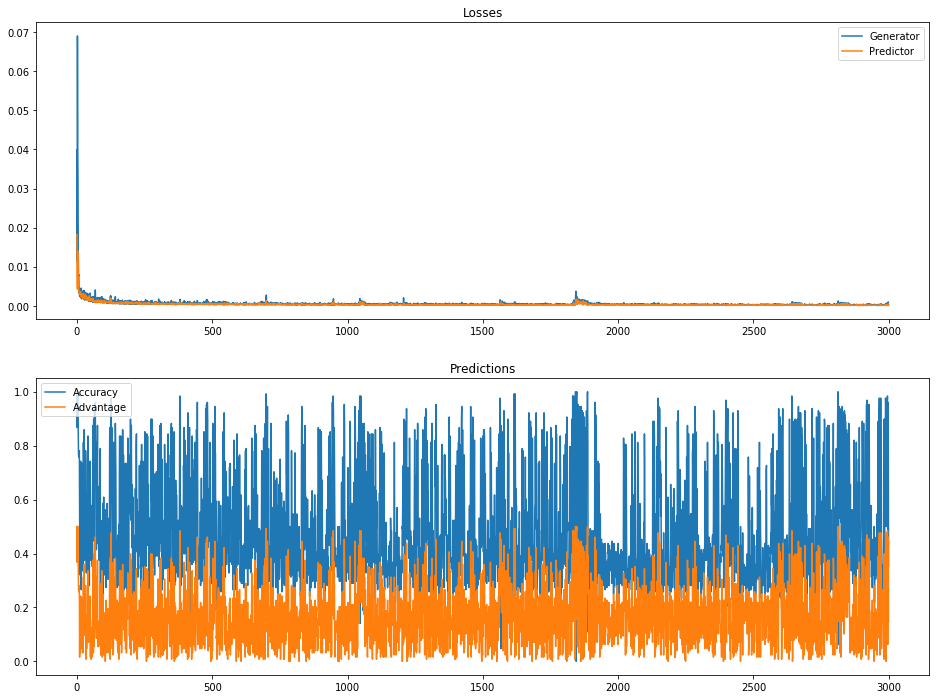

In [12]:
cprng_gan2.show_curves()

**adv_multiplier**는 predictor의 학습 횟수 배율로, generator 학습 1회당 predictor를 몇 번 학습할지를 나타냅니다. 이 값이 크면 predictor가 generator에 대해 좀 더 잘 학습하게 됩니다. 반대로 작으면 predictor가 조금 불리해집니다. 그러나 항상 이런 것은 아닙니다.

____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
sequence_input (InputLayer)                  (None, 112)                             0              
____________________________________________________________________________________________________
splitter (Lambda)                            [(None, 111), (None, 1)]                0              
____________________________________________________________________________________________________
dense_1 (Dense)                              (None, 30)                              3360           
____________________________________________________________________________________________________
leakyReLU_1 (LeakyReLU)                      (None, 30)                              0              
___________________________________________________________________________________________

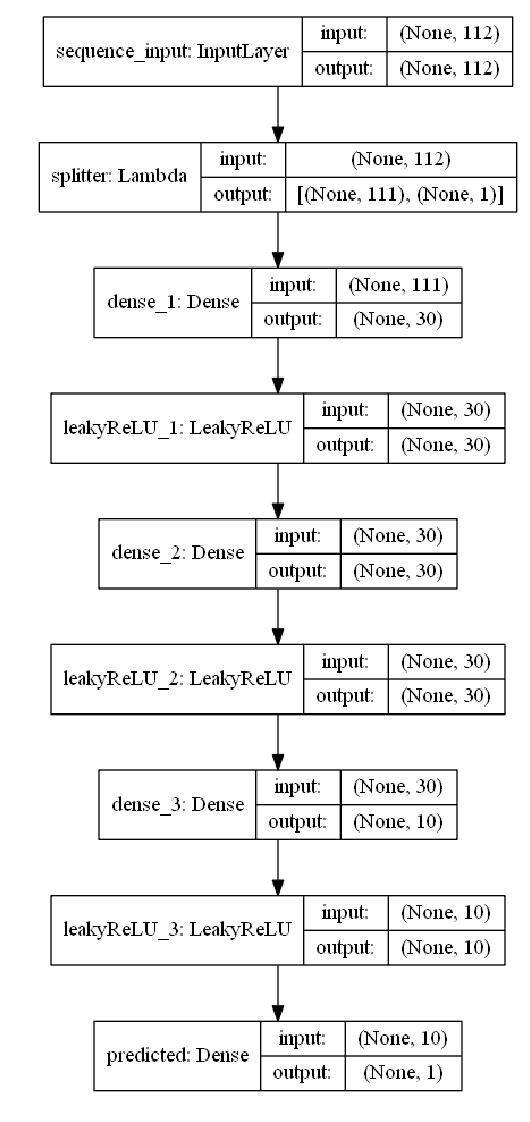

____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
g_dense_1 (Dense)                            (None, 30)                              990            
____________________________________________________________________________________________________
g_leakyReLU_1 (LeakyReLU)                    (None, 30)                              0              
____________________________________________________________________________________________________
g_dense_2 (Dense)                            (None, 30)                              930            
____________________________________________________________________________________________________
g_leakyReLU_2 (LeakyReLU)                    (None, 30)                              0              
___________________________________________________________________________________________

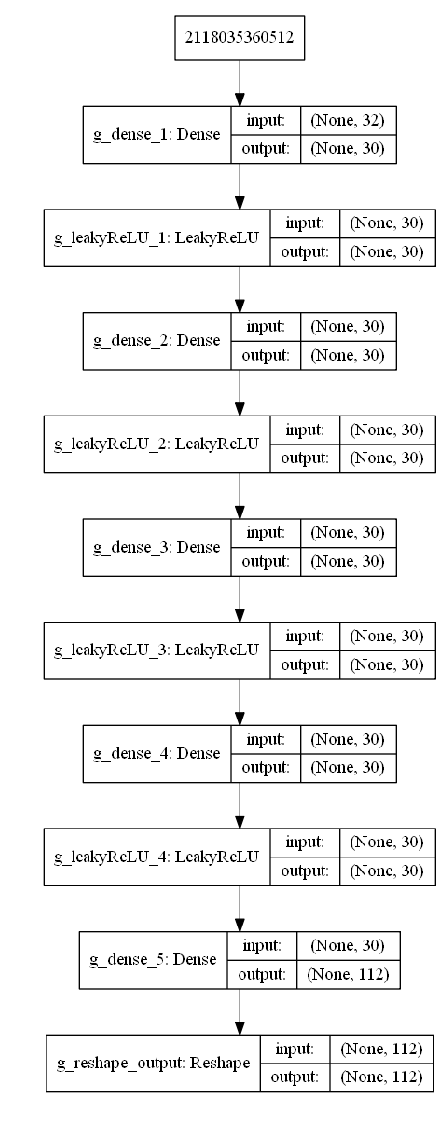

____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
latent_input (InputLayer)                    (None, 32)                              0              
____________________________________________________________________________________________________
generator (Model)                            (None, 112)                             7252           
____________________________________________________________________________________________________
predictor (Model)                            [(None, 1), (None, 1)]                  4611           
Total params: 11,863
Trainable params: 7,252
Non-trainable params: 4,611
____________________________________________________________________________________________________


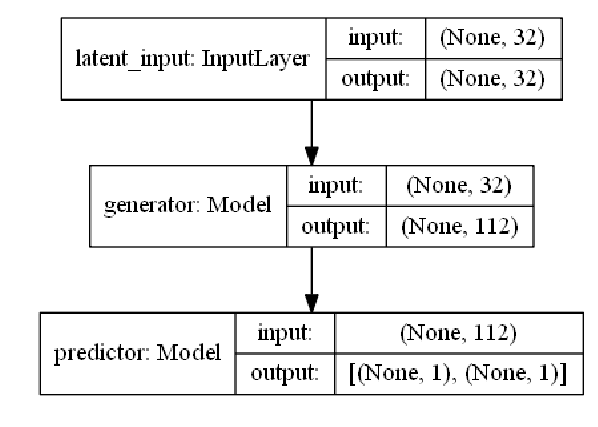

0 [P loss: 0.115754, acc.: 0.00%] [G loss: 0.079560]
[0 1 0 0 0 1 1 1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 1 0 0 0 1 1 0
 1 1 1 0 0 1 1 1 0 1 1 1 1 1 0 1 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 1 1 0 1 1 0
 1 1 1 0 1 1 1 0 0 1 0 1 1 0 1 1 1 0 1 0 1 0 0 1 0 1 0 1 0 1 0 0 1 1 1 1 1
 0]
[1 1 0 0 0 0 1 1 0 0 0 0 0 1 0 1 1 1 1 0 1 0 1 1 0 1 1 1 0 1 1 0 0 0 1 0 0
 1 0 0 0 1 0 1 1 0 1 0 1 1 1 0 0 0 0 0 1 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 1 0
 1 1 0 0 0 1 1 1 0 1 0 1 1 0 1 1 1 0 1 0 1 0 0 1 0 1 0 1 1 0 1 0 0 1 1 0 1
 0]
[1 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 1 1 1 1 0 1 0 0 1 0 0 1 1 1 0 1 0 1 0 0
 1 1 1 0 0 1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 0 1 1 0
 1 1 0 1 0 1 1 0 1 1 0 1 1 0 1 1 1 0 1 0 1 0 0 1 0 1 0 1 0 1 0 0 1 1 1 1 0
 0]
[1 1 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1 0 0 1 1 0 0 1 0 1 1 0 1 1 1 1 0 0 1 1 0
 1 1 1 0 1 0 1 1 0 1 0 1 1 1 0 0 0 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 1 1 0
 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 1 0 1 0 0 1 0 1 0 1 0 1 0 0 0 1 1 1 1
 0]
[1 1 0 0 1 1 0 0 0 0 0 0 0 1 0 

113 [P loss: 0.001392, acc.: 27.34%] [G loss: 0.002730]
114 [P loss: 0.001862, acc.: 58.59%] [G loss: 0.001059]
115 [P loss: 0.001517, acc.: 31.25%] [G loss: 0.002485]
116 [P loss: 0.001725, acc.: 52.34%] [G loss: 0.001121]
117 [P loss: 0.001814, acc.: 18.75%] [G loss: 0.002758]
118 [P loss: 0.001603, acc.: 64.06%] [G loss: 0.001468]
119 [P loss: 0.001504, acc.: 32.81%] [G loss: 0.002034]
120 [P loss: 0.001409, acc.: 53.91%] [G loss: 0.001101]
121 [P loss: 0.001406, acc.: 37.50%] [G loss: 0.001924]
122 [P loss: 0.001465, acc.: 47.66%] [G loss: 0.001086]
123 [P loss: 0.001087, acc.: 38.28%] [G loss: 0.002297]
124 [P loss: 0.001687, acc.: 41.41%] [G loss: 0.000908]
125 [P loss: 0.001225, acc.: 28.91%] [G loss: 0.002277]
126 [P loss: 0.001527, acc.: 57.81%] [G loss: 0.001094]
127 [P loss: 0.001270, acc.: 27.34%] [G loss: 0.002657]
128 [P loss: 0.001477, acc.: 61.72%] [G loss: 0.001370]
129 [P loss: 0.001614, acc.: 22.66%] [G loss: 0.002335]
130 [P loss: 0.001191, acc.: 65.62%] [G loss: 0.

221 [P loss: 0.000783, acc.: 41.41%] [G loss: 0.000963]
222 [P loss: 0.001207, acc.: 35.16%] [G loss: 0.000662]
223 [P loss: 0.000738, acc.: 50.00%] [G loss: 0.001272]
224 [P loss: 0.001279, acc.: 28.91%] [G loss: 0.000887]
225 [P loss: 0.000764, acc.: 60.16%] [G loss: 0.001081]
226 [P loss: 0.001174, acc.: 32.03%] [G loss: 0.001074]
227 [P loss: 0.000693, acc.: 67.19%] [G loss: 0.000771]
228 [P loss: 0.001006, acc.: 32.03%] [G loss: 0.001294]
229 [P loss: 0.001143, acc.: 41.41%] [G loss: 0.000543]
230 [P loss: 0.000840, acc.: 39.06%] [G loss: 0.001319]
231 [P loss: 0.001363, acc.: 38.28%] [G loss: 0.000615]
232 [P loss: 0.000639, acc.: 52.34%] [G loss: 0.001290]
233 [P loss: 0.001169, acc.: 39.06%] [G loss: 0.000778]
234 [P loss: 0.000694, acc.: 53.12%] [G loss: 0.000642]
235 [P loss: 0.000740, acc.: 35.94%] [G loss: 0.000917]
236 [P loss: 0.000830, acc.: 39.06%] [G loss: 0.000758]
237 [P loss: 0.000715, acc.: 56.25%] [G loss: 0.000768]
238 [P loss: 0.000912, acc.: 33.59%] [G loss: 0.

375 [P loss: 0.000944, acc.: 31.25%] [G loss: 0.000973]
376 [P loss: 0.000668, acc.: 53.91%] [G loss: 0.000507]
377 [P loss: 0.000708, acc.: 25.78%] [G loss: 0.001120]
378 [P loss: 0.000928, acc.: 45.31%] [G loss: 0.000457]
379 [P loss: 0.000556, acc.: 39.84%] [G loss: 0.001059]
380 [P loss: 0.001176, acc.: 36.72%] [G loss: 0.000459]
381 [P loss: 0.000571, acc.: 37.50%] [G loss: 0.001064]
382 [P loss: 0.001171, acc.: 25.78%] [G loss: 0.000455]
383 [P loss: 0.000637, acc.: 42.97%] [G loss: 0.001545]
384 [P loss: 0.001363, acc.: 40.62%] [G loss: 0.000519]
385 [P loss: 0.001100, acc.: 14.06%] [G loss: 0.001708]
386 [P loss: 0.000858, acc.: 78.12%] [G loss: 0.001201]
387 [P loss: 0.000856, acc.: 50.78%] [G loss: 0.000747]
388 [P loss: 0.000761, acc.: 48.44%] [G loss: 0.000414]
389 [P loss: 0.000729, acc.: 28.12%] [G loss: 0.001321]
390 [P loss: 0.000936, acc.: 55.47%] [G loss: 0.000453]
391 [P loss: 0.000675, acc.: 35.94%] [G loss: 0.001315]
392 [P loss: 0.001021, acc.: 53.91%] [G loss: 0.

483 [P loss: 0.000633, acc.: 21.88%] [G loss: 0.001323]
484 [P loss: 0.000825, acc.: 62.50%] [G loss: 0.000434]
485 [P loss: 0.000665, acc.: 19.53%] [G loss: 0.001549]
486 [P loss: 0.000975, acc.: 61.72%] [G loss: 0.000744]
487 [P loss: 0.001080, acc.: 7.03%] [G loss: 0.001420]
488 [P loss: 0.000674, acc.: 79.69%] [G loss: 0.000936]
489 [P loss: 0.000853, acc.: 28.91%] [G loss: 0.000891]
490 [P loss: 0.000650, acc.: 56.25%] [G loss: 0.000480]
491 [P loss: 0.000609, acc.: 21.88%] [G loss: 0.001234]
492 [P loss: 0.000769, acc.: 64.06%] [G loss: 0.000521]
493 [P loss: 0.000872, acc.: 10.94%] [G loss: 0.001429]
494 [P loss: 0.000868, acc.: 71.88%] [G loss: 0.000853]
495 [P loss: 0.000979, acc.: 19.53%] [G loss: 0.001115]
496 [P loss: 0.000649, acc.: 57.81%] [G loss: 0.000554]
497 [P loss: 0.000741, acc.: 15.62%] [G loss: 0.001330]
498 [P loss: 0.000968, acc.: 57.81%] [G loss: 0.000625]
499 [P loss: 0.000809, acc.: 17.97%] [G loss: 0.001254]
500 [P loss: 0.000653, acc.: 78.12%] [G loss: 0.0

607 [P loss: 0.000617, acc.: 23.44%] [G loss: 0.000968]
608 [P loss: 0.000659, acc.: 53.91%] [G loss: 0.000432]
609 [P loss: 0.000627, acc.: 18.75%] [G loss: 0.001073]
610 [P loss: 0.000707, acc.: 64.84%] [G loss: 0.000500]
611 [P loss: 0.000646, acc.: 25.00%] [G loss: 0.001019]
612 [P loss: 0.000632, acc.: 60.94%] [G loss: 0.000535]
613 [P loss: 0.000640, acc.: 13.28%] [G loss: 0.001024]
614 [P loss: 0.000771, acc.: 55.47%] [G loss: 0.000490]
615 [P loss: 0.000700, acc.: 17.97%] [G loss: 0.001148]
616 [P loss: 0.000748, acc.: 61.72%] [G loss: 0.000541]
617 [P loss: 0.000693, acc.: 14.84%] [G loss: 0.001152]
618 [P loss: 0.000702, acc.: 63.28%] [G loss: 0.000658]
619 [P loss: 0.000714, acc.: 22.66%] [G loss: 0.001114]
620 [P loss: 0.000797, acc.: 56.25%] [G loss: 0.000608]
621 [P loss: 0.000784, acc.: 22.66%] [G loss: 0.000872]
622 [P loss: 0.000481, acc.: 72.66%] [G loss: 0.000662]
623 [P loss: 0.000799, acc.: 21.88%] [G loss: 0.000923]
624 [P loss: 0.000481, acc.: 69.53%] [G loss: 0.

759 [P loss: 0.000627, acc.: 21.09%] [G loss: 0.001106]
760 [P loss: 0.000633, acc.: 68.75%] [G loss: 0.000663]
761 [P loss: 0.000803, acc.: 12.50%] [G loss: 0.000881]
762 [P loss: 0.000542, acc.: 66.41%] [G loss: 0.000544]
763 [P loss: 0.000633, acc.: 26.56%] [G loss: 0.000809]
764 [P loss: 0.000557, acc.: 58.59%] [G loss: 0.000373]
765 [P loss: 0.000544, acc.: 25.78%] [G loss: 0.000858]
766 [P loss: 0.000695, acc.: 47.66%] [G loss: 0.000347]
767 [P loss: 0.000566, acc.: 19.53%] [G loss: 0.001049]
768 [P loss: 0.000642, acc.: 60.94%] [G loss: 0.000454]
769 [P loss: 0.000721, acc.: 17.97%] [G loss: 0.000980]
770 [P loss: 0.000471, acc.: 78.12%] [G loss: 0.000692]
771 [P loss: 0.000845, acc.: 22.66%] [G loss: 0.000606]
772 [P loss: 0.000402, acc.: 60.94%] [G loss: 0.000429]
773 [P loss: 0.000594, acc.: 14.84%] [G loss: 0.000793]
774 [P loss: 0.000445, acc.: 66.41%] [G loss: 0.000580]
775 [P loss: 0.000653, acc.: 21.09%] [G loss: 0.000777]
776 [P loss: 0.000506, acc.: 64.06%] [G loss: 0.

869 [P loss: 0.000704, acc.: 7.03%] [G loss: 0.000865]
870 [P loss: 0.000456, acc.: 77.34%] [G loss: 0.000494]
871 [P loss: 0.000558, acc.: 20.31%] [G loss: 0.000737]
872 [P loss: 0.000501, acc.: 67.19%] [G loss: 0.000410]
873 [P loss: 0.000603, acc.: 17.19%] [G loss: 0.000794]
874 [P loss: 0.000458, acc.: 64.84%] [G loss: 0.000468]
875 [P loss: 0.000539, acc.: 24.22%] [G loss: 0.000659]
876 [P loss: 0.000505, acc.: 59.38%] [G loss: 0.000306]
877 [P loss: 0.000450, acc.: 17.19%] [G loss: 0.000795]
878 [P loss: 0.000600, acc.: 52.34%] [G loss: 0.000361]
879 [P loss: 0.000660, acc.: 12.50%] [G loss: 0.000976]
880 [P loss: 0.000561, acc.: 72.66%] [G loss: 0.000613]
881 [P loss: 0.000718, acc.: 19.53%] [G loss: 0.000631]
882 [P loss: 0.000387, acc.: 68.75%] [G loss: 0.000403]
883 [P loss: 0.000457, acc.: 27.34%] [G loss: 0.000601]
884 [P loss: 0.000536, acc.: 38.28%] [G loss: 0.000278]
885 [P loss: 0.000404, acc.: 25.00%] [G loss: 0.000776]
886 [P loss: 0.000657, acc.: 42.97%] [G loss: 0.0

1007 [P loss: 0.000278, acc.: 44.53%] [G loss: 0.000205]
1008 [P loss: 0.000264, acc.: 36.72%] [G loss: 0.000262]
1009 [P loss: 0.000283, acc.: 42.19%] [G loss: 0.000215]
1010 [P loss: 0.000264, acc.: 48.44%] [G loss: 0.000281]
1011 [P loss: 0.000315, acc.: 35.16%] [G loss: 0.000271]
1012 [P loss: 0.000322, acc.: 36.72%] [G loss: 0.000189]
1013 [P loss: 0.000281, acc.: 41.41%] [G loss: 0.000202]
1014 [P loss: 0.000264, acc.: 42.19%] [G loss: 0.000256]
1015 [P loss: 0.000332, acc.: 28.12%] [G loss: 0.000316]
1016 [P loss: 0.000330, acc.: 38.28%] [G loss: 0.000238]
1017 [P loss: 0.000280, acc.: 47.66%] [G loss: 0.000359]
1018 [P loss: 0.000533, acc.: 10.94%] [G loss: 0.000587]
1019 [P loss: 0.000347, acc.: 67.97%] [G loss: 0.000310]
1020 [P loss: 0.000346, acc.: 31.25%] [G loss: 0.000610]
1021 [P loss: 0.000521, acc.: 46.88%] [G loss: 0.000223]
1022 [P loss: 0.000426, acc.: 24.22%] [G loss: 0.000727]
1023 [P loss: 0.000375, acc.: 68.75%] [G loss: 0.000367]
1024 [P loss: 0.000502, acc.: 1

1158 [P loss: 0.000568, acc.: 19.53%] [G loss: 0.000519]
1159 [P loss: 0.000301, acc.: 68.75%] [G loss: 0.000262]
1160 [P loss: 0.000313, acc.: 33.59%] [G loss: 0.000443]
1161 [P loss: 0.000434, acc.: 37.50%] [G loss: 0.000194]
1162 [P loss: 0.000229, acc.: 46.88%] [G loss: 0.000395]
1163 [P loss: 0.000460, acc.: 26.56%] [G loss: 0.000359]
1164 [P loss: 0.000260, acc.: 52.34%] [G loss: 0.000270]
1165 [P loss: 0.000337, acc.: 21.88%] [G loss: 0.000584]
1166 [P loss: 0.000433, acc.: 53.91%] [G loss: 0.000208]
1167 [P loss: 0.000365, acc.: 25.78%] [G loss: 0.000572]
1168 [P loss: 0.000475, acc.: 35.16%] [G loss: 0.000214]
1169 [P loss: 0.000275, acc.: 39.84%] [G loss: 0.000637]
1170 [P loss: 0.000638, acc.: 28.91%] [G loss: 0.000183]
1171 [P loss: 0.000353, acc.: 18.75%] [G loss: 0.000861]
1172 [P loss: 0.000717, acc.: 35.94%] [G loss: 0.000308]
1173 [P loss: 0.000784, acc.: 3.91%] [G loss: 0.000917]
1174 [P loss: 0.000232, acc.: 96.09%] [G loss: 0.000900]
1175 [P loss: 0.000581, acc.: 48

1267 [P loss: 0.000334, acc.: 76.56%] [G loss: 0.000373]
1268 [P loss: 0.000422, acc.: 26.56%] [G loss: 0.000642]
1269 [P loss: 0.000420, acc.: 63.28%] [G loss: 0.000328]
1270 [P loss: 0.000444, acc.: 16.41%] [G loss: 0.000630]
1271 [P loss: 0.000393, acc.: 60.16%] [G loss: 0.000341]
1272 [P loss: 0.000485, acc.: 17.19%] [G loss: 0.000703]
1273 [P loss: 0.000431, acc.: 68.75%] [G loss: 0.000431]
1274 [P loss: 0.000528, acc.: 14.06%] [G loss: 0.000556]
1275 [P loss: 0.000346, acc.: 65.62%] [G loss: 0.000303]
1276 [P loss: 0.000350, acc.: 16.41%] [G loss: 0.000705]
1277 [P loss: 0.000488, acc.: 62.50%] [G loss: 0.000409]
1278 [P loss: 0.000583, acc.: 16.41%] [G loss: 0.000574]
1279 [P loss: 0.000298, acc.: 71.09%] [G loss: 0.000467]
1280 [P loss: 0.000507, acc.: 28.91%] [G loss: 0.000439]
1281 [P loss: 0.000278, acc.: 59.38%] [G loss: 0.000246]
1282 [P loss: 0.000346, acc.: 17.97%] [G loss: 0.000611]
1283 [P loss: 0.000468, acc.: 54.69%] [G loss: 0.000237]
1284 [P loss: 0.000360, acc.: 2

1411 [P loss: 0.000328, acc.: 26.56%] [G loss: 0.000685]
1412 [P loss: 0.000441, acc.: 60.16%] [G loss: 0.000284]
1413 [P loss: 0.000398, acc.: 13.28%] [G loss: 0.000632]
1414 [P loss: 0.000479, acc.: 64.84%] [G loss: 0.000380]
1415 [P loss: 0.000517, acc.: 14.84%] [G loss: 0.000636]
1416 [P loss: 0.000308, acc.: 78.91%] [G loss: 0.000488]
1417 [P loss: 0.000470, acc.: 25.00%] [G loss: 0.000413]
1418 [P loss: 0.000286, acc.: 61.72%] [G loss: 0.000316]
1419 [P loss: 0.000399, acc.: 17.97%] [G loss: 0.000520]
1420 [P loss: 0.000303, acc.: 60.94%] [G loss: 0.000279]
1421 [P loss: 0.000342, acc.: 17.19%] [G loss: 0.000648]
1422 [P loss: 0.000420, acc.: 56.25%] [G loss: 0.000231]
1423 [P loss: 0.000369, acc.: 17.97%] [G loss: 0.000737]
1424 [P loss: 0.000410, acc.: 79.69%] [G loss: 0.000435]
1425 [P loss: 0.000464, acc.: 16.41%] [G loss: 0.000576]
1426 [P loss: 0.000347, acc.: 69.53%] [G loss: 0.000321]
1427 [P loss: 0.000446, acc.: 16.41%] [G loss: 0.000569]
1428 [P loss: 0.000409, acc.: 5

1556 [P loss: 0.000288, acc.: 67.97%] [G loss: 0.000278]
1557 [P loss: 0.000363, acc.: 17.19%] [G loss: 0.000535]
1558 [P loss: 0.000318, acc.: 66.41%] [G loss: 0.000220]
1559 [P loss: 0.000300, acc.: 23.44%] [G loss: 0.000541]
1560 [P loss: 0.000385, acc.: 53.12%] [G loss: 0.000230]
1561 [P loss: 0.000427, acc.: 10.16%] [G loss: 0.000634]
1562 [P loss: 0.000371, acc.: 69.53%] [G loss: 0.000294]
1563 [P loss: 0.000405, acc.: 16.41%] [G loss: 0.000591]
1564 [P loss: 0.000387, acc.: 58.59%] [G loss: 0.000309]
1565 [P loss: 0.000405, acc.: 12.50%] [G loss: 0.000625]
1566 [P loss: 0.000367, acc.: 67.97%] [G loss: 0.000309]
1567 [P loss: 0.000420, acc.: 17.97%] [G loss: 0.000623]
1568 [P loss: 0.000401, acc.: 62.50%] [G loss: 0.000291]
1569 [P loss: 0.000435, acc.: 10.16%] [G loss: 0.000627]
1570 [P loss: 0.000332, acc.: 72.66%] [G loss: 0.000377]
1571 [P loss: 0.000388, acc.: 24.22%] [G loss: 0.000510]
1572 [P loss: 0.000325, acc.: 62.50%] [G loss: 0.000304]
1573 [P loss: 0.000404, acc.: 1

1672 [P loss: 0.000332, acc.: 54.69%] [G loss: 0.000246]
1673 [P loss: 0.000344, acc.: 21.09%] [G loss: 0.000611]
1674 [P loss: 0.000435, acc.: 47.66%] [G loss: 0.000223]
1675 [P loss: 0.000364, acc.: 17.19%] [G loss: 0.000621]
1676 [P loss: 0.000390, acc.: 64.06%] [G loss: 0.000348]
1677 [P loss: 0.000470, acc.: 12.50%] [G loss: 0.000538]
1678 [P loss: 0.000276, acc.: 69.53%] [G loss: 0.000311]
1679 [P loss: 0.000347, acc.: 22.66%] [G loss: 0.000466]
1680 [P loss: 0.000374, acc.: 52.34%] [G loss: 0.000221]
1681 [P loss: 0.000353, acc.: 18.75%] [G loss: 0.000620]
1682 [P loss: 0.000357, acc.: 69.53%] [G loss: 0.000338]
1683 [P loss: 0.000395, acc.: 19.53%] [G loss: 0.000587]
1684 [P loss: 0.000335, acc.: 65.62%] [G loss: 0.000411]
1685 [P loss: 0.000453, acc.: 10.94%] [G loss: 0.000499]
1686 [P loss: 0.000245, acc.: 74.22%] [G loss: 0.000358]
1687 [P loss: 0.000345, acc.: 28.12%] [G loss: 0.000441]
1688 [P loss: 0.000285, acc.: 61.72%] [G loss: 0.000208]
1689 [P loss: 0.000309, acc.: 2

1802 [P loss: 0.000364, acc.: 65.62%] [G loss: 0.000242]
1803 [P loss: 0.000391, acc.: 10.16%] [G loss: 0.000630]
1804 [P loss: 0.000336, acc.: 71.88%] [G loss: 0.000394]
1805 [P loss: 0.000432, acc.: 20.31%] [G loss: 0.000459]
1806 [P loss: 0.000290, acc.: 53.91%] [G loss: 0.000223]
1807 [P loss: 0.000301, acc.: 19.53%] [G loss: 0.000515]
1808 [P loss: 0.000333, acc.: 59.38%] [G loss: 0.000263]
1809 [P loss: 0.000363, acc.: 12.50%] [G loss: 0.000579]
1810 [P loss: 0.000309, acc.: 69.53%] [G loss: 0.000336]
1811 [P loss: 0.000358, acc.: 22.66%] [G loss: 0.000505]
1812 [P loss: 0.000313, acc.: 60.94%] [G loss: 0.000252]
1813 [P loss: 0.000333, acc.: 16.41%] [G loss: 0.000543]
1814 [P loss: 0.000341, acc.: 64.06%] [G loss: 0.000316]
1815 [P loss: 0.000403, acc.: 17.19%] [G loss: 0.000495]
1816 [P loss: 0.000231, acc.: 75.78%] [G loss: 0.000382]
1817 [P loss: 0.000453, acc.: 17.97%] [G loss: 0.000328]
1818 [P loss: 0.000176, acc.: 68.75%] [G loss: 0.000205]
1819 [P loss: 0.000282, acc.: 2

1948 [P loss: 0.000228, acc.: 64.84%] [G loss: 0.000319]
1949 [P loss: 0.000366, acc.: 17.97%] [G loss: 0.000369]
1950 [P loss: 0.000219, acc.: 71.09%] [G loss: 0.000294]
1951 [P loss: 0.000326, acc.: 19.53%] [G loss: 0.000414]
1952 [P loss: 0.000263, acc.: 50.78%] [G loss: 0.000198]
1953 [P loss: 0.000296, acc.: 16.41%] [G loss: 0.000567]
1954 [P loss: 0.000356, acc.: 64.06%] [G loss: 0.000258]
1955 [P loss: 0.000371, acc.: 13.28%] [G loss: 0.000596]
1956 [P loss: 0.000325, acc.: 69.53%] [G loss: 0.000365]
1957 [P loss: 0.000403, acc.: 19.53%] [G loss: 0.000455]
1958 [P loss: 0.000213, acc.: 73.44%] [G loss: 0.000261]
1959 [P loss: 0.000322, acc.: 24.22%] [G loss: 0.000453]
1960 [P loss: 0.000270, acc.: 61.72%] [G loss: 0.000241]
1961 [P loss: 0.000345, acc.: 10.94%] [G loss: 0.000509]
1962 [P loss: 0.000309, acc.: 58.59%] [G loss: 0.000237]
1963 [P loss: 0.000350, acc.: 17.19%] [G loss: 0.000574]
1964 [P loss: 0.000330, acc.: 60.16%] [G loss: 0.000282]
1965 [P loss: 0.000333, acc.: 1

2062 [P loss: 0.000280, acc.: 74.22%] [G loss: 0.000325]
2063 [P loss: 0.000354, acc.: 21.09%] [G loss: 0.000409]
2064 [P loss: 0.000263, acc.: 60.94%] [G loss: 0.000210]
2065 [P loss: 0.000262, acc.: 16.41%] [G loss: 0.000531]
2066 [P loss: 0.000331, acc.: 61.72%] [G loss: 0.000245]
2067 [P loss: 0.000359, acc.: 14.06%] [G loss: 0.000520]
2068 [P loss: 0.000305, acc.: 68.75%] [G loss: 0.000280]
2069 [P loss: 0.000379, acc.: 13.28%] [G loss: 0.000479]
2070 [P loss: 0.000264, acc.: 71.88%] [G loss: 0.000288]
2071 [P loss: 0.000344, acc.: 17.19%] [G loss: 0.000433]
2072 [P loss: 0.000314, acc.: 50.00%] [G loss: 0.000220]
2073 [P loss: 0.000372, acc.: 10.94%] [G loss: 0.000526]
2074 [P loss: 0.000260, acc.: 70.31%] [G loss: 0.000316]
2075 [P loss: 0.000316, acc.: 22.66%] [G loss: 0.000412]
2076 [P loss: 0.000284, acc.: 61.72%] [G loss: 0.000243]
2077 [P loss: 0.000336, acc.: 16.41%] [G loss: 0.000478]
2078 [P loss: 0.000250, acc.: 68.75%] [G loss: 0.000237]
2079 [P loss: 0.000307, acc.: 2

2203 [P loss: 0.000227, acc.: 21.88%] [G loss: 0.000432]
2204 [P loss: 0.000340, acc.: 49.22%] [G loss: 0.000178]
2205 [P loss: 0.000300, acc.: 10.16%] [G loss: 0.000566]
2206 [P loss: 0.000316, acc.: 68.75%] [G loss: 0.000280]
2207 [P loss: 0.000391, acc.: 10.94%] [G loss: 0.000496]
2208 [P loss: 0.000228, acc.: 71.88%] [G loss: 0.000314]
2209 [P loss: 0.000321, acc.: 24.22%] [G loss: 0.000361]
2210 [P loss: 0.000218, acc.: 58.59%] [G loss: 0.000207]
2211 [P loss: 0.000294, acc.: 14.84%] [G loss: 0.000472]
2212 [P loss: 0.000289, acc.: 66.41%] [G loss: 0.000273]
2213 [P loss: 0.000337, acc.: 17.19%] [G loss: 0.000436]
2214 [P loss: 0.000246, acc.: 70.31%] [G loss: 0.000207]
2215 [P loss: 0.000275, acc.: 17.97%] [G loss: 0.000492]
2216 [P loss: 0.000312, acc.: 60.16%] [G loss: 0.000228]
2217 [P loss: 0.000397, acc.: 10.16%] [G loss: 0.000516]
2218 [P loss: 0.000231, acc.: 78.91%] [G loss: 0.000283]
2219 [P loss: 0.000292, acc.: 18.75%] [G loss: 0.000436]
2220 [P loss: 0.000313, acc.: 5

2349 [P loss: 0.000369, acc.: 11.72%] [G loss: 0.000480]
2350 [P loss: 0.000203, acc.: 73.44%] [G loss: 0.000260]
2351 [P loss: 0.000276, acc.: 24.22%] [G loss: 0.000437]
2352 [P loss: 0.000263, acc.: 66.41%] [G loss: 0.000236]
2353 [P loss: 0.000312, acc.: 14.84%] [G loss: 0.000419]
2354 [P loss: 0.000243, acc.: 66.41%] [G loss: 0.000207]
2355 [P loss: 0.000255, acc.: 21.09%] [G loss: 0.000445]
2356 [P loss: 0.000264, acc.: 64.84%] [G loss: 0.000253]
2357 [P loss: 0.000292, acc.: 14.84%] [G loss: 0.000454]
2358 [P loss: 0.000252, acc.: 70.31%] [G loss: 0.000236]
2359 [P loss: 0.000321, acc.: 17.19%] [G loss: 0.000433]
2360 [P loss: 0.000237, acc.: 69.53%] [G loss: 0.000253]
2361 [P loss: 0.000367, acc.: 11.72%] [G loss: 0.000432]
2362 [P loss: 0.000197, acc.: 81.25%] [G loss: 0.000248]
2363 [P loss: 0.000285, acc.: 19.53%] [G loss: 0.000424]
2364 [P loss: 0.000240, acc.: 63.28%] [G loss: 0.000176]
2365 [P loss: 0.000283, acc.: 12.50%] [G loss: 0.000456]
2366 [P loss: 0.000296, acc.: 6

2466 [P loss: 0.000326, acc.: 64.84%] [G loss: 0.000303]
2467 [P loss: 0.000357, acc.: 13.28%] [G loss: 0.000418]
2468 [P loss: 0.000241, acc.: 69.53%] [G loss: 0.000198]
2469 [P loss: 0.000311, acc.: 16.41%] [G loss: 0.000425]
2470 [P loss: 0.000221, acc.: 74.22%] [G loss: 0.000247]
2471 [P loss: 0.000303, acc.: 15.62%] [G loss: 0.000464]
2472 [P loss: 0.000290, acc.: 67.19%] [G loss: 0.000252]
2473 [P loss: 0.000344, acc.: 13.28%] [G loss: 0.000452]
2474 [P loss: 0.000241, acc.: 75.00%] [G loss: 0.000301]
2475 [P loss: 0.000340, acc.: 17.19%] [G loss: 0.000394]
2476 [P loss: 0.000252, acc.: 60.16%] [G loss: 0.000205]
2477 [P loss: 0.000263, acc.: 15.62%] [G loss: 0.000470]
2478 [P loss: 0.000327, acc.: 62.50%] [G loss: 0.000215]
2479 [P loss: 0.000298, acc.: 14.06%] [G loss: 0.000467]
2480 [P loss: 0.000294, acc.: 64.06%] [G loss: 0.000289]
2481 [P loss: 0.000365, acc.: 16.41%] [G loss: 0.000395]
2482 [P loss: 0.000191, acc.: 77.34%] [G loss: 0.000235]
2483 [P loss: 0.000268, acc.: 1

2611 [P loss: 0.000306, acc.: 6.25%] [G loss: 0.000507]
2612 [P loss: 0.000302, acc.: 69.53%] [G loss: 0.000342]
2613 [P loss: 0.000356, acc.: 17.97%] [G loss: 0.000375]
2614 [P loss: 0.000194, acc.: 69.53%] [G loss: 0.000230]
2615 [P loss: 0.000285, acc.: 17.19%] [G loss: 0.000374]
2616 [P loss: 0.000223, acc.: 64.06%] [G loss: 0.000219]
2617 [P loss: 0.000276, acc.: 8.59%] [G loss: 0.000440]
2618 [P loss: 0.000278, acc.: 64.84%] [G loss: 0.000197]
2619 [P loss: 0.000297, acc.: 13.28%] [G loss: 0.000512]
2620 [P loss: 0.000251, acc.: 68.75%] [G loss: 0.000281]
2621 [P loss: 0.000330, acc.: 17.97%] [G loss: 0.000334]
2622 [P loss: 0.000181, acc.: 72.66%] [G loss: 0.000185]
2623 [P loss: 0.000212, acc.: 18.75%] [G loss: 0.000421]
2624 [P loss: 0.000338, acc.: 53.91%] [G loss: 0.000177]
2625 [P loss: 0.000333, acc.: 10.16%] [G loss: 0.000482]
2626 [P loss: 0.000266, acc.: 69.53%] [G loss: 0.000297]
2627 [P loss: 0.000291, acc.: 21.88%] [G loss: 0.000434]
2628 [P loss: 0.000245, acc.: 64.

2757 [P loss: 0.000206, acc.: 72.66%] [G loss: 0.000204]
2758 [P loss: 0.000235, acc.: 19.53%] [G loss: 0.000411]
2759 [P loss: 0.000283, acc.: 60.16%] [G loss: 0.000183]
2760 [P loss: 0.000334, acc.: 7.81%] [G loss: 0.000575]
2761 [P loss: 0.000350, acc.: 78.12%] [G loss: 0.000291]
2762 [P loss: 0.000301, acc.: 21.09%] [G loss: 0.000363]
2763 [P loss: 0.000228, acc.: 57.81%] [G loss: 0.000154]
2764 [P loss: 0.000212, acc.: 23.44%] [G loss: 0.000425]
2765 [P loss: 0.000300, acc.: 57.03%] [G loss: 0.000168]
2766 [P loss: 0.000264, acc.: 13.28%] [G loss: 0.000517]
2767 [P loss: 0.000294, acc.: 71.88%] [G loss: 0.000269]
2768 [P loss: 0.000351, acc.: 14.06%] [G loss: 0.000397]
2769 [P loss: 0.000163, acc.: 80.47%] [G loss: 0.000224]
2770 [P loss: 0.000282, acc.: 11.72%] [G loss: 0.000394]
2771 [P loss: 0.000242, acc.: 67.19%] [G loss: 0.000199]
2772 [P loss: 0.000303, acc.: 14.84%] [G loss: 0.000427]
2773 [P loss: 0.000225, acc.: 75.78%] [G loss: 0.000225]
2774 [P loss: 0.000280, acc.: 17

2871 [P loss: 0.000214, acc.: 68.75%] [G loss: 0.000222]
2872 [P loss: 0.000288, acc.: 13.28%] [G loss: 0.000371]
2873 [P loss: 0.000181, acc.: 75.78%] [G loss: 0.000206]
2874 [P loss: 0.000250, acc.: 12.50%] [G loss: 0.000442]
2875 [P loss: 0.000276, acc.: 71.88%] [G loss: 0.000253]
2876 [P loss: 0.000394, acc.: 7.81%] [G loss: 0.000389]
2877 [P loss: 0.000164, acc.: 83.59%] [G loss: 0.000257]
2878 [P loss: 0.000285, acc.: 17.19%] [G loss: 0.000328]
2879 [P loss: 0.000217, acc.: 56.25%] [G loss: 0.000141]
2880 [P loss: 0.000226, acc.: 14.06%] [G loss: 0.000440]
2881 [P loss: 0.000308, acc.: 59.38%] [G loss: 0.000186]
2882 [P loss: 0.000319, acc.: 7.81%] [G loss: 0.000423]
2883 [P loss: 0.000208, acc.: 79.69%] [G loss: 0.000261]
2884 [P loss: 0.000274, acc.: 22.66%] [G loss: 0.000354]
2885 [P loss: 0.000186, acc.: 67.97%] [G loss: 0.000133]
2886 [P loss: 0.000168, acc.: 26.56%] [G loss: 0.000374]
2887 [P loss: 0.000304, acc.: 53.12%] [G loss: 0.000130]
2888 [P loss: 0.000266, acc.: 10.

In [13]:
cprng_gan3 = CPRNG_GAN(latent_dim=2 * 16, gen_width=7 * 16,
                     generator = [30, 30, 30, 30],
                     predictor = [30, 30, 10])
cprng_gan3.train(epochs=3000, batch_size=128, sample_interval=200, adv_multiplier = 1)

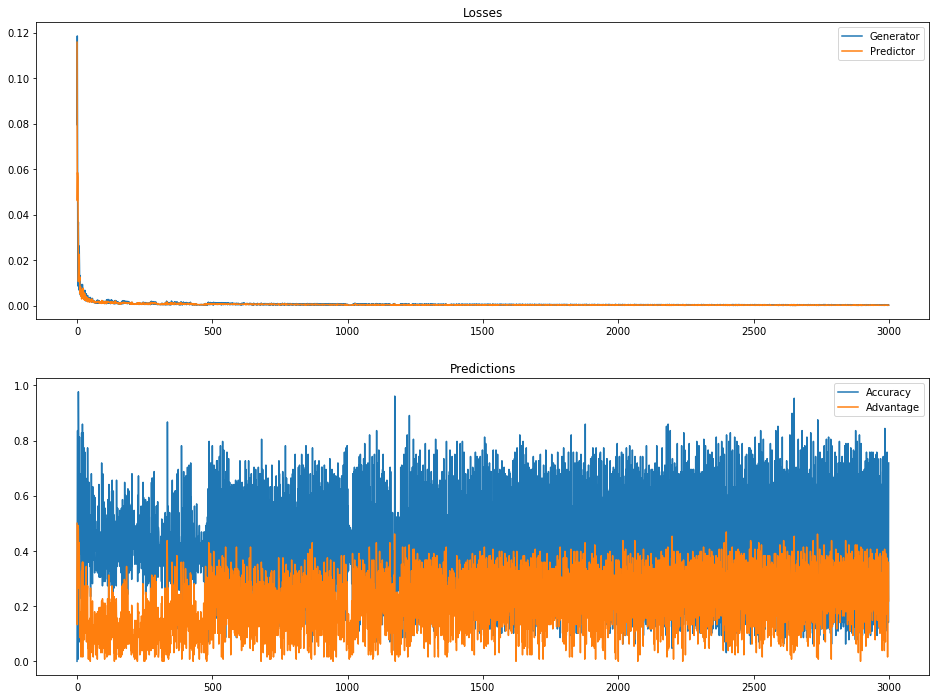

In [14]:
cprng_gan3.show_curves()

____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
sequence_input (InputLayer)                  (None, 112)                             0              
____________________________________________________________________________________________________
splitter (Lambda)                            [(None, 111), (None, 1)]                0              
____________________________________________________________________________________________________
dense_1 (Dense)                              (None, 30)                              3360           
____________________________________________________________________________________________________
leakyReLU_1 (LeakyReLU)                      (None, 30)                              0              
___________________________________________________________________________________________

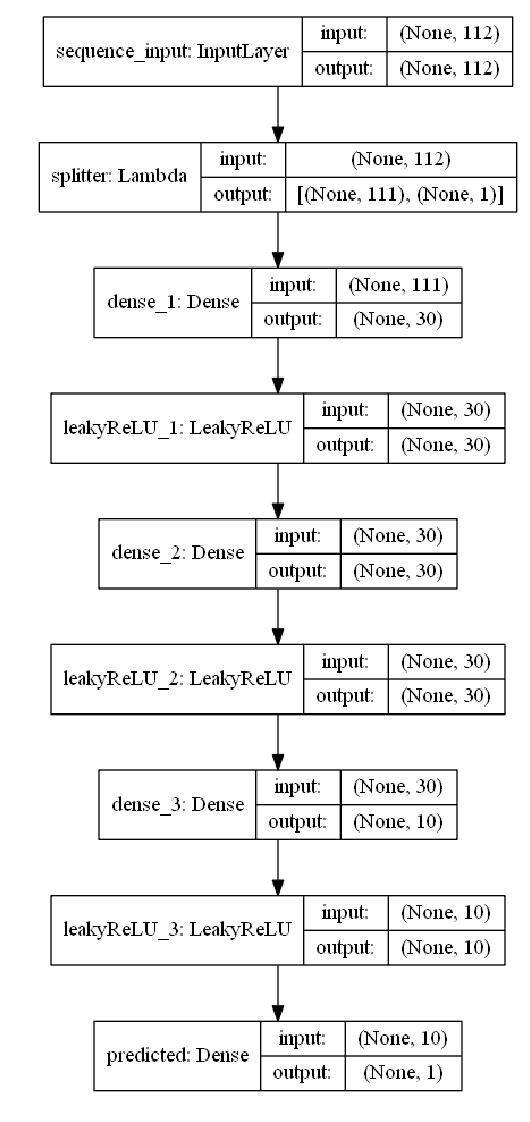

____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
g_dense_1 (Dense)                            (None, 30)                              990            
____________________________________________________________________________________________________
g_leakyReLU_1 (LeakyReLU)                    (None, 30)                              0              
____________________________________________________________________________________________________
g_dense_2 (Dense)                            (None, 30)                              930            
____________________________________________________________________________________________________
g_leakyReLU_2 (LeakyReLU)                    (None, 30)                              0              
___________________________________________________________________________________________

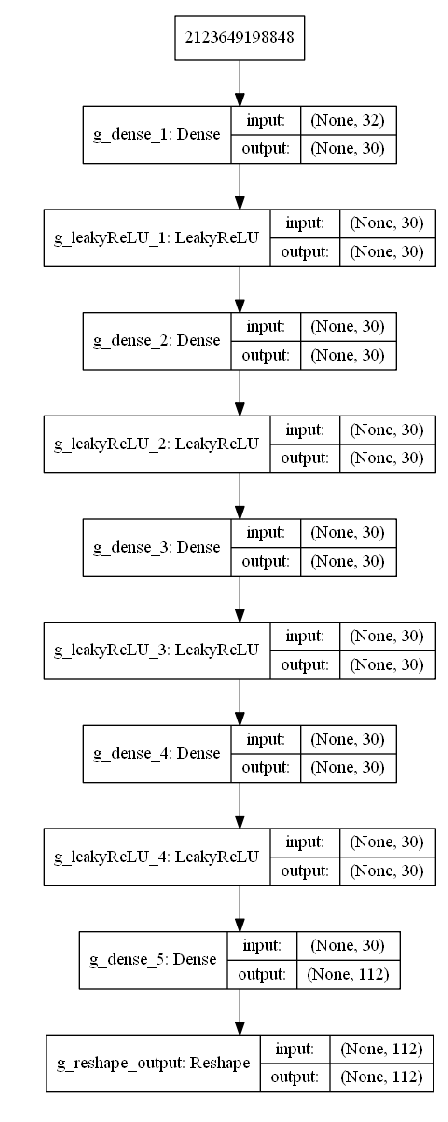

____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
latent_input (InputLayer)                    (None, 32)                              0              
____________________________________________________________________________________________________
generator (Model)                            (None, 112)                             7252           
____________________________________________________________________________________________________
predictor (Model)                            [(None, 1), (None, 1)]                  4611           
Total params: 11,863
Trainable params: 7,252
Non-trainable params: 4,611
____________________________________________________________________________________________________


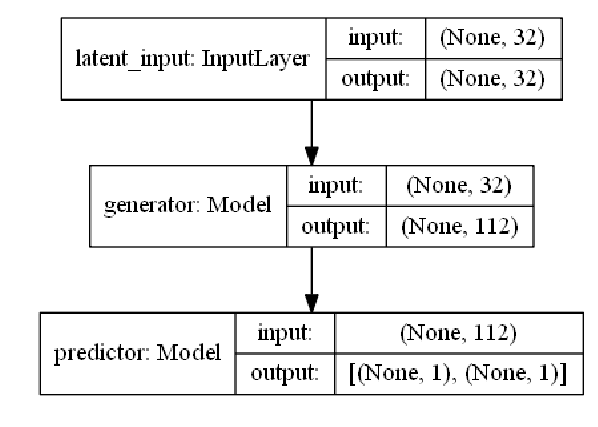

0 [P loss: 0.043840, acc.: 0.00%] [G loss: 0.051624]
[1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 0 1 1 1 1 0 1 1 1
 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1 0 0 1 1 0 1 1 1 0 0 0 1 0 0 1 0 1 1 1 0 1
 1 0 1 1 0 1 1 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1 0 1 1 1 1 1 1 1 0 0 0
 1]
[0 1 0 0 1 1 0 1 1 1 0 1 1 0 1 1 0 1 0 1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 1 1 0
 1 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 1 0 1 1 0 1 1 0 0 1 1 0 1 1 1 1
 0 1 1 1 1 1 0 0 1 1 1 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 1 1 0 1 1 1 0
 1]
[0 1 0 1 1 1 0 1 1 1 0 1 1 0 1 1 0 1 0 1 1 1 1 0 0 0 1 0 0 0 1 1 0 0 1 1 0
 1 1 0 1 1 1 1 0 0 0 0 0 1 0 1 0 0 1 1 1 0 1 1 1 1 0 1 1 0 0 0 0 0 1 1 1 1
 0 1 0 1 1 1 1 0 0 1 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 1 0 0 0 1 1 0 1 0 1 0
 1]
[1 1 0 0 1 0 1 0 1 1 0 1 0 0 0 1 1 1 1 1 1 0 1 0 0 1 0 1 0 0 0 1 0 0 1 0 0
 0 0 0 0 0 1 0 1 0 0 1 1 1 0 1 0 1 0 1 1 1 1 0 1 1 0 0 0 0 0 1 1 0 1 1 1 1
 1 0 1 0 0 1 0 0 1 1 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 0 1
 1]
[0 1 1 1 0 1 0 1 1 1 0 1 1 0 0 

109 [P loss: 0.001445, acc.: 50.78%] [G loss: 0.001408]
110 [P loss: 0.001465, acc.: 78.12%] [G loss: 0.003343]
111 [P loss: 0.001686, acc.: 67.19%] [G loss: 0.001997]
112 [P loss: 0.001457, acc.: 46.88%] [G loss: 0.001449]
113 [P loss: 0.001354, acc.: 80.47%] [G loss: 0.002753]
114 [P loss: 0.001319, acc.: 50.78%] [G loss: 0.001250]
115 [P loss: 0.001413, acc.: 39.84%] [G loss: 0.001171]
116 [P loss: 0.001541, acc.: 50.00%] [G loss: 0.001198]
117 [P loss: 0.001300, acc.: 67.19%] [G loss: 0.002281]
118 [P loss: 0.001572, acc.: 73.44%] [G loss: 0.002314]
119 [P loss: 0.001363, acc.: 53.12%] [G loss: 0.001388]
120 [P loss: 0.001472, acc.: 57.03%] [G loss: 0.001155]
121 [P loss: 0.001631, acc.: 81.25%] [G loss: 0.002277]
122 [P loss: 0.001180, acc.: 78.12%] [G loss: 0.002964]
123 [P loss: 0.001346, acc.: 64.84%] [G loss: 0.001684]
124 [P loss: 0.001430, acc.: 64.84%] [G loss: 0.001334]
125 [P loss: 0.001277, acc.: 49.22%] [G loss: 0.001738]
126 [P loss: 0.001720, acc.: 72.66%] [G loss: 0.

219 [P loss: 0.001128, acc.: 86.72%] [G loss: 0.002951]
220 [P loss: 0.001125, acc.: 46.88%] [G loss: 0.001196]
221 [P loss: 0.001023, acc.: 88.28%] [G loss: 0.001895]
222 [P loss: 0.000915, acc.: 60.16%] [G loss: 0.001415]
223 [P loss: 0.001139, acc.: 89.84%] [G loss: 0.003087]
224 [P loss: 0.000965, acc.: 55.47%] [G loss: 0.001133]
225 [P loss: 0.001264, acc.: 79.69%] [G loss: 0.002367]
226 [P loss: 0.001181, acc.: 43.75%] [G loss: 0.000899]
227 [P loss: 0.001031, acc.: 85.94%] [G loss: 0.002470]
228 [P loss: 0.001014, acc.: 53.91%] [G loss: 0.001245]
229 [P loss: 0.000930, acc.: 92.97%] [G loss: 0.003628]
230 [P loss: 0.001020, acc.: 64.06%] [G loss: 0.001004]
231 [P loss: 0.001093, acc.: 54.69%] [G loss: 0.001332]
232 [P loss: 0.001070, acc.: 63.28%] [G loss: 0.001219]
233 [P loss: 0.001192, acc.: 64.84%] [G loss: 0.001269]
234 [P loss: 0.001078, acc.: 58.59%] [G loss: 0.000915]
235 [P loss: 0.000938, acc.: 35.16%] [G loss: 0.001301]
236 [P loss: 0.000923, acc.: 84.38%] [G loss: 0.

367 [P loss: 0.000881, acc.: 65.62%] [G loss: 0.001003]
368 [P loss: 0.000848, acc.: 67.97%] [G loss: 0.000886]
369 [P loss: 0.000849, acc.: 49.22%] [G loss: 0.000808]
370 [P loss: 0.000793, acc.: 77.34%] [G loss: 0.001562]
371 [P loss: 0.000813, acc.: 49.22%] [G loss: 0.000680]
372 [P loss: 0.000877, acc.: 53.12%] [G loss: 0.001479]
373 [P loss: 0.000801, acc.: 69.53%] [G loss: 0.000880]
374 [P loss: 0.000853, acc.: 54.69%] [G loss: 0.000687]
375 [P loss: 0.000888, acc.: 64.06%] [G loss: 0.000939]
376 [P loss: 0.000810, acc.: 33.59%] [G loss: 0.001056]
377 [P loss: 0.000796, acc.: 85.16%] [G loss: 0.002403]
378 [P loss: 0.000890, acc.: 41.41%] [G loss: 0.000761]
379 [P loss: 0.000753, acc.: 65.62%] [G loss: 0.000996]
380 [P loss: 0.000920, acc.: 53.91%] [G loss: 0.000660]
381 [P loss: 0.000772, acc.: 77.34%] [G loss: 0.001456]
382 [P loss: 0.000954, acc.: 51.56%] [G loss: 0.000781]
383 [P loss: 0.000866, acc.: 81.25%] [G loss: 0.002030]
384 [P loss: 0.000673, acc.: 66.41%] [G loss: 0.

475 [P loss: 0.000793, acc.: 73.44%] [G loss: 0.000771]
476 [P loss: 0.000799, acc.: 57.03%] [G loss: 0.000814]
477 [P loss: 0.000801, acc.: 78.91%] [G loss: 0.001164]
478 [P loss: 0.000670, acc.: 60.16%] [G loss: 0.001073]
479 [P loss: 0.000771, acc.: 89.06%] [G loss: 0.001601]
480 [P loss: 0.000914, acc.: 33.59%] [G loss: 0.000791]
481 [P loss: 0.000713, acc.: 81.25%] [G loss: 0.001857]
482 [P loss: 0.000677, acc.: 63.28%] [G loss: 0.000757]
483 [P loss: 0.000906, acc.: 78.12%] [G loss: 0.001254]
484 [P loss: 0.001031, acc.: 42.19%] [G loss: 0.000990]
485 [P loss: 0.000716, acc.: 86.72%] [G loss: 0.002576]
486 [P loss: 0.000789, acc.: 54.69%] [G loss: 0.001387]
487 [P loss: 0.000780, acc.: 77.34%] [G loss: 0.001612]
488 [P loss: 0.000617, acc.: 57.81%] [G loss: 0.000722]
489 [P loss: 0.000796, acc.: 79.69%] [G loss: 0.001175]
490 [P loss: 0.000757, acc.: 45.31%] [G loss: 0.001000]
491 [P loss: 0.000824, acc.: 86.72%] [G loss: 0.001546]
492 [P loss: 0.000673, acc.: 38.28%] [G loss: 0.

604 [P loss: 0.000711, acc.: 59.38%] [G loss: 0.000560]
605 [P loss: 0.000591, acc.: 42.97%] [G loss: 0.000516]
606 [P loss: 0.000670, acc.: 50.00%] [G loss: 0.000542]
607 [P loss: 0.000579, acc.: 60.16%] [G loss: 0.000627]
608 [P loss: 0.000642, acc.: 61.72%] [G loss: 0.000586]
609 [P loss: 0.000609, acc.: 45.31%] [G loss: 0.000547]
610 [P loss: 0.000538, acc.: 42.19%] [G loss: 0.000718]
611 [P loss: 0.000690, acc.: 33.59%] [G loss: 0.000834]
612 [P loss: 0.000665, acc.: 43.75%] [G loss: 0.000755]
613 [P loss: 0.000627, acc.: 76.56%] [G loss: 0.000965]
614 [P loss: 0.000566, acc.: 62.50%] [G loss: 0.000572]
615 [P loss: 0.000675, acc.: 51.56%] [G loss: 0.000582]
616 [P loss: 0.000671, acc.: 65.62%] [G loss: 0.000595]
617 [P loss: 0.000751, acc.: 56.25%] [G loss: 0.000546]
618 [P loss: 0.000611, acc.: 45.31%] [G loss: 0.000574]
619 [P loss: 0.000600, acc.: 53.91%] [G loss: 0.000612]
620 [P loss: 0.000885, acc.: 77.34%] [G loss: 0.000536]
621 [P loss: 0.000847, acc.: 32.81%] [G loss: 0.

753 [P loss: 0.000614, acc.: 78.12%] [G loss: 0.000724]
754 [P loss: 0.000474, acc.: 60.94%] [G loss: 0.000600]
755 [P loss: 0.000725, acc.: 84.38%] [G loss: 0.000634]
756 [P loss: 0.000512, acc.: 67.19%] [G loss: 0.000566]
757 [P loss: 0.000513, acc.: 68.75%] [G loss: 0.000753]
758 [P loss: 0.000426, acc.: 66.41%] [G loss: 0.000477]
759 [P loss: 0.000555, acc.: 50.78%] [G loss: 0.000488]
760 [P loss: 0.000548, acc.: 59.38%] [G loss: 0.000494]
761 [P loss: 0.000441, acc.: 48.44%] [G loss: 0.000385]
762 [P loss: 0.000576, acc.: 39.84%] [G loss: 0.000474]
763 [P loss: 0.000562, acc.: 75.00%] [G loss: 0.000456]
764 [P loss: 0.000499, acc.: 57.81%] [G loss: 0.000471]
765 [P loss: 0.000567, acc.: 35.94%] [G loss: 0.000514]
766 [P loss: 0.000507, acc.: 75.00%] [G loss: 0.000915]
767 [P loss: 0.000660, acc.: 57.81%] [G loss: 0.000520]
768 [P loss: 0.000593, acc.: 85.16%] [G loss: 0.001166]
769 [P loss: 0.000547, acc.: 71.09%] [G loss: 0.000783]
770 [P loss: 0.000602, acc.: 78.91%] [G loss: 0.

861 [P loss: 0.000425, acc.: 83.59%] [G loss: 0.000728]
862 [P loss: 0.000467, acc.: 53.12%] [G loss: 0.000481]
863 [P loss: 0.000556, acc.: 81.25%] [G loss: 0.000926]
864 [P loss: 0.000447, acc.: 59.38%] [G loss: 0.000583]
865 [P loss: 0.000530, acc.: 82.03%] [G loss: 0.001136]
866 [P loss: 0.000613, acc.: 43.75%] [G loss: 0.000610]
867 [P loss: 0.000511, acc.: 84.38%] [G loss: 0.001317]
868 [P loss: 0.000465, acc.: 36.72%] [G loss: 0.000544]
869 [P loss: 0.000470, acc.: 89.06%] [G loss: 0.001029]
870 [P loss: 0.000511, acc.: 36.72%] [G loss: 0.000846]
871 [P loss: 0.000598, acc.: 85.94%] [G loss: 0.001346]
872 [P loss: 0.000588, acc.: 29.69%] [G loss: 0.001039]
873 [P loss: 0.000480, acc.: 85.16%] [G loss: 0.000807]
874 [P loss: 0.000477, acc.: 57.03%] [G loss: 0.000764]
875 [P loss: 0.000419, acc.: 73.44%] [G loss: 0.000906]
876 [P loss: 0.000497, acc.: 56.25%] [G loss: 0.000423]
877 [P loss: 0.000432, acc.: 61.72%] [G loss: 0.000421]
878 [P loss: 0.000595, acc.: 36.72%] [G loss: 0.

1004 [P loss: 0.000447, acc.: 44.53%] [G loss: 0.000475]
1005 [P loss: 0.000372, acc.: 69.53%] [G loss: 0.000493]
1006 [P loss: 0.000396, acc.: 41.41%] [G loss: 0.000445]
1007 [P loss: 0.000505, acc.: 67.97%] [G loss: 0.000491]
1008 [P loss: 0.000403, acc.: 47.66%] [G loss: 0.000367]
1009 [P loss: 0.000557, acc.: 73.44%] [G loss: 0.000381]
1010 [P loss: 0.000378, acc.: 64.84%] [G loss: 0.000571]
1011 [P loss: 0.000382, acc.: 84.38%] [G loss: 0.000824]
1012 [P loss: 0.000421, acc.: 49.22%] [G loss: 0.000543]
1013 [P loss: 0.000502, acc.: 81.25%] [G loss: 0.000661]
1014 [P loss: 0.000368, acc.: 42.97%] [G loss: 0.000590]
1015 [P loss: 0.000456, acc.: 89.84%] [G loss: 0.001082]
1016 [P loss: 0.000426, acc.: 71.88%] [G loss: 0.000947]
1017 [P loss: 0.000501, acc.: 88.28%] [G loss: 0.001086]
1018 [P loss: 0.000402, acc.: 70.31%] [G loss: 0.000611]
1019 [P loss: 0.000348, acc.: 79.69%] [G loss: 0.000883]
1020 [P loss: 0.000657, acc.: 42.97%] [G loss: 0.000570]
1021 [P loss: 0.000397, acc.: 8

1150 [P loss: 0.000364, acc.: 57.81%] [G loss: 0.000301]
1151 [P loss: 0.000353, acc.: 66.41%] [G loss: 0.000573]
1152 [P loss: 0.000407, acc.: 64.84%] [G loss: 0.000427]
1153 [P loss: 0.000523, acc.: 88.28%] [G loss: 0.001169]
1154 [P loss: 0.000346, acc.: 85.94%] [G loss: 0.000968]
1155 [P loss: 0.000353, acc.: 80.47%] [G loss: 0.000543]
1156 [P loss: 0.000516, acc.: 28.91%] [G loss: 0.001200]
1157 [P loss: 0.000349, acc.: 84.38%] [G loss: 0.000855]
1158 [P loss: 0.000340, acc.: 64.84%] [G loss: 0.000545]
1159 [P loss: 0.000575, acc.: 82.81%] [G loss: 0.000641]
1160 [P loss: 0.000341, acc.: 68.75%] [G loss: 0.000395]
1161 [P loss: 0.000385, acc.: 90.62%] [G loss: 0.000546]
1162 [P loss: 0.000516, acc.: 69.53%] [G loss: 0.000417]
1163 [P loss: 0.000471, acc.: 61.72%] [G loss: 0.000345]
1164 [P loss: 0.000447, acc.: 70.31%] [G loss: 0.000404]
1165 [P loss: 0.000418, acc.: 61.72%] [G loss: 0.000386]
1166 [P loss: 0.000315, acc.: 77.34%] [G loss: 0.000638]
1167 [P loss: 0.000470, acc.: 5

1256 [P loss: 0.000452, acc.: 37.50%] [G loss: 0.000550]
1257 [P loss: 0.000366, acc.: 85.16%] [G loss: 0.001124]
1258 [P loss: 0.000378, acc.: 61.72%] [G loss: 0.000324]
1259 [P loss: 0.000388, acc.: 55.47%] [G loss: 0.000366]
1260 [P loss: 0.000333, acc.: 53.12%] [G loss: 0.000358]
1261 [P loss: 0.000472, acc.: 86.72%] [G loss: 0.000744]
1262 [P loss: 0.000357, acc.: 55.47%] [G loss: 0.000330]
1263 [P loss: 0.000408, acc.: 78.12%] [G loss: 0.000404]
1264 [P loss: 0.000324, acc.: 72.66%] [G loss: 0.000356]
1265 [P loss: 0.000350, acc.: 71.09%] [G loss: 0.000338]
1266 [P loss: 0.000377, acc.: 71.09%] [G loss: 0.000408]
1267 [P loss: 0.000401, acc.: 53.12%] [G loss: 0.000306]
1268 [P loss: 0.000301, acc.: 60.16%] [G loss: 0.000350]
1269 [P loss: 0.000339, acc.: 66.41%] [G loss: 0.000503]
1270 [P loss: 0.000326, acc.: 66.41%] [G loss: 0.000333]
1271 [P loss: 0.000337, acc.: 50.78%] [G loss: 0.000297]
1272 [P loss: 0.000316, acc.: 56.25%] [G loss: 0.000373]
1273 [P loss: 0.000340, acc.: 7

1402 [P loss: 0.000313, acc.: 85.16%] [G loss: 0.000978]
1403 [P loss: 0.000404, acc.: 54.69%] [G loss: 0.000282]
1404 [P loss: 0.000342, acc.: 86.72%] [G loss: 0.000648]
1405 [P loss: 0.000276, acc.: 57.03%] [G loss: 0.000282]
1406 [P loss: 0.000297, acc.: 46.88%] [G loss: 0.000275]
1407 [P loss: 0.000309, acc.: 46.09%] [G loss: 0.000475]
1408 [P loss: 0.000317, acc.: 78.91%] [G loss: 0.000606]
1409 [P loss: 0.000392, acc.: 48.44%] [G loss: 0.000350]
1410 [P loss: 0.000327, acc.: 92.97%] [G loss: 0.000913]
1411 [P loss: 0.000296, acc.: 39.06%] [G loss: 0.000327]
1412 [P loss: 0.000383, acc.: 80.47%] [G loss: 0.000422]
1413 [P loss: 0.000315, acc.: 64.84%] [G loss: 0.000309]
1414 [P loss: 0.000355, acc.: 64.84%] [G loss: 0.000272]
1415 [P loss: 0.000281, acc.: 93.75%] [G loss: 0.000742]
1416 [P loss: 0.000382, acc.: 43.75%] [G loss: 0.000326]
1417 [P loss: 0.000291, acc.: 95.31%] [G loss: 0.000776]
1418 [P loss: 0.000255, acc.: 57.81%] [G loss: 0.000563]
1419 [P loss: 0.000382, acc.: 9

1550 [P loss: 0.000329, acc.: 87.50%] [G loss: 0.000706]
1551 [P loss: 0.000378, acc.: 39.84%] [G loss: 0.000246]
1552 [P loss: 0.000292, acc.: 85.94%] [G loss: 0.000796]
1553 [P loss: 0.000281, acc.: 43.75%] [G loss: 0.000261]
1554 [P loss: 0.000322, acc.: 78.91%] [G loss: 0.000283]
1555 [P loss: 0.000234, acc.: 61.72%] [G loss: 0.000289]
1556 [P loss: 0.000302, acc.: 76.56%] [G loss: 0.000371]
1557 [P loss: 0.000272, acc.: 59.38%] [G loss: 0.000308]
1558 [P loss: 0.000304, acc.: 44.53%] [G loss: 0.000438]
1559 [P loss: 0.000482, acc.: 84.38%] [G loss: 0.001188]
1560 [P loss: 0.000287, acc.: 50.00%] [G loss: 0.000630]
1561 [P loss: 0.000218, acc.: 92.97%] [G loss: 0.001009]
1562 [P loss: 0.000320, acc.: 32.03%] [G loss: 0.000446]
1563 [P loss: 0.000271, acc.: 91.41%] [G loss: 0.000766]
1564 [P loss: 0.000270, acc.: 67.97%] [G loss: 0.000302]
1565 [P loss: 0.000261, acc.: 75.78%] [G loss: 0.000241]
1566 [P loss: 0.000237, acc.: 62.50%] [G loss: 0.000238]
1567 [P loss: 0.000299, acc.: 9

1654 [P loss: 0.000467, acc.: 89.84%] [G loss: 0.000514]
1655 [P loss: 0.003647, acc.: 78.12%] [G loss: 0.004469]
1656 [P loss: 0.000769, acc.: 99.22%] [G loss: 0.005764]
1657 [P loss: 0.006166, acc.: 0.00%] [G loss: 0.000366]
1658 [P loss: 0.001691, acc.: 98.44%] [G loss: 0.009574]
1659 [P loss: 0.004459, acc.: 99.22%] [G loss: 0.006075]
1660 [P loss: 0.002182, acc.: 100.00%] [G loss: 0.000557]
1661 [P loss: 0.003014, acc.: 0.00%] [G loss: 0.000966]
1662 [P loss: 0.001308, acc.: 2.34%] [G loss: 0.004466]
1663 [P loss: 0.003225, acc.: 46.88%] [G loss: 0.001812]
1664 [P loss: 0.000304, acc.: 99.22%] [G loss: 0.003715]
1665 [P loss: 0.000353, acc.: 97.66%] [G loss: 0.001641]
1666 [P loss: 0.001680, acc.: 23.44%] [G loss: 0.000615]
1667 [P loss: 0.000842, acc.: 12.50%] [G loss: 0.001897]
1668 [P loss: 0.000899, acc.: 86.72%] [G loss: 0.000324]
1669 [P loss: 0.000759, acc.: 26.56%] [G loss: 0.001972]
1670 [P loss: 0.000966, acc.: 81.25%] [G loss: 0.000454]
1671 [P loss: 0.000603, acc.: 33.

[1 1 0 0 1 1 0 1 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 1 1 0
 0 0 0 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 1 0 1 1 0 0 1 0 0 1 1 0 1
 0 1 1 0 0 1 1 0 1 1 1 0 0 0 1 0 0 1 0 0 1 0 0 1 1 0 1 0 0 1 1 0 0 1 0 1 0
 1]
[0 1 0 0 1 0 0 1 1 0 0 1 1 0 0 1 0 1 1 1 1 1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 0
 1 1 0 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 1 0 0 1 0 1 1 0 0 0 0 0 1 1 0 1 1 1 0
 0 1 0 1 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 1 0 1 1 1 1 1
 0]
[0 1 1 0 0 0 1 1 1 0 0 1 1 0 0 1 0 1 0 1 1 0 1 1 0 1 0 1 0 1 0 1 1 0 0 0 0
 0 0 0 0 1 1 1 0 0 1 1 1 0 0 1 0 1 0 1 0 0 0 0 1 1 0 0 0 0 1 1 1 1 1 1 0 1
 0 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0 0 1 0 1 0 1 0 1
 0]
[0 1 0 0 0 1 0 0 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 0 0 0 1 0 0 1 1 0 0 1 0 0
 0 1 0 0 1 1 1 1 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 1 1 1 0
 0 1 1 0 0 0 1 0 0 1 1 0 0 1 1 0 0 1 0 0 1 1 1 1 0 1 1 0 0 0 1 1 0 1 1 1 1
 1]
[1 1 0 0 0 1 1 1 1 0 0 1 1 0 0 1 1 1 1 0 0 1 0 0 0 1 0 1 0 1 0 0 1 0 0 1 1
 0 0 0 1 

1907 [P loss: 0.000335, acc.: 34.38%] [G loss: 0.000440]
1908 [P loss: 0.000389, acc.: 26.56%] [G loss: 0.000649]
1909 [P loss: 0.000344, acc.: 26.56%] [G loss: 0.000677]
1910 [P loss: 0.000254, acc.: 45.31%] [G loss: 0.000621]
1911 [P loss: 0.000306, acc.: 25.78%] [G loss: 0.000728]
1912 [P loss: 0.000262, acc.: 75.00%] [G loss: 0.000370]
1913 [P loss: 0.000390, acc.: 64.06%] [G loss: 0.000266]
1914 [P loss: 0.000273, acc.: 94.53%] [G loss: 0.000974]
1915 [P loss: 0.000373, acc.: 88.28%] [G loss: 0.000330]
1916 [P loss: 0.000250, acc.: 75.00%] [G loss: 0.000501]
1917 [P loss: 0.000364, acc.: 43.75%] [G loss: 0.000435]
1918 [P loss: 0.000298, acc.: 96.88%] [G loss: 0.000837]
1919 [P loss: 0.000428, acc.: 89.06%] [G loss: 0.000375]
1920 [P loss: 0.000290, acc.: 82.03%] [G loss: 0.000340]
1921 [P loss: 0.000238, acc.: 70.31%] [G loss: 0.000207]
1922 [P loss: 0.000407, acc.: 50.00%] [G loss: 0.000500]
1923 [P loss: 0.000410, acc.: 82.03%] [G loss: 0.001325]
1924 [P loss: 0.000298, acc.: 3

2013 [P loss: 0.000262, acc.: 33.59%] [G loss: 0.000501]
2014 [P loss: 0.000319, acc.: 25.00%] [G loss: 0.000712]
2015 [P loss: 0.000532, acc.: 21.88%] [G loss: 0.000530]
2016 [P loss: 0.000277, acc.: 62.50%] [G loss: 0.000193]
2017 [P loss: 0.000235, acc.: 87.50%] [G loss: 0.000608]
2018 [P loss: 0.000372, acc.: 67.19%] [G loss: 0.000178]
2019 [P loss: 0.000347, acc.: 92.97%] [G loss: 0.000560]
2020 [P loss: 0.000264, acc.: 62.50%] [G loss: 0.000237]
2021 [P loss: 0.000242, acc.: 82.81%] [G loss: 0.000460]
2022 [P loss: 0.000299, acc.: 35.94%] [G loss: 0.000482]
2023 [P loss: 0.000718, acc.: 5.47%] [G loss: 0.000752]
2024 [P loss: 0.000221, acc.: 87.50%] [G loss: 0.000456]
2025 [P loss: 0.000274, acc.: 35.16%] [G loss: 0.001093]
2026 [P loss: 0.000585, acc.: 50.78%] [G loss: 0.000202]
2027 [P loss: 0.000253, acc.: 58.59%] [G loss: 0.000219]
2028 [P loss: 0.000271, acc.: 75.00%] [G loss: 0.000318]
2029 [P loss: 0.000269, acc.: 71.88%] [G loss: 0.000176]
2030 [P loss: 0.000258, acc.: 78

2161 [P loss: 0.000236, acc.: 36.72%] [G loss: 0.000542]
2162 [P loss: 0.000201, acc.: 84.38%] [G loss: 0.000347]
2163 [P loss: 0.000271, acc.: 60.16%] [G loss: 0.000224]
2164 [P loss: 0.000212, acc.: 46.09%] [G loss: 0.000210]
2165 [P loss: 0.000257, acc.: 91.41%] [G loss: 0.000392]
2166 [P loss: 0.000276, acc.: 59.38%] [G loss: 0.000253]
2167 [P loss: 0.000237, acc.: 92.19%] [G loss: 0.000836]
2168 [P loss: 0.000309, acc.: 22.66%] [G loss: 0.000524]
2169 [P loss: 0.000273, acc.: 91.41%] [G loss: 0.000664]
2170 [P loss: 0.000354, acc.: 75.78%] [G loss: 0.000273]
2171 [P loss: 0.000195, acc.: 83.59%] [G loss: 0.000800]
2172 [P loss: 0.000279, acc.: 47.66%] [G loss: 0.000232]
2173 [P loss: 0.000225, acc.: 89.06%] [G loss: 0.000364]
2174 [P loss: 0.000175, acc.: 82.03%] [G loss: 0.000337]
2175 [P loss: 0.000288, acc.: 93.75%] [G loss: 0.000418]
2176 [P loss: 0.000193, acc.: 80.47%] [G loss: 0.000464]
2177 [P loss: 0.000164, acc.: 95.31%] [G loss: 0.000699]
2178 [P loss: 0.000188, acc.: 5

2269 [P loss: 0.000212, acc.: 74.22%] [G loss: 0.000251]
2270 [P loss: 0.000207, acc.: 85.94%] [G loss: 0.000681]
2271 [P loss: 0.000212, acc.: 53.12%] [G loss: 0.000194]
2272 [P loss: 0.000177, acc.: 92.97%] [G loss: 0.000630]
2273 [P loss: 0.000198, acc.: 69.53%] [G loss: 0.000247]
2274 [P loss: 0.000293, acc.: 92.97%] [G loss: 0.000544]
2275 [P loss: 0.000209, acc.: 76.56%] [G loss: 0.000195]
2276 [P loss: 0.000291, acc.: 35.94%] [G loss: 0.000284]
2277 [P loss: 0.000235, acc.: 81.25%] [G loss: 0.000259]
2278 [P loss: 0.000316, acc.: 50.78%] [G loss: 0.000158]
2279 [P loss: 0.000202, acc.: 59.38%] [G loss: 0.000205]
2280 [P loss: 0.000230, acc.: 87.50%] [G loss: 0.000269]
2281 [P loss: 0.000238, acc.: 54.69%] [G loss: 0.000200]
2282 [P loss: 0.000198, acc.: 38.28%] [G loss: 0.000252]
2283 [P loss: 0.000179, acc.: 81.25%] [G loss: 0.000217]
2284 [P loss: 0.000228, acc.: 28.91%] [G loss: 0.000463]
2285 [P loss: 0.000399, acc.: 67.97%] [G loss: 0.000954]
2286 [P loss: 0.000314, acc.: 8

2404 [P loss: 0.000230, acc.: 44.53%] [G loss: 0.000255]
2405 [P loss: 0.000232, acc.: 93.75%] [G loss: 0.000660]
2406 [P loss: 0.000240, acc.: 82.81%] [G loss: 0.000240]
2407 [P loss: 0.000244, acc.: 78.12%] [G loss: 0.000239]
2408 [P loss: 0.000185, acc.: 60.16%] [G loss: 0.000182]
2409 [P loss: 0.000308, acc.: 85.16%] [G loss: 0.000212]
2410 [P loss: 0.000159, acc.: 49.22%] [G loss: 0.000264]
2411 [P loss: 0.000189, acc.: 92.97%] [G loss: 0.000492]
2412 [P loss: 0.000186, acc.: 73.44%] [G loss: 0.000168]
2413 [P loss: 0.000193, acc.: 85.94%] [G loss: 0.000371]
2414 [P loss: 0.000177, acc.: 49.22%] [G loss: 0.000443]
2415 [P loss: 0.000154, acc.: 91.41%] [G loss: 0.000424]
2416 [P loss: 0.000288, acc.: 57.81%] [G loss: 0.000150]
2417 [P loss: 0.000241, acc.: 26.56%] [G loss: 0.000442]
2418 [P loss: 0.000261, acc.: 82.81%] [G loss: 0.000229]
2419 [P loss: 0.000182, acc.: 67.97%] [G loss: 0.000164]
2420 [P loss: 0.000261, acc.: 81.25%] [G loss: 0.000336]
2421 [P loss: 0.000231, acc.: 6

2551 [P loss: 0.000162, acc.: 55.47%] [G loss: 0.000168]
2552 [P loss: 0.000248, acc.: 76.56%] [G loss: 0.000218]
2553 [P loss: 0.000235, acc.: 58.59%] [G loss: 0.000149]
2554 [P loss: 0.000165, acc.: 50.78%] [G loss: 0.000150]
2555 [P loss: 0.000241, acc.: 63.28%] [G loss: 0.000170]
2556 [P loss: 0.000197, acc.: 89.06%] [G loss: 0.000281]
2557 [P loss: 0.000248, acc.: 63.28%] [G loss: 0.000139]
2558 [P loss: 0.000184, acc.: 92.97%] [G loss: 0.000568]
2559 [P loss: 0.000203, acc.: 48.44%] [G loss: 0.000152]
2560 [P loss: 0.000176, acc.: 86.72%] [G loss: 0.000413]
2561 [P loss: 0.000160, acc.: 56.25%] [G loss: 0.000240]
2562 [P loss: 0.000181, acc.: 74.22%] [G loss: 0.000180]
2563 [P loss: 0.000186, acc.: 50.78%] [G loss: 0.000198]
2564 [P loss: 0.000170, acc.: 94.53%] [G loss: 0.000309]
2565 [P loss: 0.000150, acc.: 50.78%] [G loss: 0.000182]
2566 [P loss: 0.000190, acc.: 89.84%] [G loss: 0.000471]
2567 [P loss: 0.000155, acc.: 61.72%] [G loss: 0.000186]
2568 [P loss: 0.000197, acc.: 9

2657 [P loss: 0.002186, acc.: 96.88%] [G loss: 0.000733]
2658 [P loss: 0.001483, acc.: 3.12%] [G loss: 0.001661]
2659 [P loss: 0.000966, acc.: 58.59%] [G loss: 0.001159]
2660 [P loss: 0.001288, acc.: 14.06%] [G loss: 0.001157]
2661 [P loss: 0.000861, acc.: 24.22%] [G loss: 0.001307]
2662 [P loss: 0.001264, acc.: 25.78%] [G loss: 0.000793]
2663 [P loss: 0.000784, acc.: 30.47%] [G loss: 0.001244]
2664 [P loss: 0.000943, acc.: 25.00%] [G loss: 0.000992]
2665 [P loss: 0.000866, acc.: 21.88%] [G loss: 0.001081]
2666 [P loss: 0.000974, acc.: 22.66%] [G loss: 0.000865]
2667 [P loss: 0.000712, acc.: 17.97%] [G loss: 0.001203]
2668 [P loss: 0.000481, acc.: 28.12%] [G loss: 0.001166]
2669 [P loss: 0.000850, acc.: 28.12%] [G loss: 0.000943]
2670 [P loss: 0.000835, acc.: 28.12%] [G loss: 0.000747]
2671 [P loss: 0.000579, acc.: 14.84%] [G loss: 0.001146]
2672 [P loss: 0.000561, acc.: 28.12%] [G loss: 0.001058]
2673 [P loss: 0.000461, acc.: 19.53%] [G loss: 0.001099]
2674 [P loss: 0.000850, acc.: 27

2805 [P loss: 0.000226, acc.: 92.97%] [G loss: 0.000803]
2806 [P loss: 0.000217, acc.: 39.84%] [G loss: 0.000529]
2807 [P loss: 0.000188, acc.: 99.22%] [G loss: 0.001114]
2808 [P loss: 0.000277, acc.: 94.53%] [G loss: 0.000589]
2809 [P loss: 0.000379, acc.: 57.81%] [G loss: 0.000205]
2810 [P loss: 0.000218, acc.: 97.66%] [G loss: 0.000918]
2811 [P loss: 0.000223, acc.: 96.88%] [G loss: 0.000378]
2812 [P loss: 0.000241, acc.: 33.59%] [G loss: 0.000320]
2813 [P loss: 0.000223, acc.: 39.06%] [G loss: 0.000199]
2814 [P loss: 0.000237, acc.: 30.47%] [G loss: 0.000470]
2815 [P loss: 0.000212, acc.: 42.97%] [G loss: 0.000511]
2816 [P loss: 0.000228, acc.: 67.97%] [G loss: 0.000158]
2817 [P loss: 0.000267, acc.: 78.91%] [G loss: 0.000758]
2818 [P loss: 0.000318, acc.: 39.06%] [G loss: 0.000409]
2819 [P loss: 0.000261, acc.: 97.66%] [G loss: 0.000622]
2820 [P loss: 0.000217, acc.: 92.19%] [G loss: 0.000281]
2821 [P loss: 0.000277, acc.: 32.03%] [G loss: 0.000520]
2822 [P loss: 0.000211, acc.: 3

2953 [P loss: 0.000343, acc.: 53.12%] [G loss: 0.000172]
2954 [P loss: 0.000216, acc.: 58.59%] [G loss: 0.000528]
2955 [P loss: 0.000171, acc.: 61.72%] [G loss: 0.000145]
2956 [P loss: 0.000241, acc.: 36.72%] [G loss: 0.000446]
2957 [P loss: 0.000204, acc.: 93.75%] [G loss: 0.000833]
2958 [P loss: 0.000252, acc.: 28.12%] [G loss: 0.000567]
2959 [P loss: 0.000197, acc.: 95.31%] [G loss: 0.000443]
2960 [P loss: 0.000199, acc.: 85.94%] [G loss: 0.000204]
2961 [P loss: 0.000244, acc.: 40.62%] [G loss: 0.000486]
2962 [P loss: 0.000191, acc.: 55.47%] [G loss: 0.000131]
2963 [P loss: 0.000312, acc.: 42.19%] [G loss: 0.000169]
2964 [P loss: 0.000182, acc.: 76.56%] [G loss: 0.000567]
2965 [P loss: 0.000303, acc.: 25.78%] [G loss: 0.000468]
2966 [P loss: 0.000257, acc.: 78.91%] [G loss: 0.000192]
2967 [P loss: 0.000217, acc.: 35.94%] [G loss: 0.000259]
2968 [P loss: 0.000221, acc.: 86.72%] [G loss: 0.000624]
2969 [P loss: 0.000237, acc.: 46.09%] [G loss: 0.000241]
2970 [P loss: 0.000273, acc.: 9

In [16]:
cprng_gan4 = CPRNG_GAN(latent_dim=2 * 16, gen_width=7 * 16,
                     generator = [30, 30, 30, 30],
                     predictor = [30, 30, 10])
cprng_gan4.train(epochs=3000, batch_size=128, sample_interval=200, adv_multiplier = 5)

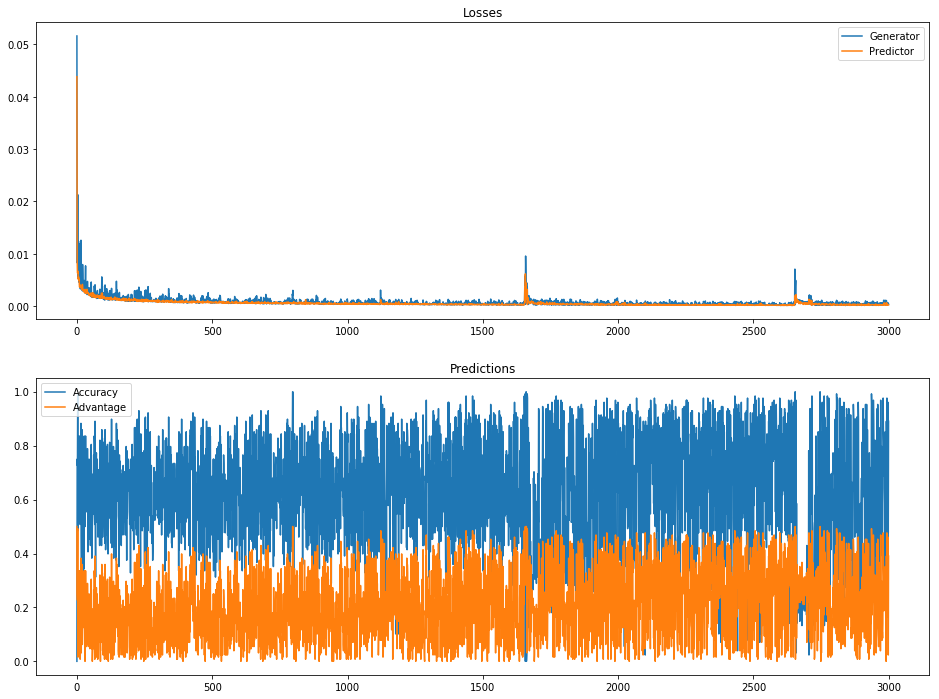

In [17]:
cprng_gan4.show_curves()

## 3. 임의 크기의 generator와 predictor에 대한 실험

사실 Bernardi et al. 의 논문에서 제안된 generator와 predictor의 크기는 여러 실험을 통해 찾아낸 절묘한 크기인 것 같습니다. 두 신경망의 크기를 다르게 설정하면 GAN의 학습 행동 양식은 완전히 변화합니다.

예를 들어 30차원 noise를 받아 길이 100인 binary sequence를 생성하는 상황을 가정하고, generator와 predictor를 매우 단순하게 주면...

____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
sequence_input (InputLayer)                  (None, 100)                             0              
____________________________________________________________________________________________________
splitter (Lambda)                            [(None, 99), (None, 1)]                 0              
____________________________________________________________________________________________________
dense_1 (Dense)                              (None, 10)                              1000           
____________________________________________________________________________________________________
leakyReLU_1 (LeakyReLU)                      (None, 10)                              0              
___________________________________________________________________________________________

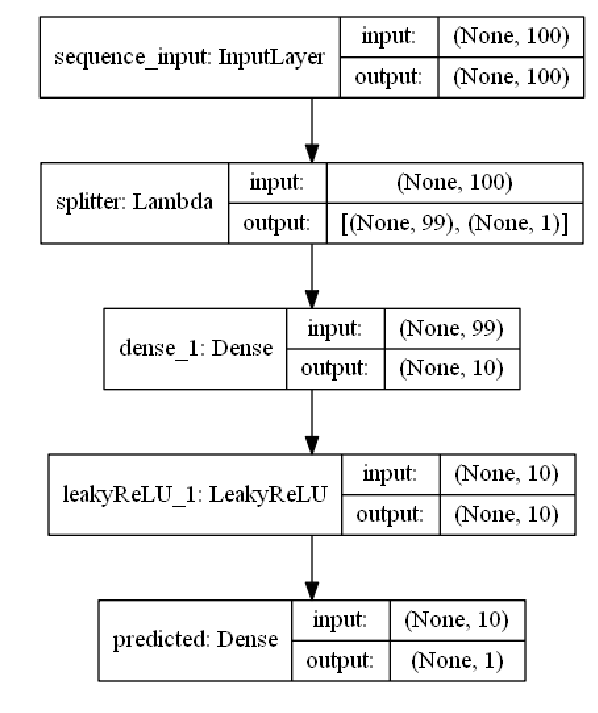

____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
g_dense_1 (Dense)                            (None, 100)                             3100           
____________________________________________________________________________________________________
g_leakyReLU_1 (LeakyReLU)                    (None, 100)                             0              
____________________________________________________________________________________________________
g_dense_2 (Dense)                            (None, 100)                             10100          
____________________________________________________________________________________________________
g_leakyReLU_2 (LeakyReLU)                    (None, 100)                             0              
___________________________________________________________________________________________

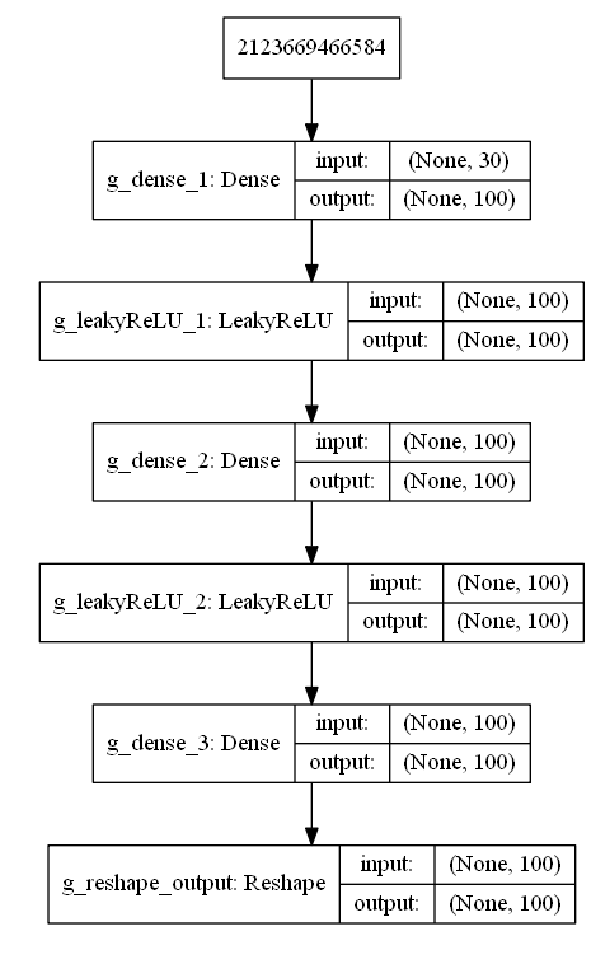

____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
latent_input (InputLayer)                    (None, 30)                              0              
____________________________________________________________________________________________________
generator (Model)                            (None, 100)                             23300          
____________________________________________________________________________________________________
predictor (Model)                            [(None, 1), (None, 1)]                  1011           
Total params: 24,311
Trainable params: 23,300
Non-trainable params: 1,011
____________________________________________________________________________________________________


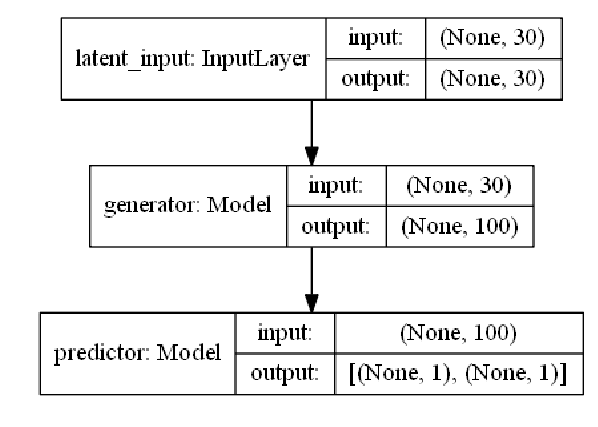

0 [P loss: 0.023452, acc.: 95.31%] [G loss: 0.081898]
[1 1 1 1 0 1 0 1 0 1 0 1 1 0 0 1 0 0 0 1 0 0 0 0 1 1 1 1 1 1 0 1 1 0 0 1 1
 1 1 1 0 0 1 1 0 1 1 0 1 1 1 0 1 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0
 0 0 0 0 1 1 1 0 1 0 0 1 0 0 0 1 0 0 1 1 0 1 0 1 1 1]
[0 1 0 1 0 1 0 0 1 1 0 0 1 0 0 0 1 1 0 1 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 1 0
 1 0 0 1 0 1 0 0 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0 0 1 0 0
 0 0 0 1 1 1 0 1 1 0 0 1 0 0 0 1 0 0 1 0 0 1 1 0 0 0]
[1 0 0 1 0 1 0 0 1 1 0 1 0 1 0 0 0 0 1 1 1 0 1 1 1 0 0 1 1 0 1 0 1 0 1 1 0
 1 0 1 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 0 1 0 1 0 1 0
 0 1 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
[1 1 1 1 1 1 0 1 1 0 0 1 1 0 0 1 0 0 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 1 0 0 0
 1 1 1 0 0 1 1 1 1 1 0 1 1 1 0 1 0 1 0 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 0 0
 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 1 0 1 1 1]
[1 0 0 1 1 1 1 0 1 1 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 1 0 1 1 1 0 1 1
 0 0 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 0 0 0 0 0 1 1 0 1 1 

119 [P loss: 0.014179, acc.: 28.12%] [G loss: 0.002552]
120 [P loss: 0.015186, acc.: 19.53%] [G loss: 0.003814]
121 [P loss: 0.015115, acc.: 39.06%] [G loss: 0.009820]
122 [P loss: 0.016085, acc.: 24.22%] [G loss: 0.002802]
123 [P loss: 0.014599, acc.: 19.53%] [G loss: 0.002049]
124 [P loss: 0.016429, acc.: 27.34%] [G loss: 0.005174]
125 [P loss: 0.014181, acc.: 35.94%] [G loss: 0.005901]
126 [P loss: 0.014188, acc.: 10.94%] [G loss: 0.002390]
127 [P loss: 0.014615, acc.: 10.94%] [G loss: 0.002942]
128 [P loss: 0.013323, acc.: 22.66%] [G loss: 0.006947]
129 [P loss: 0.015352, acc.: 16.41%] [G loss: 0.002968]
130 [P loss: 0.014425, acc.: 14.06%] [G loss: 0.003133]
131 [P loss: 0.014938, acc.: 10.16%] [G loss: 0.004223]
132 [P loss: 0.012785, acc.: 35.94%] [G loss: 0.004945]
133 [P loss: 0.017145, acc.: 19.53%] [G loss: 0.003065]
134 [P loss: 0.014608, acc.: 41.41%] [G loss: 0.009073]
135 [P loss: 0.013041, acc.: 14.06%] [G loss: 0.002273]
136 [P loss: 0.015010, acc.: 15.62%] [G loss: 0.

236 [P loss: 0.012965, acc.: 21.09%] [G loss: 0.002993]
237 [P loss: 0.012249, acc.: 20.31%] [G loss: 0.002409]
238 [P loss: 0.012042, acc.: 14.06%] [G loss: 0.004640]
239 [P loss: 0.010890, acc.: 20.31%] [G loss: 0.002048]
240 [P loss: 0.011410, acc.: 15.62%] [G loss: 0.002283]
241 [P loss: 0.011756, acc.: 6.25%] [G loss: 0.001801]
242 [P loss: 0.013454, acc.: 10.16%] [G loss: 0.001810]
243 [P loss: 0.013359, acc.: 9.38%] [G loss: 0.002818]
244 [P loss: 0.012440, acc.: 23.44%] [G loss: 0.001820]
245 [P loss: 0.013101, acc.: 17.19%] [G loss: 0.006130]
246 [P loss: 0.011023, acc.: 9.38%] [G loss: 0.002115]
247 [P loss: 0.013788, acc.: 7.81%] [G loss: 0.001852]
248 [P loss: 0.012970, acc.: 12.50%] [G loss: 0.003426]
249 [P loss: 0.012595, acc.: 33.59%] [G loss: 0.003622]
250 [P loss: 0.012160, acc.: 13.28%] [G loss: 0.003795]
251 [P loss: 0.013398, acc.: 55.47%] [G loss: 0.008915]
252 [P loss: 0.011971, acc.: 10.16%] [G loss: 0.003443]
253 [P loss: 0.011508, acc.: 27.34%] [G loss: 0.0029

390 [P loss: 0.011581, acc.: 27.34%] [G loss: 0.001684]
391 [P loss: 0.011364, acc.: 8.59%] [G loss: 0.003343]
392 [P loss: 0.010472, acc.: 40.62%] [G loss: 0.003432]
393 [P loss: 0.012728, acc.: 3.91%] [G loss: 0.001988]
394 [P loss: 0.010312, acc.: 18.75%] [G loss: 0.003405]
395 [P loss: 0.010337, acc.: 34.38%] [G loss: 0.003602]
396 [P loss: 0.010929, acc.: 17.97%] [G loss: 0.002061]
397 [P loss: 0.011759, acc.: 22.66%] [G loss: 0.006554]
398 [P loss: 0.012739, acc.: 39.06%] [G loss: 0.002901]
399 [P loss: 0.012701, acc.: 50.78%] [G loss: 0.005250]
400 [P loss: 0.010670, acc.: 12.50%] [G loss: 0.001485]
[1 0 1 1 1 1 1 0 1 1 0 1 1 0 1 1 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 1 1 0 1 0
 0 1 1 1 0 1 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 0 1 0 1 1
 1 1 0 1 1 0 1 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 1]
[1 1 0 0 1 1 0 1 1 1 0 1 1 0 0 0 0 1 0 1 0 0 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1
 1 1 1 0 0 1 0 0 1 0 1 1 0 0 1 1 1 0 0 0 0 0 1 0 0 1 1 1 0 1 0 1 0 1 0 0 0
 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 1

506 [P loss: 0.010901, acc.: 9.38%] [G loss: 0.004652]
507 [P loss: 0.010703, acc.: 37.50%] [G loss: 0.005024]
508 [P loss: 0.011109, acc.: 8.59%] [G loss: 0.001313]
509 [P loss: 0.009887, acc.: 13.28%] [G loss: 0.001556]
510 [P loss: 0.010818, acc.: 4.69%] [G loss: 0.001208]
511 [P loss: 0.010835, acc.: 15.62%] [G loss: 0.001748]
512 [P loss: 0.011050, acc.: 26.56%] [G loss: 0.001443]
513 [P loss: 0.010138, acc.: 10.94%] [G loss: 0.001887]
514 [P loss: 0.010307, acc.: 33.59%] [G loss: 0.003117]
515 [P loss: 0.009939, acc.: 12.50%] [G loss: 0.001199]
516 [P loss: 0.010091, acc.: 10.16%] [G loss: 0.002691]
517 [P loss: 0.009684, acc.: 24.22%] [G loss: 0.003818]
518 [P loss: 0.010775, acc.: 14.84%] [G loss: 0.001359]
519 [P loss: 0.011013, acc.: 13.28%] [G loss: 0.001363]
520 [P loss: 0.009600, acc.: 30.47%] [G loss: 0.001377]
521 [P loss: 0.010452, acc.: 13.28%] [G loss: 0.001654]
522 [P loss: 0.010057, acc.: 11.72%] [G loss: 0.001401]
523 [P loss: 0.010746, acc.: 17.19%] [G loss: 0.001

625 [P loss: 0.009052, acc.: 19.53%] [G loss: 0.002991]
626 [P loss: 0.010132, acc.: 7.81%] [G loss: 0.001265]
627 [P loss: 0.009442, acc.: 7.03%] [G loss: 0.001335]
628 [P loss: 0.009177, acc.: 18.75%] [G loss: 0.002029]
629 [P loss: 0.009875, acc.: 21.09%] [G loss: 0.001068]
630 [P loss: 0.010940, acc.: 42.97%] [G loss: 0.005565]
631 [P loss: 0.010790, acc.: 4.69%] [G loss: 0.001781]
632 [P loss: 0.009744, acc.: 10.94%] [G loss: 0.003364]
633 [P loss: 0.008224, acc.: 35.16%] [G loss: 0.001370]
634 [P loss: 0.010097, acc.: 17.19%] [G loss: 0.001510]
635 [P loss: 0.011289, acc.: 53.12%] [G loss: 0.005686]
636 [P loss: 0.008751, acc.: 32.81%] [G loss: 0.005165]
637 [P loss: 0.009168, acc.: 28.91%] [G loss: 0.003629]
638 [P loss: 0.010539, acc.: 14.84%] [G loss: 0.003378]
639 [P loss: 0.010082, acc.: 38.28%] [G loss: 0.006444]
640 [P loss: 0.011799, acc.: 8.59%] [G loss: 0.002002]
641 [P loss: 0.009445, acc.: 5.47%] [G loss: 0.002025]
642 [P loss: 0.010154, acc.: 10.16%] [G loss: 0.00213

779 [P loss: 0.009921, acc.: 31.25%] [G loss: 0.004028]
780 [P loss: 0.008319, acc.: 11.72%] [G loss: 0.002979]
781 [P loss: 0.008855, acc.: 29.69%] [G loss: 0.003148]
782 [P loss: 0.009745, acc.: 21.09%] [G loss: 0.001722]
783 [P loss: 0.009089, acc.: 20.31%] [G loss: 0.001436]
784 [P loss: 0.008510, acc.: 32.03%] [G loss: 0.005232]
785 [P loss: 0.009207, acc.: 27.34%] [G loss: 0.002805]
786 [P loss: 0.008802, acc.: 7.03%] [G loss: 0.002520]
787 [P loss: 0.007863, acc.: 14.84%] [G loss: 0.003459]
788 [P loss: 0.008814, acc.: 37.50%] [G loss: 0.005225]
789 [P loss: 0.009403, acc.: 10.16%] [G loss: 0.004307]
790 [P loss: 0.008736, acc.: 28.91%] [G loss: 0.003870]
791 [P loss: 0.008612, acc.: 10.16%] [G loss: 0.005324]
792 [P loss: 0.009465, acc.: 28.12%] [G loss: 0.003133]
793 [P loss: 0.009527, acc.: 7.03%] [G loss: 0.001883]
794 [P loss: 0.009494, acc.: 14.84%] [G loss: 0.003221]
795 [P loss: 0.010104, acc.: 14.06%] [G loss: 0.001285]
796 [P loss: 0.009665, acc.: 14.06%] [G loss: 0.00

899 [P loss: 0.008602, acc.: 16.41%] [G loss: 0.003253]
900 [P loss: 0.008912, acc.: 49.22%] [G loss: 0.007735]
901 [P loss: 0.008102, acc.: 7.81%] [G loss: 0.003223]
902 [P loss: 0.008452, acc.: 11.72%] [G loss: 0.001358]
903 [P loss: 0.008897, acc.: 10.16%] [G loss: 0.003615]
904 [P loss: 0.008253, acc.: 25.78%] [G loss: 0.006259]
905 [P loss: 0.009575, acc.: 25.00%] [G loss: 0.001358]
906 [P loss: 0.007682, acc.: 13.28%] [G loss: 0.001187]
907 [P loss: 0.009521, acc.: 22.66%] [G loss: 0.004132]
908 [P loss: 0.008593, acc.: 43.75%] [G loss: 0.001391]
909 [P loss: 0.008545, acc.: 22.66%] [G loss: 0.001527]
910 [P loss: 0.009472, acc.: 17.97%] [G loss: 0.001176]
911 [P loss: 0.008156, acc.: 14.84%] [G loss: 0.000948]
912 [P loss: 0.007820, acc.: 36.72%] [G loss: 0.003468]
913 [P loss: 0.008829, acc.: 14.84%] [G loss: 0.001349]
914 [P loss: 0.008300, acc.: 33.59%] [G loss: 0.001699]
915 [P loss: 0.008117, acc.: 13.28%] [G loss: 0.001227]
916 [P loss: 0.008231, acc.: 44.53%] [G loss: 0.0

1010 [P loss: 0.007865, acc.: 54.69%] [G loss: 0.006796]
1011 [P loss: 0.008548, acc.: 21.09%] [G loss: 0.005375]
1012 [P loss: 0.007408, acc.: 4.69%] [G loss: 0.001241]
1013 [P loss: 0.007735, acc.: 14.06%] [G loss: 0.001988]
1014 [P loss: 0.008667, acc.: 49.22%] [G loss: 0.003144]
1015 [P loss: 0.008748, acc.: 14.84%] [G loss: 0.005329]
1016 [P loss: 0.007991, acc.: 28.91%] [G loss: 0.002834]
1017 [P loss: 0.007701, acc.: 6.25%] [G loss: 0.003107]
1018 [P loss: 0.008488, acc.: 27.34%] [G loss: 0.002269]
1019 [P loss: 0.007903, acc.: 22.66%] [G loss: 0.001567]
1020 [P loss: 0.008061, acc.: 10.16%] [G loss: 0.001634]
1021 [P loss: 0.010002, acc.: 21.09%] [G loss: 0.001984]
1022 [P loss: 0.008208, acc.: 32.03%] [G loss: 0.007403]
1023 [P loss: 0.008126, acc.: 11.72%] [G loss: 0.001665]
1024 [P loss: 0.008989, acc.: 8.59%] [G loss: 0.001007]
1025 [P loss: 0.008632, acc.: 34.38%] [G loss: 0.002743]
1026 [P loss: 0.007298, acc.: 22.66%] [G loss: 0.001022]
1027 [P loss: 0.007646, acc.: 16.4

1159 [P loss: 0.007805, acc.: 50.00%] [G loss: 0.004377]
1160 [P loss: 0.008312, acc.: 28.91%] [G loss: 0.001016]
1161 [P loss: 0.008476, acc.: 8.59%] [G loss: 0.001160]
1162 [P loss: 0.008584, acc.: 47.66%] [G loss: 0.001527]
1163 [P loss: 0.006893, acc.: 7.81%] [G loss: 0.003553]
1164 [P loss: 0.007119, acc.: 53.12%] [G loss: 0.001589]
1165 [P loss: 0.007042, acc.: 36.72%] [G loss: 0.004973]
1166 [P loss: 0.006631, acc.: 16.41%] [G loss: 0.001270]
1167 [P loss: 0.006877, acc.: 9.38%] [G loss: 0.000852]
1168 [P loss: 0.007581, acc.: 30.47%] [G loss: 0.002632]
1169 [P loss: 0.007701, acc.: 25.00%] [G loss: 0.001722]
1170 [P loss: 0.008437, acc.: 18.75%] [G loss: 0.005304]
1171 [P loss: 0.007916, acc.: 70.31%] [G loss: 0.007999]
1172 [P loss: 0.007314, acc.: 12.50%] [G loss: 0.002118]
1173 [P loss: 0.006811, acc.: 19.53%] [G loss: 0.002397]
1174 [P loss: 0.007623, acc.: 17.19%] [G loss: 0.000917]
1175 [P loss: 0.007348, acc.: 21.88%] [G loss: 0.003600]
1176 [P loss: 0.008314, acc.: 29.6

1270 [P loss: 0.007027, acc.: 25.00%] [G loss: 0.001492]
1271 [P loss: 0.008912, acc.: 29.69%] [G loss: 0.000842]
1272 [P loss: 0.008902, acc.: 35.16%] [G loss: 0.001175]
1273 [P loss: 0.006645, acc.: 51.56%] [G loss: 0.004101]
1274 [P loss: 0.006628, acc.: 7.03%] [G loss: 0.001052]
1275 [P loss: 0.007510, acc.: 8.59%] [G loss: 0.001052]
1276 [P loss: 0.006776, acc.: 7.03%] [G loss: 0.001218]
1277 [P loss: 0.007096, acc.: 8.59%] [G loss: 0.001068]
1278 [P loss: 0.007771, acc.: 50.00%] [G loss: 0.001734]
1279 [P loss: 0.006853, acc.: 34.38%] [G loss: 0.001745]
1280 [P loss: 0.006525, acc.: 29.69%] [G loss: 0.001307]
1281 [P loss: 0.006501, acc.: 23.44%] [G loss: 0.004257]
1282 [P loss: 0.007056, acc.: 30.47%] [G loss: 0.000846]
1283 [P loss: 0.007655, acc.: 45.31%] [G loss: 0.002104]
1284 [P loss: 0.007418, acc.: 8.59%] [G loss: 0.003894]
1285 [P loss: 0.007500, acc.: 28.91%] [G loss: 0.000898]
1286 [P loss: 0.007812, acc.: 36.72%] [G loss: 0.003287]
1287 [P loss: 0.007316, acc.: 17.19%

1404 [P loss: 0.007700, acc.: 11.72%] [G loss: 0.003264]
1405 [P loss: 0.006641, acc.: 11.72%] [G loss: 0.002045]
1406 [P loss: 0.007157, acc.: 32.81%] [G loss: 0.003435]
1407 [P loss: 0.007703, acc.: 26.56%] [G loss: 0.001028]
1408 [P loss: 0.008296, acc.: 20.31%] [G loss: 0.004288]
1409 [P loss: 0.006419, acc.: 39.06%] [G loss: 0.002646]
1410 [P loss: 0.006795, acc.: 14.06%] [G loss: 0.001514]
1411 [P loss: 0.006792, acc.: 14.84%] [G loss: 0.003213]
1412 [P loss: 0.006162, acc.: 15.62%] [G loss: 0.000856]
1413 [P loss: 0.006169, acc.: 12.50%] [G loss: 0.001382]
1414 [P loss: 0.007089, acc.: 17.19%] [G loss: 0.002051]
1415 [P loss: 0.007548, acc.: 8.59%] [G loss: 0.000929]
1416 [P loss: 0.006726, acc.: 44.53%] [G loss: 0.001027]
1417 [P loss: 0.006832, acc.: 8.59%] [G loss: 0.001972]
1418 [P loss: 0.006841, acc.: 26.56%] [G loss: 0.003477]
1419 [P loss: 0.007243, acc.: 9.38%] [G loss: 0.002888]
1420 [P loss: 0.007817, acc.: 21.88%] [G loss: 0.003235]
1421 [P loss: 0.007769, acc.: 6.25

1554 [P loss: 0.007066, acc.: 65.62%] [G loss: 0.001351]
1555 [P loss: 0.007021, acc.: 42.97%] [G loss: 0.003834]
1556 [P loss: 0.006911, acc.: 21.09%] [G loss: 0.003677]
1557 [P loss: 0.007242, acc.: 25.78%] [G loss: 0.000881]
1558 [P loss: 0.006129, acc.: 9.38%] [G loss: 0.001695]
1559 [P loss: 0.007172, acc.: 10.94%] [G loss: 0.001012]
1560 [P loss: 0.006210, acc.: 25.00%] [G loss: 0.001564]
1561 [P loss: 0.006605, acc.: 27.34%] [G loss: 0.003799]
1562 [P loss: 0.006246, acc.: 7.81%] [G loss: 0.001514]
1563 [P loss: 0.007187, acc.: 26.56%] [G loss: 0.001006]
1564 [P loss: 0.006866, acc.: 11.72%] [G loss: 0.001278]
1565 [P loss: 0.007007, acc.: 26.56%] [G loss: 0.001200]
1566 [P loss: 0.006219, acc.: 14.06%] [G loss: 0.000856]
1567 [P loss: 0.006493, acc.: 13.28%] [G loss: 0.001025]
1568 [P loss: 0.006838, acc.: 14.84%] [G loss: 0.001126]
1569 [P loss: 0.007001, acc.: 29.69%] [G loss: 0.001240]
1570 [P loss: 0.006643, acc.: 14.06%] [G loss: 0.002964]
1571 [P loss: 0.006547, acc.: 36.

1667 [P loss: 0.006021, acc.: 16.41%] [G loss: 0.001297]
1668 [P loss: 0.005570, acc.: 33.59%] [G loss: 0.002019]
1669 [P loss: 0.006533, acc.: 4.69%] [G loss: 0.001186]
1670 [P loss: 0.007129, acc.: 13.28%] [G loss: 0.003358]
1671 [P loss: 0.006239, acc.: 6.25%] [G loss: 0.000843]
1672 [P loss: 0.007039, acc.: 13.28%] [G loss: 0.000941]
1673 [P loss: 0.005225, acc.: 23.44%] [G loss: 0.004063]
1674 [P loss: 0.007325, acc.: 33.59%] [G loss: 0.003047]
1675 [P loss: 0.006661, acc.: 32.03%] [G loss: 0.001236]
1676 [P loss: 0.007088, acc.: 46.09%] [G loss: 0.005981]
1677 [P loss: 0.006313, acc.: 67.97%] [G loss: 0.004214]
1678 [P loss: 0.006043, acc.: 23.44%] [G loss: 0.003972]
1679 [P loss: 0.005437, acc.: 35.16%] [G loss: 0.002183]
1680 [P loss: 0.005960, acc.: 23.44%] [G loss: 0.001510]
1681 [P loss: 0.006141, acc.: 42.97%] [G loss: 0.003205]
1682 [P loss: 0.006734, acc.: 8.59%] [G loss: 0.001092]
1683 [P loss: 0.004948, acc.: 24.22%] [G loss: 0.000887]
1684 [P loss: 0.005505, acc.: 19.5

1808 [P loss: 0.005158, acc.: 49.22%] [G loss: 0.001995]
1809 [P loss: 0.006712, acc.: 14.06%] [G loss: 0.000843]
1810 [P loss: 0.006563, acc.: 9.38%] [G loss: 0.001467]
1811 [P loss: 0.006408, acc.: 32.03%] [G loss: 0.004132]
1812 [P loss: 0.005326, acc.: 10.94%] [G loss: 0.001473]
1813 [P loss: 0.006241, acc.: 14.06%] [G loss: 0.000743]
1814 [P loss: 0.006176, acc.: 8.59%] [G loss: 0.001955]
1815 [P loss: 0.005670, acc.: 11.72%] [G loss: 0.000778]
1816 [P loss: 0.006145, acc.: 27.34%] [G loss: 0.000927]
1817 [P loss: 0.005878, acc.: 17.19%] [G loss: 0.001704]
1818 [P loss: 0.005960, acc.: 8.59%] [G loss: 0.000934]
1819 [P loss: 0.006370, acc.: 28.91%] [G loss: 0.002152]
1820 [P loss: 0.006032, acc.: 25.78%] [G loss: 0.000846]
1821 [P loss: 0.005789, acc.: 12.50%] [G loss: 0.001646]
1822 [P loss: 0.006240, acc.: 12.50%] [G loss: 0.001965]
1823 [P loss: 0.007150, acc.: 55.47%] [G loss: 0.003340]
1824 [P loss: 0.005840, acc.: 21.88%] [G loss: 0.003035]
1825 [P loss: 0.005226, acc.: 10.1

1955 [P loss: 0.006707, acc.: 64.84%] [G loss: 0.004661]
1956 [P loss: 0.005344, acc.: 35.94%] [G loss: 0.002615]
1957 [P loss: 0.005343, acc.: 14.06%] [G loss: 0.000772]
1958 [P loss: 0.005379, acc.: 21.88%] [G loss: 0.000917]
1959 [P loss: 0.005840, acc.: 7.03%] [G loss: 0.000779]
1960 [P loss: 0.005911, acc.: 7.81%] [G loss: 0.002963]
1961 [P loss: 0.006485, acc.: 32.81%] [G loss: 0.001731]
1962 [P loss: 0.005746, acc.: 18.75%] [G loss: 0.001152]
1963 [P loss: 0.005827, acc.: 5.47%] [G loss: 0.000742]
1964 [P loss: 0.005298, acc.: 45.31%] [G loss: 0.003780]
1965 [P loss: 0.005819, acc.: 12.50%] [G loss: 0.000825]
1966 [P loss: 0.005639, acc.: 16.41%] [G loss: 0.001351]
1967 [P loss: 0.006417, acc.: 33.59%] [G loss: 0.000944]
1968 [P loss: 0.006286, acc.: 69.53%] [G loss: 0.006476]
1969 [P loss: 0.005777, acc.: 44.53%] [G loss: 0.005463]
1970 [P loss: 0.005723, acc.: 7.81%] [G loss: 0.001031]
1971 [P loss: 0.005412, acc.: 10.16%] [G loss: 0.001199]
1972 [P loss: 0.005526, acc.: 10.16

2071 [P loss: 0.005856, acc.: 44.53%] [G loss: 0.000851]
2072 [P loss: 0.005318, acc.: 24.22%] [G loss: 0.001193]
2073 [P loss: 0.004992, acc.: 9.38%] [G loss: 0.003475]
2074 [P loss: 0.005719, acc.: 17.97%] [G loss: 0.000761]
2075 [P loss: 0.005472, acc.: 36.72%] [G loss: 0.002085]
2076 [P loss: 0.006319, acc.: 28.12%] [G loss: 0.003797]
2077 [P loss: 0.005678, acc.: 37.50%] [G loss: 0.001622]
2078 [P loss: 0.005108, acc.: 44.53%] [G loss: 0.001152]
2079 [P loss: 0.005958, acc.: 6.25%] [G loss: 0.000891]
2080 [P loss: 0.005610, acc.: 46.09%] [G loss: 0.000925]
2081 [P loss: 0.005642, acc.: 31.25%] [G loss: 0.003574]
2082 [P loss: 0.005470, acc.: 14.06%] [G loss: 0.000685]
2083 [P loss: 0.004926, acc.: 9.38%] [G loss: 0.000767]
2084 [P loss: 0.005390, acc.: 39.06%] [G loss: 0.003666]
2085 [P loss: 0.006259, acc.: 13.28%] [G loss: 0.002350]
2086 [P loss: 0.005327, acc.: 39.06%] [G loss: 0.000852]
2087 [P loss: 0.005833, acc.: 31.25%] [G loss: 0.001583]
2088 [P loss: 0.005918, acc.: 14.0

2205 [P loss: 0.005114, acc.: 38.28%] [G loss: 0.001841]
2206 [P loss: 0.005568, acc.: 33.59%] [G loss: 0.001368]
2207 [P loss: 0.005120, acc.: 14.06%] [G loss: 0.000930]
2208 [P loss: 0.004359, acc.: 25.00%] [G loss: 0.002840]
2209 [P loss: 0.005383, acc.: 30.47%] [G loss: 0.001708]
2210 [P loss: 0.005732, acc.: 23.44%] [G loss: 0.000722]
2211 [P loss: 0.005357, acc.: 10.94%] [G loss: 0.000714]
2212 [P loss: 0.005879, acc.: 9.38%] [G loss: 0.001870]
2213 [P loss: 0.004727, acc.: 14.84%] [G loss: 0.002423]
2214 [P loss: 0.005152, acc.: 28.91%] [G loss: 0.001216]
2215 [P loss: 0.005043, acc.: 44.53%] [G loss: 0.004038]
2216 [P loss: 0.005473, acc.: 13.28%] [G loss: 0.001592]
2217 [P loss: 0.005090, acc.: 14.84%] [G loss: 0.001183]
2218 [P loss: 0.005778, acc.: 9.38%] [G loss: 0.001394]
2219 [P loss: 0.005318, acc.: 23.44%] [G loss: 0.001378]
2220 [P loss: 0.005089, acc.: 28.91%] [G loss: 0.000898]
2221 [P loss: 0.004716, acc.: 19.53%] [G loss: 0.001191]
2222 [P loss: 0.005330, acc.: 27.

2350 [P loss: 0.005941, acc.: 39.06%] [G loss: 0.001908]
2351 [P loss: 0.005379, acc.: 64.06%] [G loss: 0.005469]
2352 [P loss: 0.004891, acc.: 55.47%] [G loss: 0.006327]
2353 [P loss: 0.005272, acc.: 22.66%] [G loss: 0.004407]
2354 [P loss: 0.005199, acc.: 37.50%] [G loss: 0.000747]
2355 [P loss: 0.004812, acc.: 35.94%] [G loss: 0.002689]
2356 [P loss: 0.005078, acc.: 19.53%] [G loss: 0.000733]
2357 [P loss: 0.004861, acc.: 14.06%] [G loss: 0.000760]
2358 [P loss: 0.005047, acc.: 35.94%] [G loss: 0.001978]
2359 [P loss: 0.005470, acc.: 38.28%] [G loss: 0.000723]
2360 [P loss: 0.005003, acc.: 47.66%] [G loss: 0.003501]
2361 [P loss: 0.004997, acc.: 14.06%] [G loss: 0.000751]
2362 [P loss: 0.004463, acc.: 12.50%] [G loss: 0.000629]
2363 [P loss: 0.005289, acc.: 42.19%] [G loss: 0.000777]
2364 [P loss: 0.005087, acc.: 49.22%] [G loss: 0.003086]
2365 [P loss: 0.005093, acc.: 3.91%] [G loss: 0.001100]
2366 [P loss: 0.004819, acc.: 7.81%] [G loss: 0.000686]
2367 [P loss: 0.005208, acc.: 19.

2461 [P loss: 0.004942, acc.: 46.88%] [G loss: 0.001171]
2462 [P loss: 0.004451, acc.: 21.88%] [G loss: 0.002614]
2463 [P loss: 0.004866, acc.: 28.91%] [G loss: 0.003558]
2464 [P loss: 0.005455, acc.: 64.84%] [G loss: 0.002822]
2465 [P loss: 0.005332, acc.: 24.22%] [G loss: 0.003646]
2466 [P loss: 0.005400, acc.: 2.34%] [G loss: 0.001846]
2467 [P loss: 0.004929, acc.: 53.12%] [G loss: 0.002450]
2468 [P loss: 0.004662, acc.: 25.78%] [G loss: 0.005032]
2469 [P loss: 0.005005, acc.: 30.47%] [G loss: 0.001104]
2470 [P loss: 0.005549, acc.: 19.53%] [G loss: 0.001439]
2471 [P loss: 0.005629, acc.: 53.91%] [G loss: 0.002797]
2472 [P loss: 0.004333, acc.: 25.00%] [G loss: 0.004793]
2473 [P loss: 0.005095, acc.: 29.69%] [G loss: 0.001080]
2474 [P loss: 0.004958, acc.: 60.94%] [G loss: 0.003904]
2475 [P loss: 0.004329, acc.: 43.75%] [G loss: 0.006909]
2476 [P loss: 0.005744, acc.: 26.56%] [G loss: 0.001126]
2477 [P loss: 0.004776, acc.: 32.03%] [G loss: 0.002346]
2478 [P loss: 0.004882, acc.: 13

2601 [P loss: 0.004578, acc.: 21.09%] [G loss: 0.001298]
2602 [P loss: 0.005525, acc.: 64.84%] [G loss: 0.002013]
2603 [P loss: 0.005733, acc.: 54.69%] [G loss: 0.002462]
2604 [P loss: 0.005072, acc.: 22.66%] [G loss: 0.003409]
2605 [P loss: 0.004437, acc.: 48.44%] [G loss: 0.000840]
2606 [P loss: 0.004508, acc.: 75.78%] [G loss: 0.004303]
2607 [P loss: 0.005252, acc.: 71.88%] [G loss: 0.005201]
2608 [P loss: 0.004845, acc.: 7.81%] [G loss: 0.003251]
2609 [P loss: 0.004887, acc.: 41.41%] [G loss: 0.000722]
2610 [P loss: 0.004378, acc.: 56.25%] [G loss: 0.001924]
2611 [P loss: 0.004730, acc.: 7.81%] [G loss: 0.002359]
2612 [P loss: 0.004313, acc.: 9.38%] [G loss: 0.002653]
2613 [P loss: 0.006101, acc.: 61.72%] [G loss: 0.002790]
2614 [P loss: 0.004627, acc.: 48.44%] [G loss: 0.004694]
2615 [P loss: 0.004550, acc.: 10.16%] [G loss: 0.000996]
2616 [P loss: 0.004642, acc.: 11.72%] [G loss: 0.000739]
2617 [P loss: 0.004745, acc.: 6.25%] [G loss: 0.002428]
2618 [P loss: 0.004971, acc.: 29.69

2753 [P loss: 0.004264, acc.: 50.78%] [G loss: 0.001478]
2754 [P loss: 0.004310, acc.: 8.59%] [G loss: 0.001567]
2755 [P loss: 0.004365, acc.: 41.41%] [G loss: 0.002441]
2756 [P loss: 0.004098, acc.: 17.19%] [G loss: 0.001639]
2757 [P loss: 0.004119, acc.: 19.53%] [G loss: 0.001610]
2758 [P loss: 0.004450, acc.: 15.62%] [G loss: 0.000786]
2759 [P loss: 0.004486, acc.: 7.81%] [G loss: 0.000705]
2760 [P loss: 0.004385, acc.: 17.19%] [G loss: 0.001016]
2761 [P loss: 0.004477, acc.: 29.69%] [G loss: 0.000831]
2762 [P loss: 0.004359, acc.: 21.88%] [G loss: 0.000733]
2763 [P loss: 0.004494, acc.: 21.88%] [G loss: 0.003921]
2764 [P loss: 0.004533, acc.: 45.31%] [G loss: 0.000673]
2765 [P loss: 0.004526, acc.: 50.00%] [G loss: 0.000880]
2766 [P loss: 0.004432, acc.: 32.03%] [G loss: 0.000659]
2767 [P loss: 0.004599, acc.: 12.50%] [G loss: 0.000688]
2768 [P loss: 0.004403, acc.: 17.97%] [G loss: 0.001755]
2769 [P loss: 0.004496, acc.: 36.72%] [G loss: 0.001239]
2770 [P loss: 0.004271, acc.: 7.8

2863 [P loss: 0.004266, acc.: 8.59%] [G loss: 0.000770]
2864 [P loss: 0.004209, acc.: 56.25%] [G loss: 0.002168]
2865 [P loss: 0.004885, acc.: 18.75%] [G loss: 0.003045]
2866 [P loss: 0.004036, acc.: 26.56%] [G loss: 0.001063]
2867 [P loss: 0.003560, acc.: 46.09%] [G loss: 0.002055]
2868 [P loss: 0.004356, acc.: 41.41%] [G loss: 0.000845]
2869 [P loss: 0.003964, acc.: 23.44%] [G loss: 0.001768]
2870 [P loss: 0.003998, acc.: 39.84%] [G loss: 0.001303]
2871 [P loss: 0.004430, acc.: 8.59%] [G loss: 0.001286]
2872 [P loss: 0.003855, acc.: 13.28%] [G loss: 0.000763]
2873 [P loss: 0.004054, acc.: 18.75%] [G loss: 0.000965]
2874 [P loss: 0.003994, acc.: 28.91%] [G loss: 0.001542]
2875 [P loss: 0.004131, acc.: 16.41%] [G loss: 0.001131]
2876 [P loss: 0.004174, acc.: 7.81%] [G loss: 0.000670]
2877 [P loss: 0.003916, acc.: 7.81%] [G loss: 0.001391]
2878 [P loss: 0.003975, acc.: 35.16%] [G loss: 0.000613]
2879 [P loss: 0.004071, acc.: 40.62%] [G loss: 0.002010]
2880 [P loss: 0.004486, acc.: 10.16

In [18]:
cprng_gan5 = CPRNG_GAN(latent_dim=30, gen_width=100,
                     generator = [100, 100],
                     predictor = [10])
cprng_gan5.train(epochs=3000, batch_size=128, sample_interval=200)

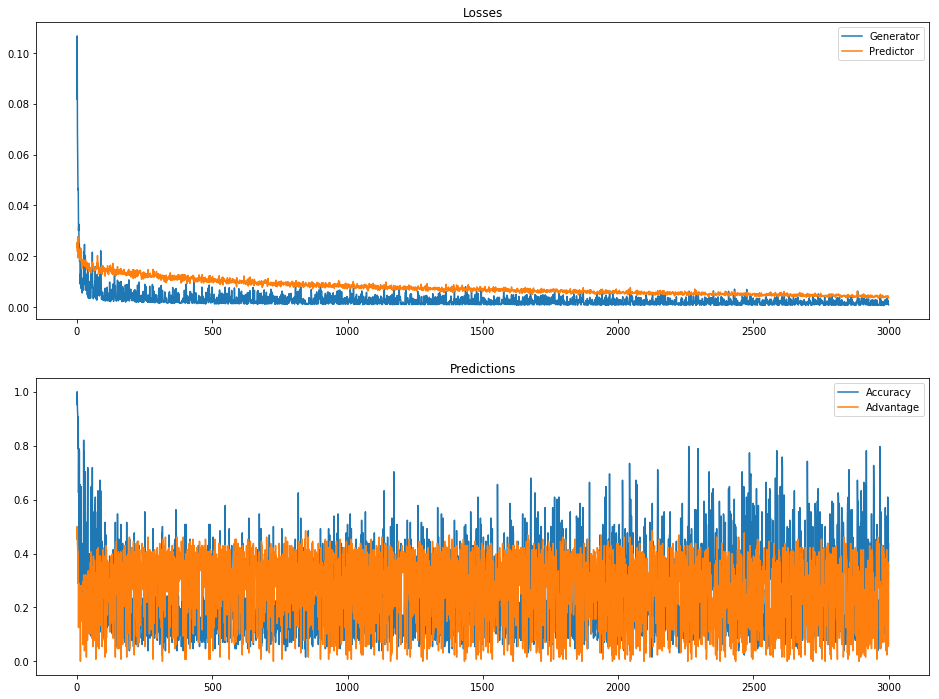

In [19]:
cprng_gan5.show_curves()

좀 더 극단적으로 간 경우입니다. predictor는 모든 걸 포기했습니다...

____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
sequence_input (InputLayer)                  (None, 1000)                            0              
____________________________________________________________________________________________________
splitter (Lambda)                            [(None, 999), (None, 1)]                0              
____________________________________________________________________________________________________
dense_1 (Dense)                              (None, 100)                             100000         
____________________________________________________________________________________________________
leakyReLU_1 (LeakyReLU)                      (None, 100)                             0              
___________________________________________________________________________________________

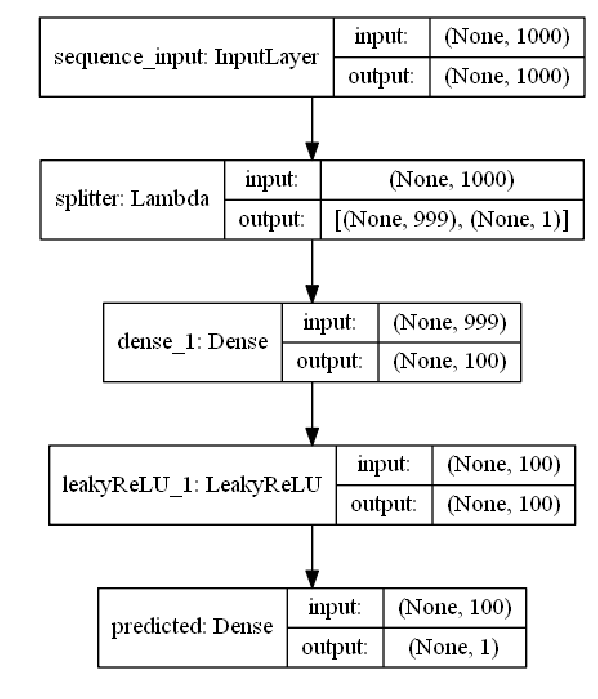

____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
g_dense_1 (Dense)                            (None, 100)                             30100          
____________________________________________________________________________________________________
g_leakyReLU_1 (LeakyReLU)                    (None, 100)                             0              
____________________________________________________________________________________________________
g_dense_2 (Dense)                            (None, 100)                             10100          
____________________________________________________________________________________________________
g_leakyReLU_2 (LeakyReLU)                    (None, 100)                             0              
___________________________________________________________________________________________

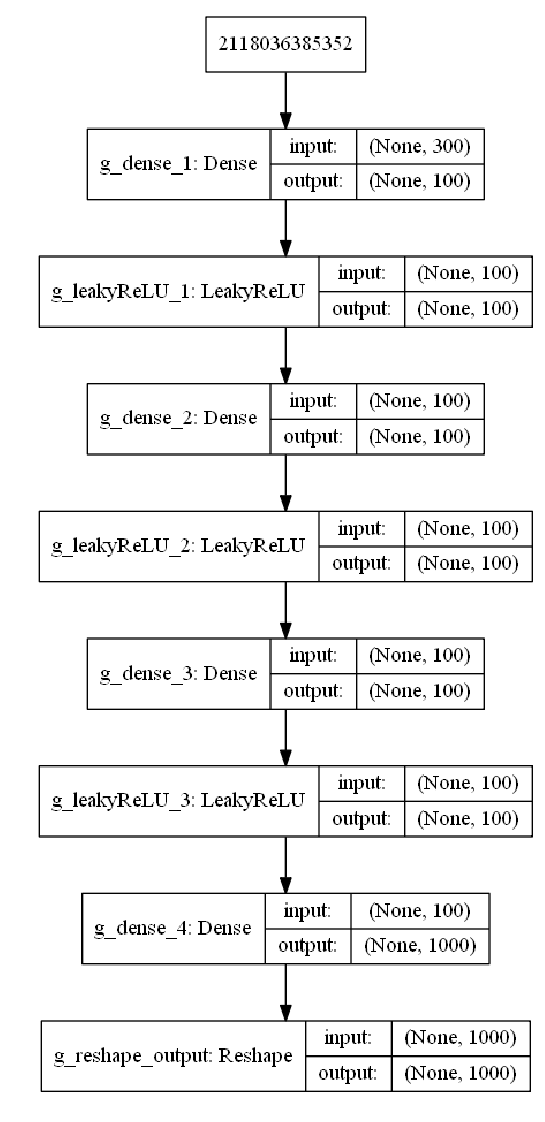

____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
latent_input (InputLayer)                    (None, 300)                             0              
____________________________________________________________________________________________________
generator (Model)                            (None, 1000)                            151300         
____________________________________________________________________________________________________
predictor (Model)                            [(None, 1), (None, 1)]                  100101         
Total params: 251,401
Trainable params: 151,300
Non-trainable params: 100,101
____________________________________________________________________________________________________


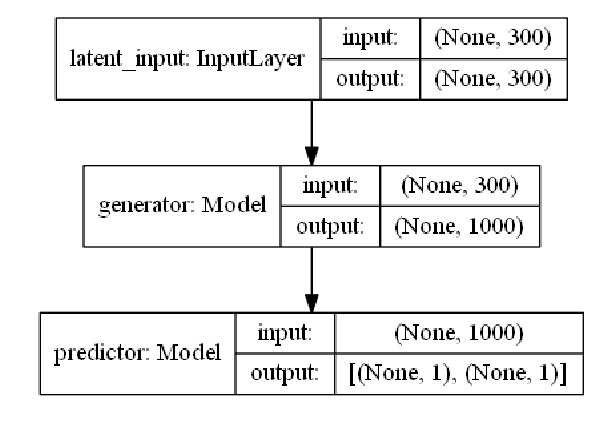

0 [P loss: 0.523320, acc.: 1.56%] [G loss: 0.479230]
[1 0 1 1 1 0 0 0 1 0 1 1 0 0 0 1 0 1 0 1 1 0 0 1 0 0 1 1 0 1 1 1 0 1 1 0 0
 0 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 1 0 1 0 1 1 0 0 1 1 0 1 1 0 1 0
 0 1 1 0 1 0 0 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 1 1 0 1 1
 1 0 0 0 1 0 1 0 0 1 1 1 1 1 0 1 1 0 1 0 0 0 1 0 1 1 0 1 1 1 1 1 0 1 0 0 1
 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 1 1 1 1 1 0 1 1 0 1 0 1 0 0 1 0 1 1 0 0 1 0
 0 0 1 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 1 1 1 0 1 0 0 0 1 1 0 1
 1 1 1 1 1 0 1 0 1 0 0 0 1 0 1 0 0 1 0 1 0 1 0 1 1 1 0 0 1 1 0 1 1 1 0 1 0
 0 0 1 0 0 1 1 1 0 0 0 0 0 1 0 0 1 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 1 1 0 1 1
 0 0 1 1 1 0 0 0 1 1 1 1 1 0 1 1 0 0 0 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1
 1 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 1 0 1 1 1 1 0 1 0 1
 1 1 1 0 0 0 0 1 1 1 0 0 1 0 0 1 0 1 1 1 1 1 0 0 1 0 1 0 0 1 1 0 0 0 1 0 1
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 1 1 1 0 1 0 0 1 0 1 1 0 0 1 1 1 0
 1 0 1 1 0 0 0 1 1 1 1 0 0 1 1 1 0 1 1 0 1 0 0 

6 [P loss: 0.999926, acc.: 0.00%] [G loss: 0.000073]
7 [P loss: 0.999950, acc.: 0.00%] [G loss: 0.000049]
8 [P loss: 0.999960, acc.: 0.00%] [G loss: 0.000040]
9 [P loss: 0.999964, acc.: 0.00%] [G loss: 0.000036]
10 [P loss: 0.999965, acc.: 0.00%] [G loss: 0.000032]
11 [P loss: 0.999967, acc.: 0.00%] [G loss: 0.000032]
12 [P loss: 0.999969, acc.: 0.00%] [G loss: 0.000034]
13 [P loss: 0.999968, acc.: 0.00%] [G loss: 0.000032]
14 [P loss: 0.999970, acc.: 0.00%] [G loss: 0.000030]
15 [P loss: 0.999971, acc.: 0.00%] [G loss: 0.000030]
16 [P loss: 0.999971, acc.: 0.00%] [G loss: 0.000029]
17 [P loss: 0.999969, acc.: 0.00%] [G loss: 0.000031]
18 [P loss: 0.999971, acc.: 0.00%] [G loss: 0.000029]
19 [P loss: 0.999970, acc.: 0.00%] [G loss: 0.000027]
20 [P loss: 0.999969, acc.: 0.00%] [G loss: 0.000031]
21 [P loss: 0.999971, acc.: 0.00%] [G loss: 0.000030]
22 [P loss: 0.999970, acc.: 0.00%] [G loss: 0.000029]
23 [P loss: 0.999971, acc.: 0.00%] [G loss: 0.000030]
24 [P loss: 0.999973, acc.: 0.00

159 [P loss: 0.999988, acc.: 0.00%] [G loss: 0.000012]
160 [P loss: 0.999988, acc.: 0.00%] [G loss: 0.000012]
161 [P loss: 0.999988, acc.: 0.00%] [G loss: 0.000013]
162 [P loss: 0.999988, acc.: 0.00%] [G loss: 0.000011]
163 [P loss: 0.999988, acc.: 0.00%] [G loss: 0.000012]
164 [P loss: 0.999989, acc.: 0.00%] [G loss: 0.000012]
165 [P loss: 0.999989, acc.: 0.00%] [G loss: 0.000011]
166 [P loss: 0.999988, acc.: 0.00%] [G loss: 0.000012]
167 [P loss: 0.999988, acc.: 0.00%] [G loss: 0.000011]
168 [P loss: 0.999989, acc.: 0.00%] [G loss: 0.000012]
169 [P loss: 0.999988, acc.: 0.00%] [G loss: 0.000012]
170 [P loss: 0.999989, acc.: 0.00%] [G loss: 0.000011]
171 [P loss: 0.999988, acc.: 0.00%] [G loss: 0.000011]
172 [P loss: 0.999989, acc.: 0.00%] [G loss: 0.000011]
173 [P loss: 0.999989, acc.: 0.00%] [G loss: 0.000012]
174 [P loss: 0.999988, acc.: 0.00%] [G loss: 0.000011]
175 [P loss: 0.999988, acc.: 0.00%] [G loss: 0.000011]
176 [P loss: 0.999988, acc.: 0.00%] [G loss: 0.000012]
177 [P los

207 [P loss: 0.999990, acc.: 0.00%] [G loss: 0.000010]
208 [P loss: 0.999990, acc.: 0.00%] [G loss: 0.000010]
209 [P loss: 0.999990, acc.: 0.00%] [G loss: 0.000010]
210 [P loss: 0.999990, acc.: 0.00%] [G loss: 0.000010]
211 [P loss: 0.999991, acc.: 0.00%] [G loss: 0.000010]
212 [P loss: 0.999990, acc.: 0.00%] [G loss: 0.000009]
213 [P loss: 0.999990, acc.: 0.00%] [G loss: 0.000010]
214 [P loss: 0.999990, acc.: 0.00%] [G loss: 0.000009]
215 [P loss: 0.999990, acc.: 0.00%] [G loss: 0.000010]
216 [P loss: 0.999990, acc.: 0.00%] [G loss: 0.000010]
217 [P loss: 0.999991, acc.: 0.00%] [G loss: 0.000009]
218 [P loss: 0.999990, acc.: 0.00%] [G loss: 0.000009]
219 [P loss: 0.999990, acc.: 0.00%] [G loss: 0.000009]
220 [P loss: 0.999991, acc.: 0.00%] [G loss: 0.000009]
221 [P loss: 0.999991, acc.: 0.00%] [G loss: 0.000009]
222 [P loss: 0.999990, acc.: 0.00%] [G loss: 0.000009]
223 [P loss: 0.999990, acc.: 0.00%] [G loss: 0.000009]
224 [P loss: 0.999992, acc.: 0.00%] [G loss: 0.000009]
225 [P los

360 [P loss: 0.999994, acc.: 0.00%] [G loss: 0.000006]
361 [P loss: 0.999994, acc.: 0.00%] [G loss: 0.000006]
362 [P loss: 0.999994, acc.: 0.00%] [G loss: 0.000006]
363 [P loss: 0.999994, acc.: 0.00%] [G loss: 0.000006]
364 [P loss: 0.999995, acc.: 0.00%] [G loss: 0.000006]
365 [P loss: 0.999994, acc.: 0.00%] [G loss: 0.000006]
366 [P loss: 0.999994, acc.: 0.00%] [G loss: 0.000006]
367 [P loss: 0.999994, acc.: 0.00%] [G loss: 0.000006]
368 [P loss: 0.999994, acc.: 0.00%] [G loss: 0.000005]
369 [P loss: 0.999995, acc.: 0.00%] [G loss: 0.000006]
370 [P loss: 0.999995, acc.: 0.00%] [G loss: 0.000006]
371 [P loss: 0.999995, acc.: 0.00%] [G loss: 0.000006]
372 [P loss: 0.999994, acc.: 0.00%] [G loss: 0.000006]
373 [P loss: 0.999994, acc.: 0.00%] [G loss: 0.000006]
374 [P loss: 0.999994, acc.: 0.00%] [G loss: 0.000006]
375 [P loss: 0.999995, acc.: 0.00%] [G loss: 0.000006]
376 [P loss: 0.999994, acc.: 0.00%] [G loss: 0.000005]
377 [P loss: 0.999995, acc.: 0.00%] [G loss: 0.000006]
378 [P los

[1 0 1 1 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0 1 1 0 1 0 0 1 1 0 1 1 1 1 0 1 1 1
 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 0 1 0 1 0 1 0 0 0 1 1 0 0 1 1 0 0
 1 0 1 0 0 1 0 1 1 0 1 1 1 1 1 0 1 0 0 0 0 1 0 1 1 1 0 0 0 1 1 1 1 1 1 0 1
 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 1 0 0 1 0 0 1 1 0 1 0 1 1 1 1 0 1 0 0 0 0 1
 1 0 0 1 0 0 1 1 1 0 1 0 0 0 1 1 1 0 0 1 0 0 1 0 1 1 1 0 1 0 1 1 1 0 1 1 0
 0 1 1 1 1 0 1 1 1 1 0 0 1 1 0 0 0 0 1 1 0 1 1 1 0 0 1 0 1 1 0 1 0 0 0 0 1
 1 1 1 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 1 1 0 0 0 0 1 1 1 1 0 1 1 1 1 0 0 1 0
 1 0 1 0 1 1 0 0 0 0 0 1 1 1 0 1 1 1 0 0 0 0 0 0 1 1 1 0 1 0 1 1 0 0 1 1 1
 0 1 0 0 1 1 1 0 1 0 1 0 0 1 1 0 0 0 1 0 0 1 0 0 1 0 1 0 1 0 0 1 1 0 1 0 1
 0 1 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 1
 1 1 1 0 0 0 1 0 0 1 0 0 0 0 1 1 1 0 1 1 1 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 1
 0 1 0 0 1 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 0 0 1 1 0
 1 0 0 1 0 0 1 1 0 0 0 1 0 1 0 1 0 1 1 0 1 1 1 1 1 1 0 1 0 0 0 0 0 1 0 0 0
 0 0 0 1 0 0 1 0 1 1 1 0 

407 [P loss: 0.999995, acc.: 0.00%] [G loss: 0.000005]
408 [P loss: 0.999995, acc.: 0.00%] [G loss: 0.000006]
409 [P loss: 0.999995, acc.: 0.00%] [G loss: 0.000005]
410 [P loss: 0.999995, acc.: 0.00%] [G loss: 0.000005]
411 [P loss: 0.999995, acc.: 0.00%] [G loss: 0.000005]
412 [P loss: 0.999995, acc.: 0.00%] [G loss: 0.000005]
413 [P loss: 0.999994, acc.: 0.00%] [G loss: 0.000005]
414 [P loss: 0.999995, acc.: 0.00%] [G loss: 0.000005]
415 [P loss: 0.999995, acc.: 0.00%] [G loss: 0.000005]
416 [P loss: 0.999995, acc.: 0.00%] [G loss: 0.000005]
417 [P loss: 0.999995, acc.: 0.00%] [G loss: 0.000005]
418 [P loss: 0.999994, acc.: 0.00%] [G loss: 0.000005]
419 [P loss: 0.999995, acc.: 0.00%] [G loss: 0.000005]
420 [P loss: 0.999995, acc.: 0.00%] [G loss: 0.000005]
421 [P loss: 0.999995, acc.: 0.00%] [G loss: 0.000005]
422 [P loss: 0.999995, acc.: 0.00%] [G loss: 0.000005]
423 [P loss: 0.999995, acc.: 0.00%] [G loss: 0.000005]
424 [P loss: 0.999995, acc.: 0.00%] [G loss: 0.000005]
425 [P los

561 [P loss: 0.999996, acc.: 0.00%] [G loss: 0.000003]
562 [P loss: 0.999996, acc.: 0.00%] [G loss: 0.000004]
563 [P loss: 0.999997, acc.: 0.00%] [G loss: 0.000004]
564 [P loss: 0.999996, acc.: 0.00%] [G loss: 0.000004]
565 [P loss: 0.999996, acc.: 0.00%] [G loss: 0.000004]
566 [P loss: 0.999996, acc.: 0.00%] [G loss: 0.000003]
567 [P loss: 0.999996, acc.: 0.00%] [G loss: 0.000004]
568 [P loss: 0.999996, acc.: 0.00%] [G loss: 0.000004]
569 [P loss: 0.999996, acc.: 0.00%] [G loss: 0.000004]
570 [P loss: 0.999996, acc.: 0.00%] [G loss: 0.000004]
571 [P loss: 0.999997, acc.: 0.00%] [G loss: 0.000004]
572 [P loss: 0.999997, acc.: 0.00%] [G loss: 0.000004]
573 [P loss: 0.999996, acc.: 0.00%] [G loss: 0.000004]
574 [P loss: 0.999997, acc.: 0.00%] [G loss: 0.000004]
575 [P loss: 0.999997, acc.: 0.00%] [G loss: 0.000003]
576 [P loss: 0.999996, acc.: 0.00%] [G loss: 0.000004]
577 [P loss: 0.999997, acc.: 0.00%] [G loss: 0.000004]
578 [P loss: 0.999996, acc.: 0.00%] [G loss: 0.000004]
579 [P los

602 [P loss: 0.999997, acc.: 0.00%] [G loss: 0.000003]
603 [P loss: 0.999997, acc.: 0.00%] [G loss: 0.000004]
604 [P loss: 0.999997, acc.: 0.00%] [G loss: 0.000003]
605 [P loss: 0.999997, acc.: 0.00%] [G loss: 0.000003]
606 [P loss: 0.999997, acc.: 0.00%] [G loss: 0.000004]
607 [P loss: 0.999997, acc.: 0.00%] [G loss: 0.000004]
608 [P loss: 0.999997, acc.: 0.00%] [G loss: 0.000003]
609 [P loss: 0.999996, acc.: 0.00%] [G loss: 0.000003]
610 [P loss: 0.999997, acc.: 0.00%] [G loss: 0.000003]
611 [P loss: 0.999997, acc.: 0.00%] [G loss: 0.000003]
612 [P loss: 0.999997, acc.: 0.00%] [G loss: 0.000003]
613 [P loss: 0.999997, acc.: 0.00%] [G loss: 0.000003]
614 [P loss: 0.999997, acc.: 0.00%] [G loss: 0.000003]
615 [P loss: 0.999997, acc.: 0.00%] [G loss: 0.000003]
616 [P loss: 0.999997, acc.: 0.00%] [G loss: 0.000004]
617 [P loss: 0.999997, acc.: 0.00%] [G loss: 0.000003]
618 [P loss: 0.999997, acc.: 0.00%] [G loss: 0.000003]
619 [P loss: 0.999997, acc.: 0.00%] [G loss: 0.000003]
620 [P los

757 [P loss: 0.999997, acc.: 0.00%] [G loss: 0.000003]
758 [P loss: 0.999997, acc.: 0.00%] [G loss: 0.000003]
759 [P loss: 0.999997, acc.: 0.00%] [G loss: 0.000003]
760 [P loss: 0.999997, acc.: 0.00%] [G loss: 0.000003]
761 [P loss: 0.999997, acc.: 0.00%] [G loss: 0.000003]
762 [P loss: 0.999997, acc.: 0.00%] [G loss: 0.000002]
763 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000003]
764 [P loss: 0.999997, acc.: 0.00%] [G loss: 0.000003]
765 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000003]
766 [P loss: 0.999997, acc.: 0.00%] [G loss: 0.000003]
767 [P loss: 0.999997, acc.: 0.00%] [G loss: 0.000002]
768 [P loss: 0.999997, acc.: 0.00%] [G loss: 0.000002]
769 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
770 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000003]
771 [P loss: 0.999997, acc.: 0.00%] [G loss: 0.000002]
772 [P loss: 0.999997, acc.: 0.00%] [G loss: 0.000002]
773 [P loss: 0.999997, acc.: 0.00%] [G loss: 0.000002]
774 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
775 [P los

804 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
805 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
806 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
807 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
808 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
809 [P loss: 0.999997, acc.: 0.00%] [G loss: 0.000002]
810 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
811 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
812 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
813 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
814 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
815 [P loss: 0.999997, acc.: 0.00%] [G loss: 0.000002]
816 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
817 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
818 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
819 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
820 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
821 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
822 [P los

957 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
958 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
959 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
960 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
961 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
962 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
963 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
964 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
965 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
966 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
967 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
968 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
969 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
970 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
971 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
972 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
973 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
974 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
975 [P los

1005 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
1006 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
1007 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
1008 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
1009 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
1010 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
1011 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
1012 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
1013 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
1014 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
1015 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
1016 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
1017 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
1018 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
1019 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
1020 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000001]
1021 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
1022 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.

1152 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1153 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000002]
1154 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000001]
1155 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1156 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
1157 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000001]
1158 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1159 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000001]
1160 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000001]
1161 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000001]
1162 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1163 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1164 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000002]
1165 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000002]
1166 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000001]
1167 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000002]
1168 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1169 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.

1206 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1207 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1208 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1209 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1210 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1211 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1212 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1213 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1214 [P loss: 0.999998, acc.: 0.00%] [G loss: 0.000001]
1215 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1216 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1217 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1218 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1219 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1220 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1221 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1222 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1223 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.

1359 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1360 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1361 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1362 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1363 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1364 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1365 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1366 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1367 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1368 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1369 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1370 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1371 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1372 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1373 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1374 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1375 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1376 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.

[1 0 0 1 1 1 0 1 0 0 1 1 0 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 0 1 1 0 1 0 1 1 1
 0 1 1 1 0 0 0 1 0 1 1 1 1 1 1 0 1 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0
 1 1 0 0 0 0 0 0 1 0 1 1 1 1 1 0 1 0 0 0 0 1 0 1 0 1 0 0 0 1 1 0 0 1 0 1 1
 0 1 0 1 0 1 1 0 0 1 0 0 0 0 0 1 0 0 1 1 1 1 0 1 1 0 1 1 0 1 0 1 0 0 0 1 0
 1 0 0 1 0 1 0 0 0 0 1 0 0 0 1 1 0 0 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 0 0
 0 0 1 1 0 1 1 1 1 0 0 0 1 1 1 0 0 0 1 1 0 1 1 1 0 1 0 1 1 1 0 0 0 1 0 0 0
 1 1 0 0 1 1 1 0 0 0 0 0 1 0 1 0 1 1 0 1 0 0 1 1 0 1 0 0 1 0 0 0 0 0 1 1 0
 0 1 1 1 1 0 0 1 0 0 0 1 0 1 0 1 0 1 0 0 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 1 0
 0 1 1 1 1 0 1 0 1 1 1 0 0 0 1 0 0 0 1 0 0 1 0 1 1 0 1 1 1 0 1 0 1 0 1 1 1
 0 0 0 1 0 1 0 1 1 0 1 0 0 0 1 0 1 1 1 1 0 0 1 0 0 0 0 1 0 0 1 0 1 1 0 0 1
 1 0 0 0 1 0 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0 1
 0 1 0 1 1 0 1 1 0 1 0 1 1 0 1 0 0 1 0 0 1 1 1 0 1 0 1 1 1 1 0 0 0 1 1 1 1
 0 1 0 0 0 0 0 1 1 1 1 1 0 1 1 1 0 0 0 1 1 0 0 1 0 1 0 0 1 1 1 0 1 1 0 1 0
 0 0 1 1 1 0 0 0 1 0 1 0 

1442 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1443 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1444 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1445 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1446 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1447 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1448 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1449 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1450 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1451 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1452 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1453 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1454 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1455 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1456 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1457 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1458 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1459 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.

1595 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1596 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1597 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1598 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1599 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1600 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
[1 0 0 1 1 1 0 1 0 0 1 1 1 0 0 1 0 1 1 0 0 1 0 1 0 1 1 1 0 0 1 1 1 0 1 1 1
 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0 1 0 0 0 1 1 0 1 1 0 0 0
 1 1 0 0 1 0 0 0 0 0 0 1 1 1 1 0 1 1 0 1 0 1 0 1 0 1 0 0 0 1 1 0 1 1 0 0 1
 0 1 1 1 0 1 0 0 0 0 0 0 1 1 0 1 0 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0
 1 0 1 1 1 1 0 1 1 0 0 0 0 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1
 1 1 1 1 0 0 1 0 1 1 0 1 1 1 0 0 0 0 1 1 0 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1
 1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 1 0 0 1 0 1 1 0 0 1 0
 0 0 1 1 1 1 0 1 0 0 0 1 1 1 0 1 1 1 0 0 0 0 0 0 1 0 0 1 1 1 1 0 0 1 0 1 1
 0 0 1 1 1 1 1 0 1 1 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 1 0

1601 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1602 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1603 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1604 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1605 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1606 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1607 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1608 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1609 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1610 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1611 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1612 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1613 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1614 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1615 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1616 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1617 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1618 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.

1753 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1754 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1755 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1756 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1757 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1758 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1759 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1760 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1761 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1762 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1763 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1764 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1765 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1766 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1767 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1768 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1769 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1770 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.

1802 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1803 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1804 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1805 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1806 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1807 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1808 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1809 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1810 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1811 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1812 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1813 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1814 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1815 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1816 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1817 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1818 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1819 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.

1955 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1956 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1957 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1958 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1959 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1960 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1961 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1962 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1963 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1964 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1965 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1966 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1967 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1968 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1969 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1970 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1971 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
1972 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.

2001 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
2002 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
2003 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
2004 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
2005 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
2006 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
2007 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
2008 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
2009 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
2010 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
2011 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
2012 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
2013 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
2014 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
2015 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
2016 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
2017 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
2018 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.

2148 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000001]
2149 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
2150 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
2151 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
2152 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2153 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
2154 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
2155 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2156 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000001]
2157 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
2158 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
2159 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000001]
2160 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000001]
2161 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
2162 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
2163 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000001]
2164 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000001]
2165 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.

2203 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000001]
2204 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000001]
2205 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000001]
2206 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000001]
2207 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
2208 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000001]
2209 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2210 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2211 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000001]
2212 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000001]
2213 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2214 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000000]
2215 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2216 [P loss: 0.999999, acc.: 0.00%] [G loss: 0.000000]
2217 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000001]
2218 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2219 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000001]
2220 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.

2356 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2357 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2358 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000001]
2359 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2360 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2361 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2362 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000001]
2363 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2364 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2365 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2366 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2367 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2368 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2369 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2370 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2371 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2372 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2373 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.

2404 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2405 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2406 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2407 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2408 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2409 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2410 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2411 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2412 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2413 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2414 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2415 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2416 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2417 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2418 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2419 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2420 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2421 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.

2557 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2558 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2559 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2560 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2561 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2562 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2563 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2564 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2565 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2566 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2567 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2568 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2569 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2570 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2571 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2572 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2573 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2574 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.

2604 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2605 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2606 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2607 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2608 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2609 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2610 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2611 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2612 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2613 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2614 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2615 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2616 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2617 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2618 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2619 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2620 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2621 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.

2757 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2758 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2759 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2760 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2761 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2762 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2763 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2764 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2765 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2766 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2767 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2768 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2769 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2770 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2771 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2772 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2773 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2774 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.

2806 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2807 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2808 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2809 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2810 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2811 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2812 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2813 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2814 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2815 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2816 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2817 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2818 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2819 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2820 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2821 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2822 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2823 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.

2956 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2957 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2958 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2959 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2960 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2961 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2962 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2963 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2964 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2965 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2966 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2967 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2968 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2969 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2970 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2971 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2972 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.000000]
2973 [P loss: 1.000000, acc.: 0.00%] [G loss: 0.

In [20]:
cprng_gan6 = CPRNG_GAN(latent_dim=300, gen_width=1000,
                     generator = [100, 100, 100],
                     predictor = [100])
cprng_gan6.train(epochs=3000, batch_size=128, sample_interval=200)

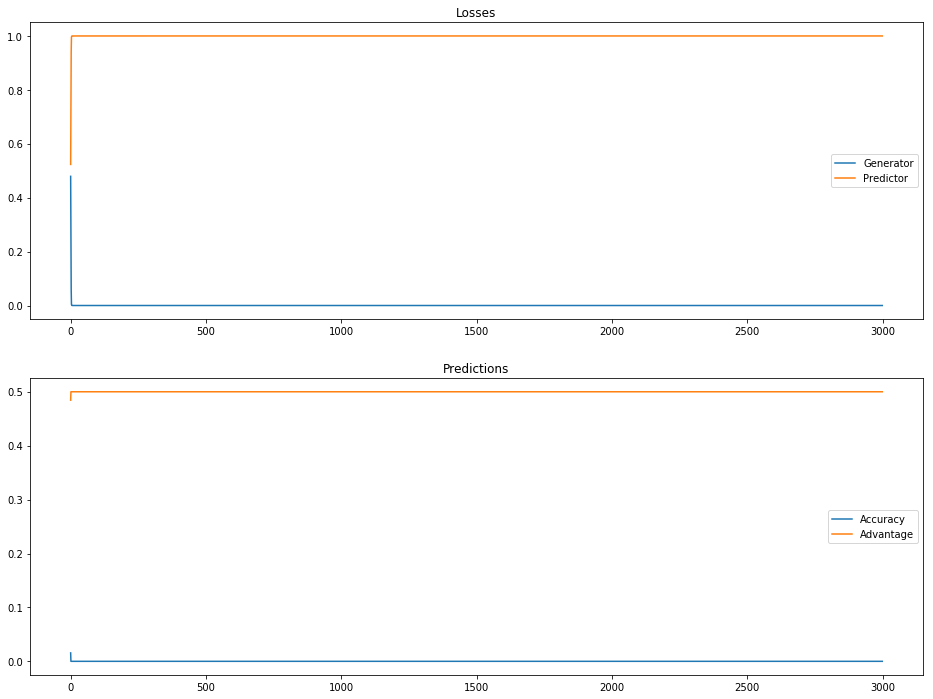

In [21]:
cprng_gan6.show_curves()

## 3. Loss 정의의 중요성

특히 generator를 학습시킬 때 loss를 잘 정의해야 원하는 대로 훈련이 됩니다.

loss를 좀 이상하게 정의하면 이렇게 됩니다. :(

* 위 코드와 차이점은 113, 114번 라인에 존재합니다.

In [23]:
from __future__ import print_function, division

import keras as keras
import keras.backend as K
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Lambda
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

from keras.utils import plot_model
import matplotlib.pyplot as plt

import sys

import numpy as np

def display_model_structure(model, figsize = (10, 20), saveTo = 'dummy.png'):
    plot_model(model, to_file=saveTo, show_shapes = True, show_layer_names=True)
    fig = plt.figure(figsize = figsize)
    ax = plt.axes()
    ax.axis('off')
    ax.imshow(plt.imread(saveTo))
    plt.show()
    return

class CPRNG_GAN_wrong_loss():
    def __init__(self, latent_dim = 2, gen_width = 10,
                 generator = [300, 300, 300],
                 predictor = [100],
                 optimizer = Adam(0.0002, 0.5)):
        self.latent_dim = latent_dim
        self.input_shape = (latent_dim,)
        self.output_shape = (gen_width, )
        self.optimizer = optimizer
        self.generator_param = generator
        self.predictor_param = predictor

        # Build and compile the predictor
        self.predictor = self.build_predictor()

        # Build the generator
        self.generator = self.build_generator()
        
        # Build the combined model(to train the generator)
        self.combined  = self.build_combined()
        return

    def build_generator(self):

        model = Sequential()
        model.add(Dense(self.generator_param[0], input_dim = self.latent_dim, name = 'g_dense_1'))
        model.add(LeakyReLU(alpha=0.2, name = 'g_leakyReLU_1'))
        for i, num_units in enumerate(self.generator_param[1:]):
            model.add(Dense(num_units, name = 'g_dense_{}'.format(i + 2)))
            model.add(LeakyReLU(alpha = 0.2, name = 'g_leakyReLU_{}'.format(i + 2)))

        model.add(Dense(np.prod(self.output_shape), activation = 'sigmoid', name = 'g_dense_{}'.format(len(self.generator_param) + 1)))
        model.add(Reshape(self.output_shape, name = 'g_reshape_output'))
        model.summary(100)
        display_model_structure(model, saveTo = 'cprng_generator.png')
        
        z = Input(shape=(self.latent_dim,), name = 'latent_input')
        sequence = model(z)
        m = Model(z, sequence, name = 'generator')
        return m

    def build_predictor(self):

        sequence = Input(shape=self.output_shape, name = 'sequence_input')
        split = Lambda(lambda x: K.tf.split(x, [self.output_shape[0] - 1, 1], 1), name = 'splitter')(sequence)
        dense = split[0]
        for i, num_units in enumerate(self.predictor_param):
            dense = Dense(num_units, name = 'dense_{}'.format(i + 1))(dense)
            dense = LeakyReLU(alpha = 0.2, name = 'leakyReLU_{}'.format(i + 1))(dense)
        predicted = Dense(1, activation = 'sigmoid', name = 'predicted')(dense)

        m = Model(sequence, [predicted, split[1]], name = 'predictor')
        def loss(y_true, y_pred):
            l = K.mean(K.abs(predicted - split[1]), axis = -1) * 0.5
            #l = K.mean(K.binary_crossentropy(predicted, split[1]), axis = -1) * 0.5
            return l
        
        def accuracy(y_true, y_pred):
            acc = K.mean(K.equal(K.round(predicted), K.round(split[1])), axis = -1)
            return acc
        
        m.compile(optimizer = self.optimizer, loss = loss, metrics = [accuracy])
        m.summary(100)
        display_model_structure(m, saveTo = 'cprng_predictor.png')
        
        return m

    def build_combined(self):
        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,), name = 'latent_input')
        sequence = self.generator(z)

        # For the combined model we will only train the generator
        self.predictor.trainable = False

        # The discriminator takes generated sequence as input and determines predicted
        predicted = self.predictor(sequence)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        m = Model(z, predicted, name = 'combined')
        m.summary(100)
        display_model_structure(m, saveTo = 'cprng_combined.png')
        def loss(y_true, y_pred):
            l = K.mean(1 - K.abs(predicted[0] - predicted[1]), axis = -1) * 0.5
            #l = K.mean(K.abs(1 - predicted[0] - predicted[1]), axis = -1) * 0.5
            #l = K.mean(K.binary_crossentropy(1 - predicted[0], predicted[1]), axis = -1) * 0.5
            return l
            
        m.compile(loss=loss, optimizer=self.optimizer)
        return m
    
    def train(self, epochs, batch_size=128, adv_multiplier = 3, sample_interval=50, verbose = 1):
        self.history = dict.fromkeys(['g_loss', 'p_loss', 'acc', 'adv'])
        self.history['g_loss'] = []
        self.history['p_loss'] = []
        self.history['acc'] = []
        self.history['adv'] = []
        dummy_target = np.zeros((batch_size, 1))
        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            for _ in range(adv_multiplier):
                #noise = np.random.random(0, 1, (batch_size, self.latent_dim))
                noise = np.random.rand(batch_size, self.latent_dim)

                # Generate a batch of new sequences
                gen_seqs = self.generator.predict(noise)

                # Train the predictor
                p_loss = self.predictor.train_on_batch(gen_seqs, [dummy_target, dummy_target])

            # ---------------------
            #  Train Generator
            # ---------------------

            #noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            noise = np.random.rand(batch_size, self.latent_dim)

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, [dummy_target, dummy_target])

            # Plot the progress
            print ("%d [P loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, p_loss[0], 100*p_loss[3], g_loss[0]))
            self.history['g_loss'].append(g_loss[0])
            self.history['p_loss'].append(p_loss[0])
            self.history['acc'].append(p_loss[3])
            self.history['adv'].append(abs(p_loss[3] - 0.5))

            # If at save interval => save generated image samples
            if verbose == 1 and epoch % sample_interval == 0:
                self.sample_sequences(epoch)

    def sample_sequences(self, epoch, num_samples = 10):
        noise = np.random.normal(0, 1, (num_samples, self.latent_dim))
        gen_seqs = self.generator.predict(noise)
        gen_seqs = np.array(gen_seqs > 0.5, dtype = int)

        for i in range(num_samples):
            print(gen_seqs[i])

        return

    def show_curves(self):
        fig = plt.figure(figsize = (16, 12))
        ax = fig.subplots(2, 1)
        ax[0].plot(self.history['g_loss'])
        ax[0].plot(self.history['p_loss'])
        ax[0].set_title('Losses')
        ax[0].legend(['Generator', 'Predictor'])
        ax[1].plot(self.history['acc'])
        ax[1].plot(self.history['adv'])
        ax[1].set_title('Predictions')
        ax[1].legend(['Accuracy', 'Advantage'])
        plt.show()
        return

____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
sequence_input (InputLayer)                  (None, 300)                             0              
____________________________________________________________________________________________________
splitter (Lambda)                            [(None, 299), (None, 1)]                0              
____________________________________________________________________________________________________
dense_1 (Dense)                              (None, 100)                             30000          
____________________________________________________________________________________________________
leakyReLU_1 (LeakyReLU)                      (None, 100)                             0              
___________________________________________________________________________________________

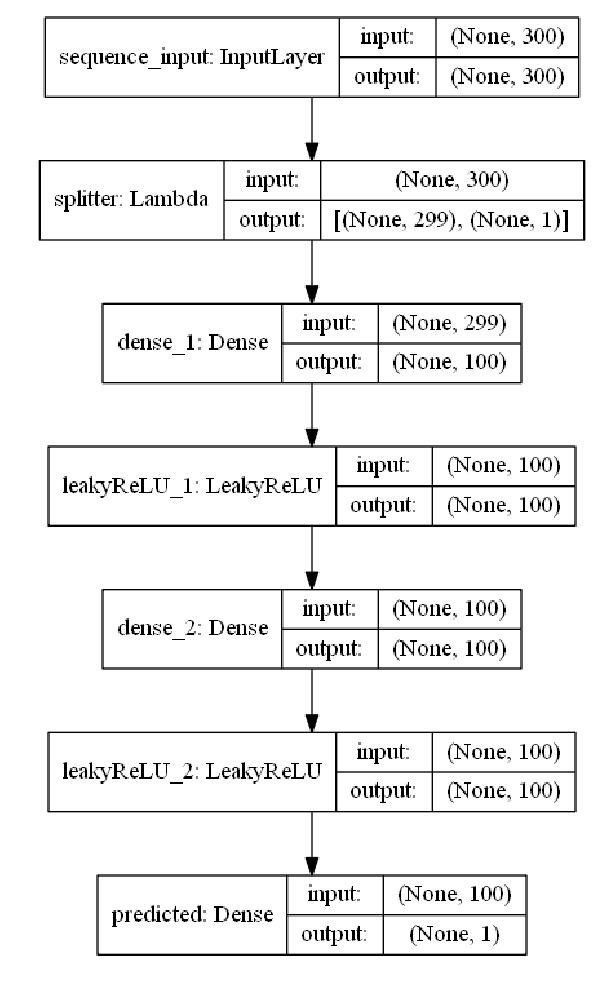

____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
g_dense_1 (Dense)                            (None, 100)                             10100          
____________________________________________________________________________________________________
g_leakyReLU_1 (LeakyReLU)                    (None, 100)                             0              
____________________________________________________________________________________________________
g_dense_2 (Dense)                            (None, 100)                             10100          
____________________________________________________________________________________________________
g_leakyReLU_2 (LeakyReLU)                    (None, 100)                             0              
___________________________________________________________________________________________

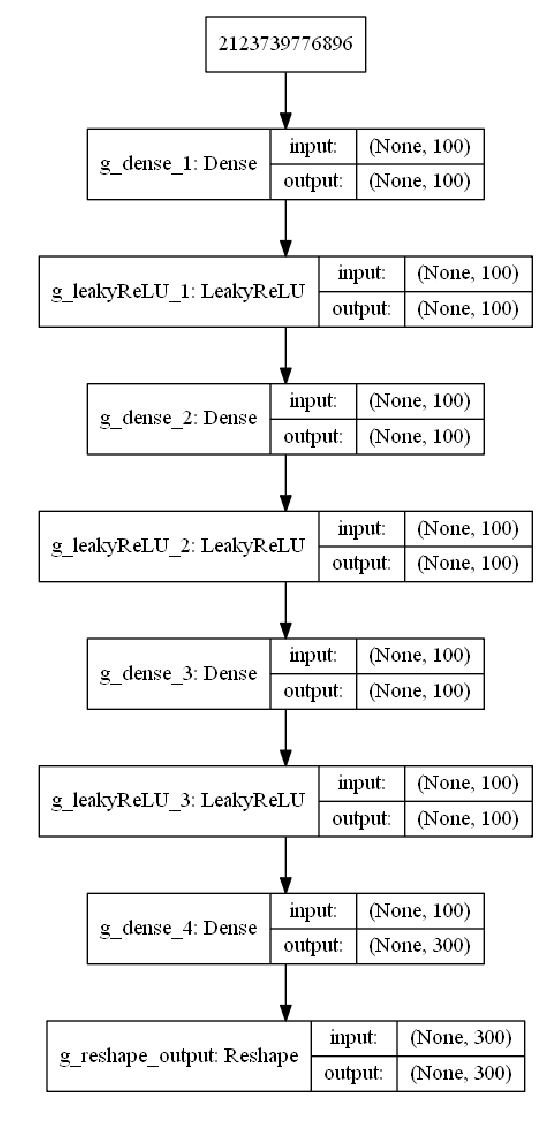

____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
latent_input (InputLayer)                    (None, 100)                             0              
____________________________________________________________________________________________________
generator (Model)                            (None, 300)                             60600          
____________________________________________________________________________________________________
predictor (Model)                            [(None, 1), (None, 1)]                  40201          
Total params: 100,801
Trainable params: 60,600
Non-trainable params: 40,201
____________________________________________________________________________________________________


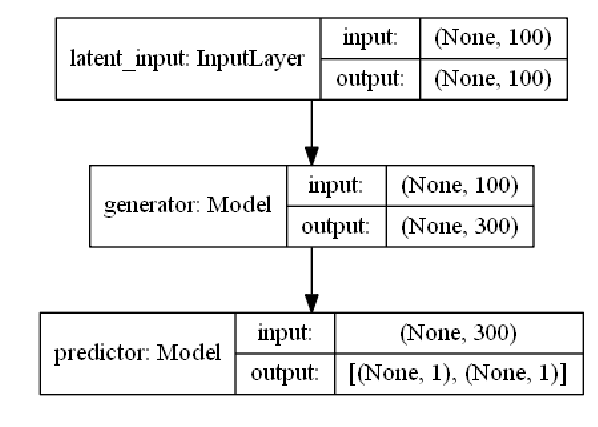

D:\Anaconda3\envs\keras\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [P loss: 0.129483, acc.: 0.00%] [G loss: 0.925749]
[0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 0 0 0 1 1 0 1 0
 1 1 1 0 0 1 0 1 1 1 1 0 1 1 0 0 0 1 0 1 0 0 0 1 0 1 1 0 1 0 1 1 0 1 0 1 1
 1 1 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1
 0 0 0 1 1 1 0 1 0 1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 0 0 0 0 1 1 0 0 1 1
 0 1 1 1 1 0 1 1 0 0 0 1 0 1 1 1 0 0 0 1 1 1 0 1 1 0 1 0 0 1 1 0 0 0 1 0 0
 1 1 1 0 0 1 1 1 0 0 1 1 0 1 0 0 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 0 0 0 0
 1 0 1 0 0 0 1 1 1 0 1 1 0 1 0 1 0 1 0 0 1 1 1 1 0 0 1 0 0 0 0 1 1 0 1 1 0
 1 1 0 0 1 1 1 1 1 0 1 0 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 0 1 0 0 0 1 1 0
 1 1 1 1]
[0 0 0 1 1 0 1 0 0 0 1 0 1 0 1 0 0 1 1 1 0 0 1 0 1 0 1 1 0 1 0 0 1 1 0 0 1
 0 1 1 0 1 0 0 1 1 1 0 0 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 1 1 0 0 0 1 1 1 1 1
 0 1 0 1 0 0 1 1 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 1 1 0 0 1
 0 0 0 1 1 1 1 0 0 1 0 0 0 0 0 1 0 1 0 0 1 1 1 1 0 1 1 0 0 0 1 0 1 0 0 1 1
 0 0 1 0 0 1 1 1 0 1 0 1 0 1 1 0 0 1 

41 [P loss: 0.103095, acc.: 55.47%] [G loss: 0.890896]
42 [P loss: 0.122006, acc.: 27.34%] [G loss: 0.873545]
43 [P loss: 0.146935, acc.: 64.06%] [G loss: 0.868578]
44 [P loss: 0.141261, acc.: 52.34%] [G loss: 0.870610]
45 [P loss: 0.132050, acc.: 63.28%] [G loss: 0.867075]
46 [P loss: 0.123011, acc.: 84.38%] [G loss: 0.864902]
47 [P loss: 0.167131, acc.: 50.78%] [G loss: 0.834961]
48 [P loss: 0.167378, acc.: 75.00%] [G loss: 0.846048]
49 [P loss: 0.143139, acc.: 89.06%] [G loss: 0.874577]
50 [P loss: 0.136312, acc.: 88.28%] [G loss: 0.868074]
51 [P loss: 0.138355, acc.: 87.50%] [G loss: 0.855985]
52 [P loss: 0.186300, acc.: 53.12%] [G loss: 0.839530]
53 [P loss: 0.171162, acc.: 42.19%] [G loss: 0.834189]
54 [P loss: 0.144137, acc.: 80.47%] [G loss: 0.850084]
55 [P loss: 0.175332, acc.: 67.19%] [G loss: 0.846695]
56 [P loss: 0.161404, acc.: 65.62%] [G loss: 0.840257]
57 [P loss: 0.185595, acc.: 53.91%] [G loss: 0.831685]
58 [P loss: 0.162902, acc.: 57.03%] [G loss: 0.838481]
59 [P loss

191 [P loss: 0.021257, acc.: 99.22%] [G loss: 0.988038]
192 [P loss: 0.014745, acc.: 100.00%] [G loss: 0.980672]
193 [P loss: 0.017642, acc.: 100.00%] [G loss: 0.985626]
194 [P loss: 0.028625, acc.: 99.22%] [G loss: 0.978015]
195 [P loss: 0.030540, acc.: 99.22%] [G loss: 0.959516]
196 [P loss: 0.063704, acc.: 96.09%] [G loss: 0.957202]
197 [P loss: 0.071020, acc.: 97.66%] [G loss: 0.932672]
198 [P loss: 0.114955, acc.: 92.19%] [G loss: 0.845772]
199 [P loss: 0.206160, acc.: 86.72%] [G loss: 0.736862]
200 [P loss: 0.500423, acc.: 46.09%] [G loss: 0.502869]
[0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 0 0 1 1 1 0 0 1
 0 1 0 1 0 1 0 0 1 0 1 1 1 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1
 0 0 0 0 0 0 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0 0 0 1 1 1 0 1 0 0 0 0 1 0 0 0 1
 0 0 0 1 1 1 1 1 0 0 1 0 1 0 0 1 0 0 0 0 1 1 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0
 0 1 1 0 1 1 1 1 0 1 1 1 0 1 1 0 1 1 0 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0
 1 1 0 0 1 1 1 0 1 0 1 1 1 0 0 0 0 1 1 1 0 0 0 1 1 1 1 0 1 0 1 

234 [P loss: 0.283665, acc.: 71.09%] [G loss: 0.735854]
235 [P loss: 0.427254, acc.: 42.19%] [G loss: 0.644488]
236 [P loss: 0.348928, acc.: 19.53%] [G loss: 0.733954]
237 [P loss: 0.144457, acc.: 94.53%] [G loss: 0.866247]
238 [P loss: 0.119525, acc.: 92.19%] [G loss: 0.870052]
239 [P loss: 0.154122, acc.: 85.16%] [G loss: 0.873297]
240 [P loss: 0.175767, acc.: 83.59%] [G loss: 0.780475]
241 [P loss: 0.284691, acc.: 67.19%] [G loss: 0.722213]
242 [P loss: 0.381884, acc.: 37.50%] [G loss: 0.653109]
243 [P loss: 0.274197, acc.: 79.69%] [G loss: 0.787369]
244 [P loss: 0.151982, acc.: 86.72%] [G loss: 0.830391]
245 [P loss: 0.153477, acc.: 84.38%] [G loss: 0.838361]
246 [P loss: 0.217562, acc.: 75.78%] [G loss: 0.800694]
247 [P loss: 0.247736, acc.: 63.28%] [G loss: 0.725652]
248 [P loss: 0.284946, acc.: 51.56%] [G loss: 0.704001]
249 [P loss: 0.281065, acc.: 82.03%] [G loss: 0.730050]
250 [P loss: 0.268804, acc.: 68.75%] [G loss: 0.757205]
251 [P loss: 0.248933, acc.: 73.44%] [G loss: 0.

385 [P loss: 0.352816, acc.: 100.00%] [G loss: 0.794320]
386 [P loss: 0.084549, acc.: 100.00%] [G loss: 0.942703]
387 [P loss: 0.033833, acc.: 100.00%] [G loss: 0.968646]
388 [P loss: 0.020838, acc.: 100.00%] [G loss: 0.982628]
389 [P loss: 0.016659, acc.: 100.00%] [G loss: 0.986621]
390 [P loss: 0.015572, acc.: 100.00%] [G loss: 0.986688]
391 [P loss: 0.013141, acc.: 100.00%] [G loss: 0.990358]
392 [P loss: 0.009744, acc.: 100.00%] [G loss: 0.991205]
393 [P loss: 0.011504, acc.: 100.00%] [G loss: 0.988364]
394 [P loss: 0.010166, acc.: 100.00%] [G loss: 0.985034]
395 [P loss: 0.015188, acc.: 100.00%] [G loss: 0.991127]
396 [P loss: 0.009234, acc.: 100.00%] [G loss: 0.993307]
397 [P loss: 0.006343, acc.: 100.00%] [G loss: 0.990724]
398 [P loss: 0.008004, acc.: 100.00%] [G loss: 0.992477]
399 [P loss: 0.016226, acc.: 99.22%] [G loss: 0.981058]
400 [P loss: 0.011234, acc.: 100.00%] [G loss: 0.976694]
[0 0 1 1 0 0 0 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 0 1 0 1 0 1 0 0 0 1 0 1 1 1
 1 1 1 1 1 1 0

427 [P loss: 0.034358, acc.: 99.22%] [G loss: 0.967619]
428 [P loss: 0.028049, acc.: 99.22%] [G loss: 0.978099]
429 [P loss: 0.016811, acc.: 100.00%] [G loss: 0.980143]
430 [P loss: 0.030151, acc.: 99.22%] [G loss: 0.968406]
431 [P loss: 0.032553, acc.: 98.44%] [G loss: 0.982887]
432 [P loss: 0.026243, acc.: 99.22%] [G loss: 0.979143]
433 [P loss: 0.020181, acc.: 100.00%] [G loss: 0.959381]
434 [P loss: 0.053776, acc.: 97.66%] [G loss: 0.956441]
435 [P loss: 0.056792, acc.: 97.66%] [G loss: 0.937098]
436 [P loss: 0.076759, acc.: 94.53%] [G loss: 0.947921]
437 [P loss: 0.062668, acc.: 96.09%] [G loss: 0.878367]
438 [P loss: 0.125656, acc.: 90.62%] [G loss: 0.855383]
439 [P loss: 0.174499, acc.: 82.81%] [G loss: 0.829106]
440 [P loss: 0.235810, acc.: 77.34%] [G loss: 0.750163]
441 [P loss: 0.360908, acc.: 64.06%] [G loss: 0.620804]
442 [P loss: 0.520794, acc.: 44.53%] [G loss: 0.519256]
443 [P loss: 0.663733, acc.: 28.91%] [G loss: 0.308580]
444 [P loss: 0.797188, acc.: 15.62%] [G loss: 

575 [P loss: 0.516229, acc.: 35.16%] [G loss: 0.506417]
576 [P loss: 0.454818, acc.: 33.59%] [G loss: 0.506130]
577 [P loss: 0.422943, acc.: 14.06%] [G loss: 0.636331]
578 [P loss: 0.275872, acc.: 92.97%] [G loss: 0.768766]
579 [P loss: 0.138351, acc.: 95.31%] [G loss: 0.874015]
580 [P loss: 0.099205, acc.: 96.09%] [G loss: 0.872337]
581 [P loss: 0.129660, acc.: 89.84%] [G loss: 0.840182]
582 [P loss: 0.167812, acc.: 82.81%] [G loss: 0.854643]
583 [P loss: 0.241155, acc.: 76.56%] [G loss: 0.810581]
584 [P loss: 0.326438, acc.: 64.06%] [G loss: 0.672522]
585 [P loss: 0.340080, acc.: 59.38%] [G loss: 0.661827]
586 [P loss: 0.433179, acc.: 46.09%] [G loss: 0.613851]
587 [P loss: 0.462461, acc.: 28.12%] [G loss: 0.568871]
588 [P loss: 0.419806, acc.: 28.12%] [G loss: 0.573083]
589 [P loss: 0.409322, acc.: 86.72%] [G loss: 0.649792]
590 [P loss: 0.328100, acc.: 89.06%] [G loss: 0.706996]
591 [P loss: 0.243838, acc.: 92.19%] [G loss: 0.784242]
592 [P loss: 0.170535, acc.: 92.19%] [G loss: 0.

618 [P loss: 0.155181, acc.: 87.50%] [G loss: 0.835289]
619 [P loss: 0.167730, acc.: 84.38%] [G loss: 0.830984]
620 [P loss: 0.271889, acc.: 70.31%] [G loss: 0.667966]
621 [P loss: 0.416262, acc.: 57.81%] [G loss: 0.614489]
622 [P loss: 0.546940, acc.: 36.72%] [G loss: 0.517622]
623 [P loss: 0.537078, acc.: 38.28%] [G loss: 0.438376]
624 [P loss: 0.578265, acc.: 19.53%] [G loss: 0.430399]
625 [P loss: 0.478538, acc.: 15.62%] [G loss: 0.571639]
626 [P loss: 0.346190, acc.: 88.28%] [G loss: 0.702297]
627 [P loss: 0.202207, acc.: 92.97%] [G loss: 0.802719]
628 [P loss: 0.151293, acc.: 92.97%] [G loss: 0.854437]
629 [P loss: 0.140493, acc.: 90.62%] [G loss: 0.856019]
630 [P loss: 0.165989, acc.: 86.72%] [G loss: 0.877962]
631 [P loss: 0.215789, acc.: 78.91%] [G loss: 0.790821]
632 [P loss: 0.190397, acc.: 83.59%] [G loss: 0.721983]
633 [P loss: 0.278644, acc.: 73.44%] [G loss: 0.689760]
634 [P loss: 0.431759, acc.: 54.69%] [G loss: 0.614551]
635 [P loss: 0.558337, acc.: 41.41%] [G loss: 0.

765 [P loss: 0.848373, acc.: 8.59%] [G loss: 0.171671]
766 [P loss: 0.903087, acc.: 1.56%] [G loss: 0.150214]
767 [P loss: 0.843938, acc.: 1.56%] [G loss: 0.213436]
768 [P loss: 0.674758, acc.: 0.00%] [G loss: 0.453906]
769 [P loss: 0.277723, acc.: 96.88%] [G loss: 0.831256]
770 [P loss: 0.071361, acc.: 99.22%] [G loss: 0.950244]
771 [P loss: 0.039026, acc.: 99.22%] [G loss: 0.970751]
772 [P loss: 0.053522, acc.: 96.09%] [G loss: 0.966402]
773 [P loss: 0.028465, acc.: 100.00%] [G loss: 0.973455]
774 [P loss: 0.048634, acc.: 96.09%] [G loss: 0.976573]
775 [P loss: 0.022362, acc.: 99.22%] [G loss: 0.949827]
776 [P loss: 0.034063, acc.: 100.00%] [G loss: 0.978075]
777 [P loss: 0.039812, acc.: 97.66%] [G loss: 0.962412]
778 [P loss: 0.051611, acc.: 96.09%] [G loss: 0.950912]
779 [P loss: 0.072949, acc.: 96.88%] [G loss: 0.940641]
780 [P loss: 0.081848, acc.: 92.97%] [G loss: 0.913798]
781 [P loss: 0.087120, acc.: 92.19%] [G loss: 0.929583]
782 [P loss: 0.110116, acc.: 91.41%] [G loss: 0.91

807 [P loss: 0.551390, acc.: 7.81%] [G loss: 0.549668]
808 [P loss: 0.378224, acc.: 92.97%] [G loss: 0.697795]
809 [P loss: 0.214674, acc.: 96.09%] [G loss: 0.840264]
810 [P loss: 0.128631, acc.: 92.19%] [G loss: 0.907700]
811 [P loss: 0.090524, acc.: 94.53%] [G loss: 0.923725]
812 [P loss: 0.067941, acc.: 95.31%] [G loss: 0.905924]
813 [P loss: 0.129101, acc.: 88.28%] [G loss: 0.879456]
814 [P loss: 0.106238, acc.: 91.41%] [G loss: 0.872422]
815 [P loss: 0.171736, acc.: 85.94%] [G loss: 0.884644]
816 [P loss: 0.167625, acc.: 84.38%] [G loss: 0.746637]
817 [P loss: 0.297465, acc.: 67.97%] [G loss: 0.776079]
818 [P loss: 0.288716, acc.: 71.09%] [G loss: 0.702310]
819 [P loss: 0.440818, acc.: 51.56%] [G loss: 0.603918]
820 [P loss: 0.488761, acc.: 44.53%] [G loss: 0.558299]
821 [P loss: 0.555473, acc.: 29.69%] [G loss: 0.486449]
822 [P loss: 0.517042, acc.: 26.56%] [G loss: 0.446345]
823 [P loss: 0.476325, acc.: 21.88%] [G loss: 0.511542]
824 [P loss: 0.418444, acc.: 39.84%] [G loss: 0.6

956 [P loss: 0.404882, acc.: 50.00%] [G loss: 0.582061]
957 [P loss: 0.387655, acc.: 51.56%] [G loss: 0.586000]
958 [P loss: 0.405686, acc.: 51.56%] [G loss: 0.581044]
959 [P loss: 0.395883, acc.: 48.44%] [G loss: 0.618297]
960 [P loss: 0.418076, acc.: 47.66%] [G loss: 0.599869]
961 [P loss: 0.373834, acc.: 75.78%] [G loss: 0.609120]
962 [P loss: 0.385958, acc.: 94.53%] [G loss: 0.619765]
963 [P loss: 0.377494, acc.: 75.00%] [G loss: 0.638557]
964 [P loss: 0.378809, acc.: 60.16%] [G loss: 0.630881]
965 [P loss: 0.369007, acc.: 76.56%] [G loss: 0.628595]
966 [P loss: 0.370972, acc.: 81.25%] [G loss: 0.637812]
967 [P loss: 0.357008, acc.: 86.72%] [G loss: 0.643840]
968 [P loss: 0.341992, acc.: 95.31%] [G loss: 0.651156]
969 [P loss: 0.340830, acc.: 77.34%] [G loss: 0.643768]
970 [P loss: 0.340173, acc.: 74.22%] [G loss: 0.643968]
971 [P loss: 0.337475, acc.: 97.66%] [G loss: 0.678738]
972 [P loss: 0.358978, acc.: 86.72%] [G loss: 0.659633]
973 [P loss: 0.353096, acc.: 88.28%] [G loss: 0.

1006 [P loss: 0.331075, acc.: 67.19%] [G loss: 0.642142]
1007 [P loss: 0.355461, acc.: 89.84%] [G loss: 0.656150]
1008 [P loss: 0.360410, acc.: 96.09%] [G loss: 0.646468]
1009 [P loss: 0.335855, acc.: 74.22%] [G loss: 0.681645]
1010 [P loss: 0.318065, acc.: 86.72%] [G loss: 0.669441]
1011 [P loss: 0.339519, acc.: 78.91%] [G loss: 0.682857]
1012 [P loss: 0.338692, acc.: 85.16%] [G loss: 0.660494]
1013 [P loss: 0.323586, acc.: 78.12%] [G loss: 0.686542]
1014 [P loss: 0.369860, acc.: 74.22%] [G loss: 0.653053]
1015 [P loss: 0.354826, acc.: 95.31%] [G loss: 0.656353]
1016 [P loss: 0.377155, acc.: 62.50%] [G loss: 0.639657]
1017 [P loss: 0.402085, acc.: 82.81%] [G loss: 0.644630]
1018 [P loss: 0.404061, acc.: 73.44%] [G loss: 0.623155]
1019 [P loss: 0.414745, acc.: 76.56%] [G loss: 0.601948]
1020 [P loss: 0.399363, acc.: 58.59%] [G loss: 0.609174]
1021 [P loss: 0.412086, acc.: 60.94%] [G loss: 0.636152]
1022 [P loss: 0.486928, acc.: 49.22%] [G loss: 0.584021]
1023 [P loss: 0.492129, acc.: 4

1155 [P loss: 0.445997, acc.: 53.91%] [G loss: 0.561992]
1156 [P loss: 0.482219, acc.: 46.09%] [G loss: 0.545499]
1157 [P loss: 0.525808, acc.: 29.69%] [G loss: 0.570001]
1158 [P loss: 0.314769, acc.: 66.41%] [G loss: 0.689058]
1159 [P loss: 0.341840, acc.: 64.06%] [G loss: 0.741904]
1160 [P loss: 0.358379, acc.: 61.72%] [G loss: 0.693576]
1161 [P loss: 0.325858, acc.: 66.41%] [G loss: 0.648321]
1162 [P loss: 0.366423, acc.: 57.81%] [G loss: 0.623636]
1163 [P loss: 0.389542, acc.: 50.00%] [G loss: 0.633895]
1164 [P loss: 0.359355, acc.: 92.97%] [G loss: 0.659410]
1165 [P loss: 0.347295, acc.: 91.41%] [G loss: 0.671633]
1166 [P loss: 0.336005, acc.: 67.97%] [G loss: 0.673778]
1167 [P loss: 0.336724, acc.: 100.00%] [G loss: 0.665193]
1168 [P loss: 0.339289, acc.: 96.88%] [G loss: 0.663641]
1169 [P loss: 0.329287, acc.: 83.59%] [G loss: 0.676207]
1170 [P loss: 0.351961, acc.: 85.94%] [G loss: 0.655319]
1171 [P loss: 0.361218, acc.: 78.91%] [G loss: 0.667402]
1172 [P loss: 0.367665, acc.: 

1204 [P loss: 0.377550, acc.: 67.97%] [G loss: 0.656001]
1205 [P loss: 0.364525, acc.: 68.75%] [G loss: 0.651095]
1206 [P loss: 0.373434, acc.: 93.75%] [G loss: 0.631051]
1207 [P loss: 0.410717, acc.: 45.31%] [G loss: 0.641026]
1208 [P loss: 0.407722, acc.: 41.41%] [G loss: 0.640588]
1209 [P loss: 0.404221, acc.: 94.53%] [G loss: 0.630244]
1210 [P loss: 0.389493, acc.: 90.62%] [G loss: 0.619816]
1211 [P loss: 0.406616, acc.: 86.72%] [G loss: 0.607426]
1212 [P loss: 0.424562, acc.: 75.00%] [G loss: 0.610470]
1213 [P loss: 0.429335, acc.: 78.12%] [G loss: 0.599479]
1214 [P loss: 0.432492, acc.: 57.03%] [G loss: 0.568824]
1215 [P loss: 0.430235, acc.: 56.25%] [G loss: 0.581670]
1216 [P loss: 0.473598, acc.: 46.88%] [G loss: 0.556489]
1217 [P loss: 0.460058, acc.: 52.34%] [G loss: 0.579828]
1218 [P loss: 0.484312, acc.: 46.09%] [G loss: 0.579191]
1219 [P loss: 0.454912, acc.: 54.69%] [G loss: 0.607329]
1220 [P loss: 0.429777, acc.: 57.03%] [G loss: 0.534455]
1221 [P loss: 0.452912, acc.: 5

1352 [P loss: 0.992756, acc.: 0.78%] [G loss: 0.008285]
1353 [P loss: 0.999326, acc.: 0.00%] [G loss: 0.000712]
1354 [P loss: 0.995671, acc.: 0.00%] [G loss: 0.000903]
1355 [P loss: 0.999315, acc.: 0.00%] [G loss: 0.000787]
1356 [P loss: 0.999084, acc.: 0.00%] [G loss: 0.004010]
1357 [P loss: 0.996783, acc.: 0.00%] [G loss: 0.001551]
1358 [P loss: 0.998343, acc.: 0.00%] [G loss: 0.000820]
1359 [P loss: 0.999271, acc.: 0.00%] [G loss: 0.005776]
1360 [P loss: 0.997058, acc.: 0.00%] [G loss: 0.001353]
1361 [P loss: 0.999228, acc.: 0.00%] [G loss: 0.000790]
1362 [P loss: 0.999228, acc.: 0.00%] [G loss: 0.000826]
1363 [P loss: 0.996644, acc.: 0.00%] [G loss: 0.000839]
1364 [P loss: 0.998333, acc.: 0.00%] [G loss: 0.000961]
1365 [P loss: 0.999143, acc.: 0.00%] [G loss: 0.001361]
1366 [P loss: 0.992395, acc.: 0.78%] [G loss: 0.006274]
1367 [P loss: 0.992778, acc.: 0.78%] [G loss: 0.000885]
1368 [P loss: 0.999126, acc.: 0.00%] [G loss: 0.000880]
1369 [P loss: 0.998231, acc.: 0.00%] [G loss: 0.

1401 [P loss: 0.996382, acc.: 0.00%] [G loss: 0.003795]
1402 [P loss: 0.995976, acc.: 0.00%] [G loss: 0.004203]
1403 [P loss: 0.995512, acc.: 0.00%] [G loss: 0.004725]
1404 [P loss: 0.994405, acc.: 0.00%] [G loss: 0.005288]
1405 [P loss: 0.994282, acc.: 0.00%] [G loss: 0.006030]
1406 [P loss: 0.993282, acc.: 0.00%] [G loss: 0.012405]
1407 [P loss: 0.990281, acc.: 0.00%] [G loss: 0.008625]
1408 [P loss: 0.989986, acc.: 0.00%] [G loss: 0.010707]
1409 [P loss: 0.987559, acc.: 0.00%] [G loss: 0.014266]
1410 [P loss: 0.983017, acc.: 0.00%] [G loss: 0.020153]
1411 [P loss: 0.972517, acc.: 0.00%] [G loss: 0.032753]
1412 [P loss: 0.943343, acc.: 0.78%] [G loss: 0.070996]
1413 [P loss: 0.848482, acc.: 0.00%] [G loss: 0.315785]
1414 [P loss: 0.230815, acc.: 100.00%] [G loss: 0.929840]
1415 [P loss: 0.017804, acc.: 100.00%] [G loss: 0.989247]
1416 [P loss: 0.007850, acc.: 100.00%] [G loss: 0.993436]
1417 [P loss: 0.006084, acc.: 100.00%] [G loss: 0.985739]
1418 [P loss: 0.005021, acc.: 100.00%] [

1549 [P loss: 0.000248, acc.: 100.00%] [G loss: 0.999189]
1550 [P loss: 0.003667, acc.: 100.00%] [G loss: 0.979625]
1551 [P loss: 0.000238, acc.: 100.00%] [G loss: 0.995456]
1552 [P loss: 0.007977, acc.: 99.22%] [G loss: 0.999836]
1553 [P loss: 0.008722, acc.: 99.22%] [G loss: 0.991514]
1554 [P loss: 0.008077, acc.: 99.22%] [G loss: 0.998227]
1555 [P loss: 0.001575, acc.: 100.00%] [G loss: 0.987134]
1556 [P loss: 0.000732, acc.: 100.00%] [G loss: 0.999406]
1557 [P loss: 0.003265, acc.: 100.00%] [G loss: 0.985623]
1558 [P loss: 0.008253, acc.: 99.22%] [G loss: 0.992180]
1559 [P loss: 0.007805, acc.: 99.22%] [G loss: 0.999300]
1560 [P loss: 0.016411, acc.: 97.66%] [G loss: 0.998950]
1561 [P loss: 0.010093, acc.: 99.22%] [G loss: 0.984716]
1562 [P loss: 0.000786, acc.: 100.00%] [G loss: 0.999049]
1563 [P loss: 0.001448, acc.: 100.00%] [G loss: 0.979621]
1564 [P loss: 0.012372, acc.: 99.22%] [G loss: 0.993039]
1565 [P loss: 0.005652, acc.: 100.00%] [G loss: 0.999130]
1566 [P loss: 0.033307

1606 [P loss: 0.992437, acc.: 0.78%] [G loss: 0.021450]
1607 [P loss: 0.990814, acc.: 0.78%] [G loss: 0.007993]
1608 [P loss: 0.994157, acc.: 0.78%] [G loss: 0.008482]
1609 [P loss: 0.998303, acc.: 0.00%] [G loss: 0.007003]
1610 [P loss: 0.987822, acc.: 1.56%] [G loss: 0.008181]
1611 [P loss: 0.972811, acc.: 2.34%] [G loss: 0.006375]
1612 [P loss: 0.979199, acc.: 2.34%] [G loss: 0.006583]
1613 [P loss: 0.995996, acc.: 0.00%] [G loss: 0.025250]
1614 [P loss: 0.991473, acc.: 0.78%] [G loss: 0.020888]
1615 [P loss: 0.991854, acc.: 0.78%] [G loss: 0.004285]
1616 [P loss: 0.995799, acc.: 0.00%] [G loss: 0.001984]
1617 [P loss: 0.997420, acc.: 0.00%] [G loss: 0.001040]
1618 [P loss: 0.999660, acc.: 0.00%] [G loss: 0.012129]
1619 [P loss: 0.999327, acc.: 0.00%] [G loss: 0.000285]
1620 [P loss: 0.999672, acc.: 0.00%] [G loss: 0.004148]
1621 [P loss: 0.991564, acc.: 0.78%] [G loss: 0.000569]
1622 [P loss: 0.988707, acc.: 1.56%] [G loss: 0.001605]
1623 [P loss: 0.998488, acc.: 0.00%] [G loss: 0.

1755 [P loss: 0.000554, acc.: 100.00%] [G loss: 0.998194]
1756 [P loss: 0.000714, acc.: 100.00%] [G loss: 0.987686]
1757 [P loss: 0.000669, acc.: 100.00%] [G loss: 0.999308]
1758 [P loss: 0.008050, acc.: 99.22%] [G loss: 0.999235]
1759 [P loss: 0.000506, acc.: 100.00%] [G loss: 0.997940]
1760 [P loss: 0.001528, acc.: 100.00%] [G loss: 0.999498]
1761 [P loss: 0.000590, acc.: 100.00%] [G loss: 0.999465]
1762 [P loss: 0.016243, acc.: 98.44%] [G loss: 0.996384]
1763 [P loss: 0.000492, acc.: 100.00%] [G loss: 0.999502]
1764 [P loss: 0.000456, acc.: 100.00%] [G loss: 0.999501]
1765 [P loss: 0.001815, acc.: 100.00%] [G loss: 0.999563]
1766 [P loss: 0.000456, acc.: 100.00%] [G loss: 0.999560]
1767 [P loss: 0.000431, acc.: 100.00%] [G loss: 0.994014]
1768 [P loss: 0.000751, acc.: 100.00%] [G loss: 0.999517]
1769 [P loss: 0.000428, acc.: 100.00%] [G loss: 0.999450]
1770 [P loss: 0.001802, acc.: 100.00%] [G loss: 0.999598]
1771 [P loss: 0.008294, acc.: 99.22%] [G loss: 0.996174]
1772 [P loss: 0.0

1804 [P loss: 0.000902, acc.: 100.00%] [G loss: 0.984424]
1805 [P loss: 0.000558, acc.: 100.00%] [G loss: 0.998959]
1806 [P loss: 0.004420, acc.: 100.00%] [G loss: 0.999589]
1807 [P loss: 0.004180, acc.: 100.00%] [G loss: 0.984602]
1808 [P loss: 0.000651, acc.: 100.00%] [G loss: 0.999170]
1809 [P loss: 0.001470, acc.: 100.00%] [G loss: 0.999320]
1810 [P loss: 0.001198, acc.: 100.00%] [G loss: 0.999706]
1811 [P loss: 0.010282, acc.: 99.22%] [G loss: 0.999625]
1812 [P loss: 0.000991, acc.: 100.00%] [G loss: 0.996719]
1813 [P loss: 0.002588, acc.: 100.00%] [G loss: 0.990079]
1814 [P loss: 0.002428, acc.: 100.00%] [G loss: 0.985940]
1815 [P loss: 0.009510, acc.: 99.22%] [G loss: 0.976773]
1816 [P loss: 0.003429, acc.: 100.00%] [G loss: 0.986770]
1817 [P loss: 0.014234, acc.: 99.22%] [G loss: 0.990953]
1818 [P loss: 0.001345, acc.: 100.00%] [G loss: 0.993941]
1819 [P loss: 0.009956, acc.: 99.22%] [G loss: 0.988531]
1820 [P loss: 0.002802, acc.: 100.00%] [G loss: 0.991452]
1821 [P loss: 0.00

1952 [P loss: 0.999647, acc.: 0.00%] [G loss: 0.003437]
1953 [P loss: 0.998675, acc.: 0.00%] [G loss: 0.001392]
1954 [P loss: 0.999634, acc.: 0.00%] [G loss: 0.000862]
1955 [P loss: 0.996947, acc.: 0.00%] [G loss: 0.000460]
1956 [P loss: 0.999603, acc.: 0.00%] [G loss: 0.000306]
1957 [P loss: 0.999106, acc.: 0.00%] [G loss: 0.001103]
1958 [P loss: 0.999718, acc.: 0.00%] [G loss: 0.000440]
1959 [P loss: 0.998895, acc.: 0.00%] [G loss: 0.000336]
1960 [P loss: 0.999473, acc.: 0.00%] [G loss: 0.000449]
1961 [P loss: 0.999657, acc.: 0.00%] [G loss: 0.012118]
1962 [P loss: 0.999446, acc.: 0.00%] [G loss: 0.001026]
1963 [P loss: 0.999601, acc.: 0.00%] [G loss: 0.000547]
1964 [P loss: 0.999153, acc.: 0.00%] [G loss: 0.000614]
1965 [P loss: 0.999698, acc.: 0.00%] [G loss: 0.000425]
1966 [P loss: 0.991742, acc.: 0.78%] [G loss: 0.001099]
1967 [P loss: 0.999667, acc.: 0.00%] [G loss: 0.000560]
1968 [P loss: 0.999349, acc.: 0.00%] [G loss: 0.000353]
1969 [P loss: 0.999509, acc.: 0.00%] [G loss: 0.

2009 [P loss: 0.999113, acc.: 0.00%] [G loss: 0.000756]
2010 [P loss: 0.999023, acc.: 0.00%] [G loss: 0.000831]
2011 [P loss: 0.999175, acc.: 0.00%] [G loss: 0.000851]
2012 [P loss: 0.998154, acc.: 0.00%] [G loss: 0.000973]
2013 [P loss: 0.999030, acc.: 0.00%] [G loss: 0.001060]
2014 [P loss: 0.999052, acc.: 0.00%] [G loss: 0.001059]
2015 [P loss: 0.999047, acc.: 0.00%] [G loss: 0.000967]
2016 [P loss: 0.998936, acc.: 0.00%] [G loss: 0.001074]
2017 [P loss: 0.998825, acc.: 0.00%] [G loss: 0.003850]
2018 [P loss: 0.993958, acc.: 0.78%] [G loss: 0.001254]
2019 [P loss: 0.998730, acc.: 0.00%] [G loss: 0.008714]
2020 [P loss: 0.998623, acc.: 0.00%] [G loss: 0.001655]
2021 [P loss: 0.998255, acc.: 0.00%] [G loss: 0.001636]
2022 [P loss: 0.998471, acc.: 0.00%] [G loss: 0.002244]
2023 [P loss: 0.998272, acc.: 0.00%] [G loss: 0.001726]
2024 [P loss: 0.997949, acc.: 0.00%] [G loss: 0.003915]
2025 [P loss: 0.997390, acc.: 0.00%] [G loss: 0.002338]
2026 [P loss: 0.991339, acc.: 0.78%] [G loss: 0.

2157 [P loss: 0.000244, acc.: 100.00%] [G loss: 0.999815]
2158 [P loss: 0.000175, acc.: 100.00%] [G loss: 0.999849]
2159 [P loss: 0.000156, acc.: 100.00%] [G loss: 0.999831]
2160 [P loss: 0.000161, acc.: 100.00%] [G loss: 0.999818]
2161 [P loss: 0.000169, acc.: 100.00%] [G loss: 0.999837]
2162 [P loss: 0.000165, acc.: 100.00%] [G loss: 0.999833]
2163 [P loss: 0.000160, acc.: 100.00%] [G loss: 0.999843]
2164 [P loss: 0.000160, acc.: 100.00%] [G loss: 0.999847]
2165 [P loss: 0.000164, acc.: 100.00%] [G loss: 0.999822]
2166 [P loss: 0.000146, acc.: 100.00%] [G loss: 0.999850]
2167 [P loss: 0.000154, acc.: 100.00%] [G loss: 0.999843]
2168 [P loss: 0.000154, acc.: 100.00%] [G loss: 0.999846]
2169 [P loss: 0.000159, acc.: 100.00%] [G loss: 0.999847]
2170 [P loss: 0.000152, acc.: 100.00%] [G loss: 0.999840]
2171 [P loss: 0.000140, acc.: 100.00%] [G loss: 0.999853]
2172 [P loss: 0.000149, acc.: 100.00%] [G loss: 0.999708]
2173 [P loss: 0.000138, acc.: 100.00%] [G loss: 0.999864]
2174 [P loss: 

2207 [P loss: 0.000101, acc.: 100.00%] [G loss: 0.999887]
2208 [P loss: 0.000121, acc.: 100.00%] [G loss: 0.999898]
2209 [P loss: 0.000111, acc.: 100.00%] [G loss: 0.999886]
2210 [P loss: 0.000112, acc.: 100.00%] [G loss: 0.999884]
2211 [P loss: 0.000120, acc.: 100.00%] [G loss: 0.999895]
2212 [P loss: 0.000123, acc.: 100.00%] [G loss: 0.999871]
2213 [P loss: 0.000105, acc.: 100.00%] [G loss: 0.999878]
2214 [P loss: 0.000098, acc.: 100.00%] [G loss: 0.999899]
2215 [P loss: 0.000107, acc.: 100.00%] [G loss: 0.999899]
2216 [P loss: 0.000113, acc.: 100.00%] [G loss: 0.999897]
2217 [P loss: 0.000109, acc.: 100.00%] [G loss: 0.999890]
2218 [P loss: 0.000110, acc.: 100.00%] [G loss: 0.999896]
2219 [P loss: 0.000108, acc.: 100.00%] [G loss: 0.999908]
2220 [P loss: 0.000103, acc.: 100.00%] [G loss: 0.999879]
2221 [P loss: 0.000105, acc.: 100.00%] [G loss: 0.999899]
2222 [P loss: 0.000119, acc.: 100.00%] [G loss: 0.999899]
2223 [P loss: 0.000098, acc.: 100.00%] [G loss: 0.999903]
2224 [P loss: 

2349 [P loss: 0.000051, acc.: 100.00%] [G loss: 0.999954]
2350 [P loss: 0.000045, acc.: 100.00%] [G loss: 0.999956]
2351 [P loss: 0.000047, acc.: 100.00%] [G loss: 0.999957]
2352 [P loss: 0.000054, acc.: 100.00%] [G loss: 0.999956]
2353 [P loss: 0.000043, acc.: 100.00%] [G loss: 0.999953]
2354 [P loss: 0.000052, acc.: 100.00%] [G loss: 0.999951]
2355 [P loss: 0.000102, acc.: 100.00%] [G loss: 0.999952]
2356 [P loss: 0.000048, acc.: 100.00%] [G loss: 0.999958]
2357 [P loss: 0.000046, acc.: 100.00%] [G loss: 0.999954]
2358 [P loss: 0.000047, acc.: 100.00%] [G loss: 0.999955]
2359 [P loss: 0.000042, acc.: 100.00%] [G loss: 0.999957]
2360 [P loss: 0.000043, acc.: 100.00%] [G loss: 0.999959]
2361 [P loss: 0.000040, acc.: 100.00%] [G loss: 0.999953]
2362 [P loss: 0.000047, acc.: 100.00%] [G loss: 0.999949]
2363 [P loss: 0.000044, acc.: 100.00%] [G loss: 0.999958]
2364 [P loss: 0.000041, acc.: 100.00%] [G loss: 0.999960]
2365 [P loss: 0.000043, acc.: 100.00%] [G loss: 0.999955]
2366 [P loss: 

2407 [P loss: 0.000035, acc.: 100.00%] [G loss: 0.999957]
2408 [P loss: 0.000037, acc.: 100.00%] [G loss: 0.999949]
2409 [P loss: 0.000037, acc.: 100.00%] [G loss: 0.999964]
2410 [P loss: 0.000033, acc.: 100.00%] [G loss: 0.999948]
2411 [P loss: 0.000036, acc.: 100.00%] [G loss: 0.999964]
2412 [P loss: 0.000039, acc.: 100.00%] [G loss: 0.999964]
2413 [P loss: 0.000036, acc.: 100.00%] [G loss: 0.999935]
2414 [P loss: 0.000678, acc.: 100.00%] [G loss: 0.999962]
2415 [P loss: 0.000037, acc.: 100.00%] [G loss: 0.999965]
2416 [P loss: 0.000071, acc.: 100.00%] [G loss: 0.999966]
2417 [P loss: 0.000040, acc.: 100.00%] [G loss: 0.999966]
2418 [P loss: 0.000034, acc.: 100.00%] [G loss: 0.999964]
2419 [P loss: 0.000107, acc.: 100.00%] [G loss: 0.999967]
2420 [P loss: 0.000033, acc.: 100.00%] [G loss: 0.999964]
2421 [P loss: 0.000037, acc.: 100.00%] [G loss: 0.999965]
2422 [P loss: 0.000060, acc.: 100.00%] [G loss: 0.999943]
2423 [P loss: 0.000036, acc.: 100.00%] [G loss: 0.999963]
2424 [P loss: 

2555 [P loss: 0.000714, acc.: 100.00%] [G loss: 0.999980]
2556 [P loss: 0.000019, acc.: 100.00%] [G loss: 0.999976]
2557 [P loss: 0.000025, acc.: 100.00%] [G loss: 0.999956]
2558 [P loss: 0.000022, acc.: 100.00%] [G loss: 0.999978]
2559 [P loss: 0.000020, acc.: 100.00%] [G loss: 0.999979]
2560 [P loss: 0.000024, acc.: 100.00%] [G loss: 0.999979]
2561 [P loss: 0.000022, acc.: 100.00%] [G loss: 0.999977]
2562 [P loss: 0.000021, acc.: 100.00%] [G loss: 0.999978]
2563 [P loss: 0.000021, acc.: 100.00%] [G loss: 0.999970]
2564 [P loss: 0.000023, acc.: 100.00%] [G loss: 0.999967]
2565 [P loss: 0.000019, acc.: 100.00%] [G loss: 0.999867]
2566 [P loss: 0.000020, acc.: 100.00%] [G loss: 0.999980]
2567 [P loss: 0.000020, acc.: 100.00%] [G loss: 0.999982]
2568 [P loss: 0.000020, acc.: 100.00%] [G loss: 0.999978]
2569 [P loss: 0.000021, acc.: 100.00%] [G loss: 0.999978]
2570 [P loss: 0.000022, acc.: 100.00%] [G loss: 0.999976]
2571 [P loss: 0.000021, acc.: 100.00%] [G loss: 0.999981]
2572 [P loss: 

2605 [P loss: 0.000015, acc.: 100.00%] [G loss: 0.999982]
2606 [P loss: 0.000033, acc.: 100.00%] [G loss: 0.999978]
2607 [P loss: 0.000016, acc.: 100.00%] [G loss: 0.999958]
2608 [P loss: 0.000018, acc.: 100.00%] [G loss: 0.999878]
2609 [P loss: 0.000016, acc.: 100.00%] [G loss: 0.999979]
2610 [P loss: 0.000017, acc.: 100.00%] [G loss: 0.999930]
2611 [P loss: 0.000017, acc.: 100.00%] [G loss: 0.999980]
2612 [P loss: 0.000018, acc.: 100.00%] [G loss: 0.999981]
2613 [P loss: 0.000070, acc.: 100.00%] [G loss: 0.999984]
2614 [P loss: 0.000131, acc.: 100.00%] [G loss: 0.999980]
2615 [P loss: 0.000016, acc.: 100.00%] [G loss: 0.999981]
2616 [P loss: 0.000018, acc.: 100.00%] [G loss: 0.999980]
2617 [P loss: 0.000154, acc.: 100.00%] [G loss: 0.999976]
2618 [P loss: 0.000017, acc.: 100.00%] [G loss: 0.999984]
2619 [P loss: 0.000016, acc.: 100.00%] [G loss: 0.999985]
2620 [P loss: 0.000018, acc.: 100.00%] [G loss: 0.999966]
2621 [P loss: 0.000032, acc.: 100.00%] [G loss: 0.999982]
2622 [P loss: 

2753 [P loss: 0.000014, acc.: 100.00%] [G loss: 0.999989]
2754 [P loss: 0.000011, acc.: 100.00%] [G loss: 0.999989]
2755 [P loss: 0.000014, acc.: 100.00%] [G loss: 0.999989]
2756 [P loss: 0.000103, acc.: 100.00%] [G loss: 0.999988]
2757 [P loss: 0.000011, acc.: 100.00%] [G loss: 0.999989]
2758 [P loss: 0.000013, acc.: 100.00%] [G loss: 0.999989]
2759 [P loss: 0.000013, acc.: 100.00%] [G loss: 0.999942]
2760 [P loss: 0.000012, acc.: 100.00%] [G loss: 0.999988]
2761 [P loss: 0.000013, acc.: 100.00%] [G loss: 0.999989]
2762 [P loss: 0.000018, acc.: 100.00%] [G loss: 0.999971]
2763 [P loss: 0.000013, acc.: 100.00%] [G loss: 0.999988]
2764 [P loss: 0.000017, acc.: 100.00%] [G loss: 0.999988]
2765 [P loss: 0.000011, acc.: 100.00%] [G loss: 0.999989]
2766 [P loss: 0.000011, acc.: 100.00%] [G loss: 0.999987]
2767 [P loss: 0.000015, acc.: 100.00%] [G loss: 0.999985]
2768 [P loss: 0.000012, acc.: 100.00%] [G loss: 0.999910]
2769 [P loss: 0.000124, acc.: 100.00%] [G loss: 0.999986]
2770 [P loss: 

2802 [P loss: 0.000021, acc.: 100.00%] [G loss: 0.999991]
2803 [P loss: 0.000010, acc.: 100.00%] [G loss: 0.999985]
2804 [P loss: 0.000014, acc.: 100.00%] [G loss: 0.999987]
2805 [P loss: 0.000009, acc.: 100.00%] [G loss: 0.999985]
2806 [P loss: 0.000012, acc.: 100.00%] [G loss: 0.999990]
2807 [P loss: 0.000040, acc.: 100.00%] [G loss: 0.999988]
2808 [P loss: 0.000010, acc.: 100.00%] [G loss: 0.999987]
2809 [P loss: 0.000010, acc.: 100.00%] [G loss: 0.999982]
2810 [P loss: 0.000010, acc.: 100.00%] [G loss: 0.999990]
2811 [P loss: 0.000009, acc.: 100.00%] [G loss: 0.999991]
2812 [P loss: 0.000010, acc.: 100.00%] [G loss: 0.999989]
2813 [P loss: 0.000009, acc.: 100.00%] [G loss: 0.999971]
2814 [P loss: 0.000010, acc.: 100.00%] [G loss: 0.999989]
2815 [P loss: 0.000012, acc.: 100.00%] [G loss: 0.999983]
2816 [P loss: 0.000009, acc.: 100.00%] [G loss: 0.999989]
2817 [P loss: 0.000017, acc.: 100.00%] [G loss: 0.999991]
2818 [P loss: 0.000013, acc.: 100.00%] [G loss: 0.999990]
2819 [P loss: 

2950 [P loss: 0.000008, acc.: 100.00%] [G loss: 0.999961]
2951 [P loss: 0.000013, acc.: 100.00%] [G loss: 0.999990]
2952 [P loss: 0.000016, acc.: 100.00%] [G loss: 0.999993]
2953 [P loss: 0.000008, acc.: 100.00%] [G loss: 0.999987]
2954 [P loss: 0.000020, acc.: 100.00%] [G loss: 0.999989]
2955 [P loss: 0.000012, acc.: 100.00%] [G loss: 0.999981]
2956 [P loss: 0.000026, acc.: 100.00%] [G loss: 0.997761]
2957 [P loss: 0.000008, acc.: 100.00%] [G loss: 0.999983]
2958 [P loss: 0.000012, acc.: 100.00%] [G loss: 0.999984]
2959 [P loss: 0.000007, acc.: 100.00%] [G loss: 0.999494]
2960 [P loss: 0.000018, acc.: 100.00%] [G loss: 0.999993]
2961 [P loss: 0.000007, acc.: 100.00%] [G loss: 0.999987]
2962 [P loss: 0.000079, acc.: 100.00%] [G loss: 0.999984]
2963 [P loss: 0.000015, acc.: 100.00%] [G loss: 0.999989]
2964 [P loss: 0.000163, acc.: 100.00%] [G loss: 0.999986]
2965 [P loss: 0.000008, acc.: 100.00%] [G loss: 0.999990]
2966 [P loss: 0.000009, acc.: 100.00%] [G loss: 0.999963]
2967 [P loss: 

In [24]:
cprng_gan7 = CPRNG_GAN_wrong_loss(latent_dim=100, gen_width=300,
                     generator = [100, 100, 100],
                     predictor = [100, 100])
cprng_gan7.train(epochs=3000, batch_size=128, sample_interval=200)

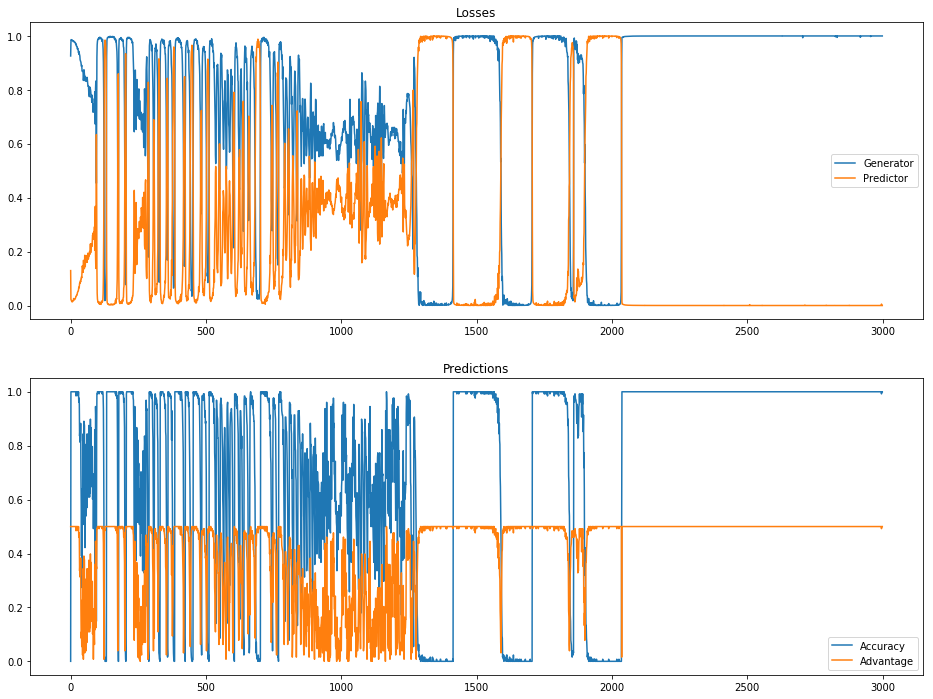

In [25]:
cprng_gan7.show_curves()

____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
sequence_input (InputLayer)                  (None, 112)                             0              
____________________________________________________________________________________________________
splitter (Lambda)                            [(None, 111), (None, 1)]                0              
____________________________________________________________________________________________________
dense_1 (Dense)                              (None, 30)                              3360           
____________________________________________________________________________________________________
leakyReLU_1 (LeakyReLU)                      (None, 30)                              0              
___________________________________________________________________________________________

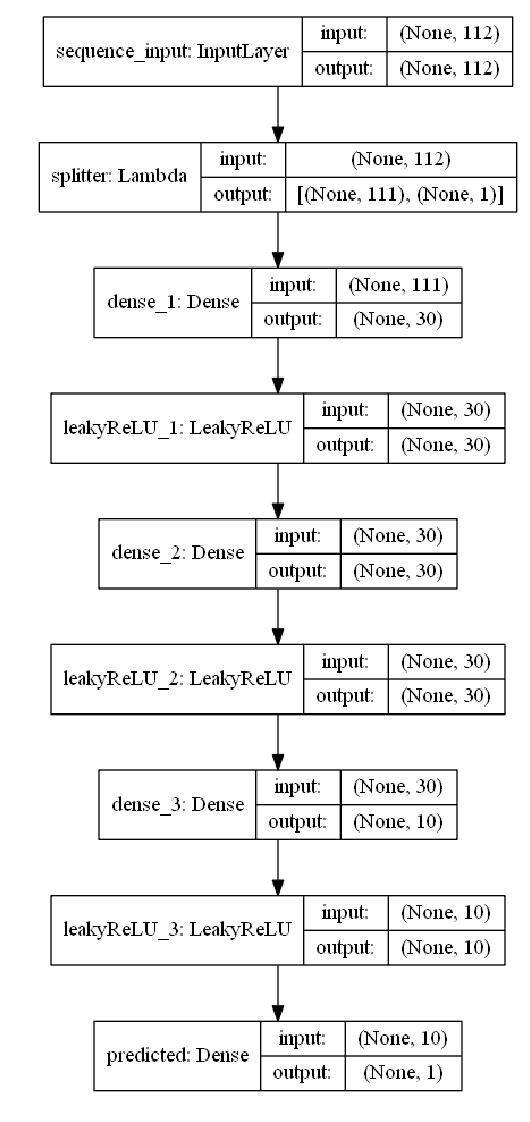

____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
g_dense_1 (Dense)                            (None, 30)                              990            
____________________________________________________________________________________________________
g_leakyReLU_1 (LeakyReLU)                    (None, 30)                              0              
____________________________________________________________________________________________________
g_dense_2 (Dense)                            (None, 30)                              930            
____________________________________________________________________________________________________
g_leakyReLU_2 (LeakyReLU)                    (None, 30)                              0              
___________________________________________________________________________________________

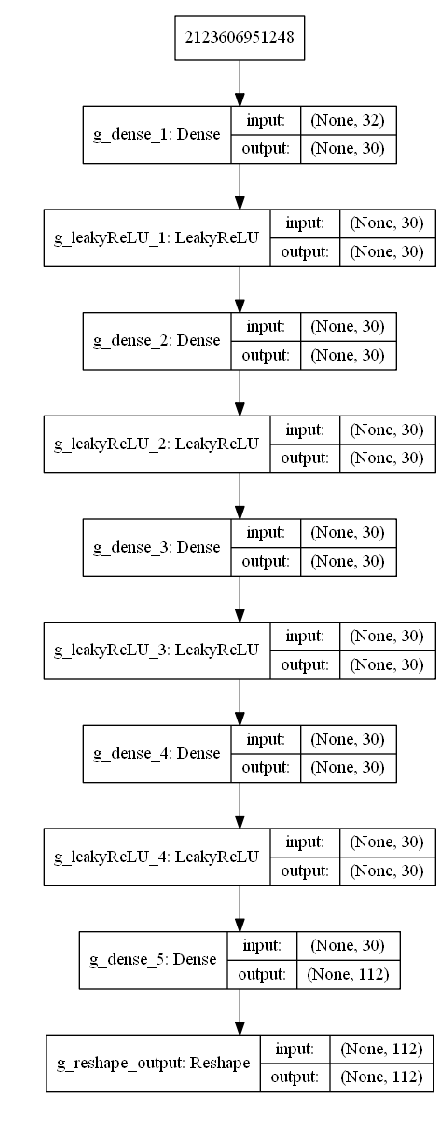

____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
latent_input (InputLayer)                    (None, 32)                              0              
____________________________________________________________________________________________________
generator (Model)                            (None, 112)                             7252           
____________________________________________________________________________________________________
predictor (Model)                            [(None, 1), (None, 1)]                  4611           
Total params: 11,863
Trainable params: 7,252
Non-trainable params: 4,611
____________________________________________________________________________________________________


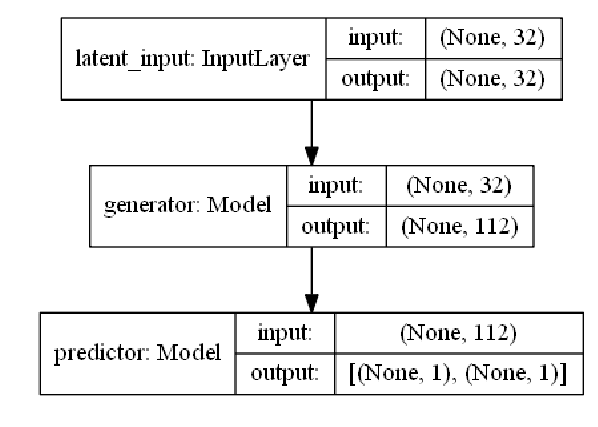

D:\Anaconda3\envs\keras\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [P loss: 0.009503, acc.: 21.88%] [G loss: 0.995436]
[0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 1 1 1 0 0 1 1 0 0 1 1 0 0 0 0 1
 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 1 1 0 1 1 0 0 1 1 1 0 0 1 1 0 0 1 0 1 0 1 1
 1 0 1 0 0 1 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0 1
 0]
[0 0 1 0 0 1 0 1 1 0 0 1 0 1 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1 0 1 0 1 0 1 0 0
 0 1 1 1 0 0 0 1 1 0 1 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 1 1 1 0 1 1
 1 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 1 1 1 1 1 0 0 1 1 0 1 0 0 1 0 1 1 1 1 1 1
 0]
[1 1 0 0 0 1 1 1 1 0 0 1 0 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 0 0 0 0 0 1
 0 0 1 1 0 1 0 1 1 0 0 1 0 1 0 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 0 1 1 1 0 1 0
 0 0 1 0 0 1 1 0 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 0 0 1 0 1 0 1 1 0 0 1 0
 0]
[1 0 0 0 0 1 1 1 0 0 0 1 0 1 0 1 0 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 0 1 0 0 1
 0 1 0 0 0 1 0 1 1 0 1 0 0 1 0 0 1 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 1 1 0 1 1
 1 0 1 0 0 1 0 0 1 0 0 0 1 0 1 0 0 1 1 1 0 0 1 1 1 1 1 1 0 1 0 0 0 0 1 1 0
 0]
[1 1 0 0 0 1 1 1 0 0 0 0 1 1 0

107 [P loss: 0.021341, acc.: 100.00%] [G loss: 0.979005]
108 [P loss: 0.020353, acc.: 100.00%] [G loss: 0.979807]
109 [P loss: 0.019655, acc.: 100.00%] [G loss: 0.980790]
110 [P loss: 0.019034, acc.: 100.00%] [G loss: 0.981246]
111 [P loss: 0.018039, acc.: 100.00%] [G loss: 0.981989]
112 [P loss: 0.017576, acc.: 100.00%] [G loss: 0.982718]
113 [P loss: 0.016793, acc.: 100.00%] [G loss: 0.983378]
114 [P loss: 0.016372, acc.: 100.00%] [G loss: 0.983889]
115 [P loss: 0.015715, acc.: 100.00%] [G loss: 0.984419]
116 [P loss: 0.015042, acc.: 100.00%] [G loss: 0.985082]
117 [P loss: 0.014753, acc.: 100.00%] [G loss: 0.985429]
118 [P loss: 0.014387, acc.: 100.00%] [G loss: 0.985792]
119 [P loss: 0.013903, acc.: 100.00%] [G loss: 0.986303]
120 [P loss: 0.013377, acc.: 100.00%] [G loss: 0.986744]
121 [P loss: 0.012930, acc.: 100.00%] [G loss: 0.987262]
122 [P loss: 0.012635, acc.: 100.00%] [G loss: 0.987498]
123 [P loss: 0.012180, acc.: 100.00%] [G loss: 0.987900]
124 [P loss: 0.011840, acc.: 10

211 [P loss: 0.002550, acc.: 100.00%] [G loss: 0.997476]
212 [P loss: 0.002506, acc.: 100.00%] [G loss: 0.997484]
213 [P loss: 0.002490, acc.: 100.00%] [G loss: 0.997514]
214 [P loss: 0.002449, acc.: 100.00%] [G loss: 0.997540]
215 [P loss: 0.002457, acc.: 100.00%] [G loss: 0.997573]
216 [P loss: 0.002392, acc.: 100.00%] [G loss: 0.997606]
217 [P loss: 0.002381, acc.: 100.00%] [G loss: 0.997629]
218 [P loss: 0.002344, acc.: 100.00%] [G loss: 0.997646]
219 [P loss: 0.002323, acc.: 100.00%] [G loss: 0.997682]
220 [P loss: 0.002301, acc.: 100.00%] [G loss: 0.997688]
221 [P loss: 0.002300, acc.: 100.00%] [G loss: 0.997741]
222 [P loss: 0.002250, acc.: 100.00%] [G loss: 0.997751]
223 [P loss: 0.002215, acc.: 100.00%] [G loss: 0.997793]
224 [P loss: 0.002213, acc.: 100.00%] [G loss: 0.997796]
225 [P loss: 0.002198, acc.: 100.00%] [G loss: 0.997835]
226 [P loss: 0.002147, acc.: 100.00%] [G loss: 0.997838]
227 [P loss: 0.002132, acc.: 100.00%] [G loss: 0.997877]
228 [P loss: 0.002118, acc.: 10

358 [P loss: 0.000785, acc.: 100.00%] [G loss: 0.999219]
359 [P loss: 0.000772, acc.: 100.00%] [G loss: 0.999214]
360 [P loss: 0.000776, acc.: 100.00%] [G loss: 0.999229]
361 [P loss: 0.000774, acc.: 100.00%] [G loss: 0.999236]
362 [P loss: 0.000761, acc.: 100.00%] [G loss: 0.999241]
363 [P loss: 0.000764, acc.: 100.00%] [G loss: 0.999241]
364 [P loss: 0.000751, acc.: 100.00%] [G loss: 0.999253]
365 [P loss: 0.000752, acc.: 100.00%] [G loss: 0.999254]
366 [P loss: 0.000746, acc.: 100.00%] [G loss: 0.999255]
367 [P loss: 0.000743, acc.: 100.00%] [G loss: 0.999257]
368 [P loss: 0.000737, acc.: 100.00%] [G loss: 0.999262]
369 [P loss: 0.000729, acc.: 100.00%] [G loss: 0.999267]
370 [P loss: 0.000731, acc.: 100.00%] [G loss: 0.999274]
371 [P loss: 0.000724, acc.: 100.00%] [G loss: 0.999270]
372 [P loss: 0.000723, acc.: 100.00%] [G loss: 0.999287]
373 [P loss: 0.000717, acc.: 100.00%] [G loss: 0.999286]
374 [P loss: 0.000712, acc.: 100.00%] [G loss: 0.999289]
375 [P loss: 0.000712, acc.: 10

466 [P loss: 0.000449, acc.: 100.00%] [G loss: 0.999549]
467 [P loss: 0.000448, acc.: 100.00%] [G loss: 0.999554]
468 [P loss: 0.000442, acc.: 100.00%] [G loss: 0.999555]
469 [P loss: 0.000437, acc.: 100.00%] [G loss: 0.999555]
470 [P loss: 0.000442, acc.: 100.00%] [G loss: 0.999558]
471 [P loss: 0.000438, acc.: 100.00%] [G loss: 0.999562]
472 [P loss: 0.000434, acc.: 100.00%] [G loss: 0.999564]
473 [P loss: 0.000437, acc.: 100.00%] [G loss: 0.999569]
474 [P loss: 0.000431, acc.: 100.00%] [G loss: 0.999568]
475 [P loss: 0.000425, acc.: 100.00%] [G loss: 0.999575]
476 [P loss: 0.000432, acc.: 100.00%] [G loss: 0.999574]
477 [P loss: 0.000427, acc.: 100.00%] [G loss: 0.999576]
478 [P loss: 0.000421, acc.: 100.00%] [G loss: 0.999578]
479 [P loss: 0.000425, acc.: 100.00%] [G loss: 0.999578]
480 [P loss: 0.000424, acc.: 100.00%] [G loss: 0.999580]
481 [P loss: 0.000420, acc.: 100.00%] [G loss: 0.999580]
482 [P loss: 0.000413, acc.: 100.00%] [G loss: 0.999585]
483 [P loss: 0.000414, acc.: 10

605 [P loss: 0.000256, acc.: 100.00%] [G loss: 0.999743]
606 [P loss: 0.000256, acc.: 100.00%] [G loss: 0.999745]
607 [P loss: 0.000255, acc.: 100.00%] [G loss: 0.999746]
608 [P loss: 0.000254, acc.: 100.00%] [G loss: 0.999746]
609 [P loss: 0.000253, acc.: 100.00%] [G loss: 0.999745]
610 [P loss: 0.000254, acc.: 100.00%] [G loss: 0.999748]
611 [P loss: 0.000251, acc.: 100.00%] [G loss: 0.999750]
612 [P loss: 0.000250, acc.: 100.00%] [G loss: 0.999750]
613 [P loss: 0.000250, acc.: 100.00%] [G loss: 0.999752]
614 [P loss: 0.000249, acc.: 100.00%] [G loss: 0.999751]
615 [P loss: 0.000247, acc.: 100.00%] [G loss: 0.999751]
616 [P loss: 0.000245, acc.: 100.00%] [G loss: 0.999754]
617 [P loss: 0.000247, acc.: 100.00%] [G loss: 0.999755]
618 [P loss: 0.000246, acc.: 100.00%] [G loss: 0.999755]
619 [P loss: 0.000243, acc.: 100.00%] [G loss: 0.999755]
620 [P loss: 0.000243, acc.: 100.00%] [G loss: 0.999756]
621 [P loss: 0.000244, acc.: 100.00%] [G loss: 0.999756]
622 [P loss: 0.000241, acc.: 10

751 [P loss: 0.000158, acc.: 100.00%] [G loss: 0.999840]
752 [P loss: 0.000157, acc.: 100.00%] [G loss: 0.999841]
753 [P loss: 0.000158, acc.: 100.00%] [G loss: 0.999842]
754 [P loss: 0.000157, acc.: 100.00%] [G loss: 0.999842]
755 [P loss: 0.000156, acc.: 100.00%] [G loss: 0.999844]
756 [P loss: 0.000158, acc.: 100.00%] [G loss: 0.999843]
757 [P loss: 0.000155, acc.: 100.00%] [G loss: 0.999845]
758 [P loss: 0.000155, acc.: 100.00%] [G loss: 0.999844]
759 [P loss: 0.000154, acc.: 100.00%] [G loss: 0.999845]
760 [P loss: 0.000155, acc.: 100.00%] [G loss: 0.999845]
761 [P loss: 0.000154, acc.: 100.00%] [G loss: 0.999846]
762 [P loss: 0.000154, acc.: 100.00%] [G loss: 0.999846]
763 [P loss: 0.000154, acc.: 100.00%] [G loss: 0.999847]
764 [P loss: 0.000153, acc.: 100.00%] [G loss: 0.999847]
765 [P loss: 0.000152, acc.: 100.00%] [G loss: 0.999847]
766 [P loss: 0.000152, acc.: 100.00%] [G loss: 0.999849]
767 [P loss: 0.000152, acc.: 100.00%] [G loss: 0.999848]
768 [P loss: 0.000151, acc.: 10

855 [P loss: 0.000117, acc.: 100.00%] [G loss: 0.999882]
856 [P loss: 0.000117, acc.: 100.00%] [G loss: 0.999883]
857 [P loss: 0.000117, acc.: 100.00%] [G loss: 0.999884]
858 [P loss: 0.000116, acc.: 100.00%] [G loss: 0.999884]
859 [P loss: 0.000116, acc.: 100.00%] [G loss: 0.999883]
860 [P loss: 0.000116, acc.: 100.00%] [G loss: 0.999884]
861 [P loss: 0.000115, acc.: 100.00%] [G loss: 0.999885]
862 [P loss: 0.000115, acc.: 100.00%] [G loss: 0.999885]
863 [P loss: 0.000114, acc.: 100.00%] [G loss: 0.999886]
864 [P loss: 0.000114, acc.: 100.00%] [G loss: 0.999886]
865 [P loss: 0.000115, acc.: 100.00%] [G loss: 0.999886]
866 [P loss: 0.000114, acc.: 100.00%] [G loss: 0.999886]
867 [P loss: 0.000114, acc.: 100.00%] [G loss: 0.999886]
868 [P loss: 0.000114, acc.: 100.00%] [G loss: 0.999887]
869 [P loss: 0.000114, acc.: 100.00%] [G loss: 0.999887]
870 [P loss: 0.000113, acc.: 100.00%] [G loss: 0.999888]
871 [P loss: 0.000111, acc.: 100.00%] [G loss: 0.999889]
872 [P loss: 0.000112, acc.: 10

1000 [P loss: 0.000080, acc.: 100.00%] [G loss: 0.999920]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]
[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 0 1 1 1 0 1 1
 1]
[0 1 0 1 0 1 1 1 0 1 0 1 1

1103 [P loss: 0.000062, acc.: 100.00%] [G loss: 0.999938]
1104 [P loss: 0.000062, acc.: 100.00%] [G loss: 0.999938]
1105 [P loss: 0.000062, acc.: 100.00%] [G loss: 0.999938]
1106 [P loss: 0.000061, acc.: 100.00%] [G loss: 0.999938]
1107 [P loss: 0.000062, acc.: 100.00%] [G loss: 0.999939]
1108 [P loss: 0.000061, acc.: 100.00%] [G loss: 0.999939]
1109 [P loss: 0.000061, acc.: 100.00%] [G loss: 0.999940]
1110 [P loss: 0.000061, acc.: 100.00%] [G loss: 0.999939]
1111 [P loss: 0.000061, acc.: 100.00%] [G loss: 0.999939]
1112 [P loss: 0.000060, acc.: 100.00%] [G loss: 0.999940]
1113 [P loss: 0.000060, acc.: 100.00%] [G loss: 0.999939]
1114 [P loss: 0.000060, acc.: 100.00%] [G loss: 0.999939]
1115 [P loss: 0.000060, acc.: 100.00%] [G loss: 0.999940]
1116 [P loss: 0.000060, acc.: 100.00%] [G loss: 0.999940]
1117 [P loss: 0.000060, acc.: 100.00%] [G loss: 0.999941]
1118 [P loss: 0.000059, acc.: 100.00%] [G loss: 0.999939]
1119 [P loss: 0.000060, acc.: 100.00%] [G loss: 0.999941]
1120 [P loss: 

1207 [P loss: 0.000049, acc.: 100.00%] [G loss: 0.999952]
1208 [P loss: 0.000048, acc.: 100.00%] [G loss: 0.999952]
1209 [P loss: 0.000049, acc.: 100.00%] [G loss: 0.999952]
1210 [P loss: 0.000048, acc.: 100.00%] [G loss: 0.999952]
1211 [P loss: 0.000048, acc.: 100.00%] [G loss: 0.999952]
1212 [P loss: 0.000048, acc.: 100.00%] [G loss: 0.999952]
1213 [P loss: 0.000048, acc.: 100.00%] [G loss: 0.999952]
1214 [P loss: 0.000048, acc.: 100.00%] [G loss: 0.999952]
1215 [P loss: 0.000048, acc.: 100.00%] [G loss: 0.999952]
1216 [P loss: 0.000047, acc.: 100.00%] [G loss: 0.999952]
1217 [P loss: 0.000047, acc.: 100.00%] [G loss: 0.999953]
1218 [P loss: 0.000047, acc.: 100.00%] [G loss: 0.999953]
1219 [P loss: 0.000047, acc.: 100.00%] [G loss: 0.999952]
1220 [P loss: 0.000047, acc.: 100.00%] [G loss: 0.999953]
1221 [P loss: 0.000047, acc.: 100.00%] [G loss: 0.999953]
1222 [P loss: 0.000047, acc.: 100.00%] [G loss: 0.999953]
1223 [P loss: 0.000047, acc.: 100.00%] [G loss: 0.999953]
1224 [P loss: 

1352 [P loss: 0.000035, acc.: 100.00%] [G loss: 0.999965]
1353 [P loss: 0.000035, acc.: 100.00%] [G loss: 0.999965]
1354 [P loss: 0.000035, acc.: 100.00%] [G loss: 0.999965]
1355 [P loss: 0.000035, acc.: 100.00%] [G loss: 0.999965]
1356 [P loss: 0.000035, acc.: 100.00%] [G loss: 0.999965]
1357 [P loss: 0.000034, acc.: 100.00%] [G loss: 0.999965]
1358 [P loss: 0.000034, acc.: 100.00%] [G loss: 0.999966]
1359 [P loss: 0.000035, acc.: 100.00%] [G loss: 0.999965]
1360 [P loss: 0.000035, acc.: 100.00%] [G loss: 0.999965]
1361 [P loss: 0.000034, acc.: 100.00%] [G loss: 0.999966]
1362 [P loss: 0.000035, acc.: 100.00%] [G loss: 0.999966]
1363 [P loss: 0.000034, acc.: 100.00%] [G loss: 0.999966]
1364 [P loss: 0.000034, acc.: 100.00%] [G loss: 0.999966]
1365 [P loss: 0.000034, acc.: 100.00%] [G loss: 0.999966]
1366 [P loss: 0.000034, acc.: 100.00%] [G loss: 0.999966]
1367 [P loss: 0.000034, acc.: 100.00%] [G loss: 0.999966]
1368 [P loss: 0.000034, acc.: 100.00%] [G loss: 0.999967]
1369 [P loss: 

1454 [P loss: 0.000029, acc.: 100.00%] [G loss: 0.999972]
1455 [P loss: 0.000028, acc.: 100.00%] [G loss: 0.999972]
1456 [P loss: 0.000028, acc.: 100.00%] [G loss: 0.999972]
1457 [P loss: 0.000028, acc.: 100.00%] [G loss: 0.999972]
1458 [P loss: 0.000028, acc.: 100.00%] [G loss: 0.999972]
1459 [P loss: 0.000028, acc.: 100.00%] [G loss: 0.999972]
1460 [P loss: 0.000028, acc.: 100.00%] [G loss: 0.999972]
1461 [P loss: 0.000028, acc.: 100.00%] [G loss: 0.999972]
1462 [P loss: 0.000028, acc.: 100.00%] [G loss: 0.999972]
1463 [P loss: 0.000028, acc.: 100.00%] [G loss: 0.999972]
1464 [P loss: 0.000028, acc.: 100.00%] [G loss: 0.999973]
1465 [P loss: 0.000028, acc.: 100.00%] [G loss: 0.999972]
1466 [P loss: 0.000028, acc.: 100.00%] [G loss: 0.999972]
1467 [P loss: 0.000028, acc.: 100.00%] [G loss: 0.999973]
1468 [P loss: 0.000028, acc.: 100.00%] [G loss: 0.999973]
1469 [P loss: 0.000027, acc.: 100.00%] [G loss: 0.999973]
1470 [P loss: 0.000027, acc.: 100.00%] [G loss: 0.999973]
1471 [P loss: 

1597 [P loss: 0.000021, acc.: 100.00%] [G loss: 0.999979]
1598 [P loss: 0.000021, acc.: 100.00%] [G loss: 0.999979]
1599 [P loss: 0.000021, acc.: 100.00%] [G loss: 0.999979]
1600 [P loss: 0.000021, acc.: 100.00%] [G loss: 0.999979]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0 1 1
 1]
[0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 1 1 0 1 1 0 0 1 0 0 0 1 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0
 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0
 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0

1704 [P loss: 0.000017, acc.: 100.00%] [G loss: 0.999983]
1705 [P loss: 0.000017, acc.: 100.00%] [G loss: 0.999983]
1706 [P loss: 0.000017, acc.: 100.00%] [G loss: 0.999983]
1707 [P loss: 0.000017, acc.: 100.00%] [G loss: 0.999983]
1708 [P loss: 0.000017, acc.: 100.00%] [G loss: 0.999983]
1709 [P loss: 0.000017, acc.: 100.00%] [G loss: 0.999983]
1710 [P loss: 0.000017, acc.: 100.00%] [G loss: 0.999983]
1711 [P loss: 0.000017, acc.: 100.00%] [G loss: 0.999983]
1712 [P loss: 0.000016, acc.: 100.00%] [G loss: 0.999983]
1713 [P loss: 0.000017, acc.: 100.00%] [G loss: 0.999983]
1714 [P loss: 0.000017, acc.: 100.00%] [G loss: 0.999983]
1715 [P loss: 0.000016, acc.: 100.00%] [G loss: 0.999983]
1716 [P loss: 0.000017, acc.: 100.00%] [G loss: 0.999984]
1717 [P loss: 0.000017, acc.: 100.00%] [G loss: 0.999984]
1718 [P loss: 0.000017, acc.: 100.00%] [G loss: 0.999984]
1719 [P loss: 0.000016, acc.: 100.00%] [G loss: 0.999984]
1720 [P loss: 0.000016, acc.: 100.00%] [G loss: 0.999984]
1721 [P loss: 

1806 [P loss: 0.000014, acc.: 100.00%] [G loss: 0.999986]
1807 [P loss: 0.000014, acc.: 100.00%] [G loss: 0.999986]
1808 [P loss: 0.000014, acc.: 100.00%] [G loss: 0.999986]
1809 [P loss: 0.000014, acc.: 100.00%] [G loss: 0.999986]
1810 [P loss: 0.000014, acc.: 100.00%] [G loss: 0.999986]
1811 [P loss: 0.000014, acc.: 100.00%] [G loss: 0.999986]
1812 [P loss: 0.000014, acc.: 100.00%] [G loss: 0.999986]
1813 [P loss: 0.000014, acc.: 100.00%] [G loss: 0.999987]
1814 [P loss: 0.000013, acc.: 100.00%] [G loss: 0.999986]
1815 [P loss: 0.000014, acc.: 100.00%] [G loss: 0.999986]
1816 [P loss: 0.000014, acc.: 100.00%] [G loss: 0.999986]
1817 [P loss: 0.000013, acc.: 100.00%] [G loss: 0.999987]
1818 [P loss: 0.000013, acc.: 100.00%] [G loss: 0.999987]
1819 [P loss: 0.000013, acc.: 100.00%] [G loss: 0.999986]
1820 [P loss: 0.000014, acc.: 100.00%] [G loss: 0.999987]
1821 [P loss: 0.000013, acc.: 100.00%] [G loss: 0.999986]
1822 [P loss: 0.000013, acc.: 100.00%] [G loss: 0.999987]
1823 [P loss: 

1949 [P loss: 0.000010, acc.: 100.00%] [G loss: 0.999990]
1950 [P loss: 0.000010, acc.: 100.00%] [G loss: 0.999990]
1951 [P loss: 0.000010, acc.: 100.00%] [G loss: 0.999990]
1952 [P loss: 0.000010, acc.: 100.00%] [G loss: 0.999990]
1953 [P loss: 0.000010, acc.: 100.00%] [G loss: 0.999990]
1954 [P loss: 0.000010, acc.: 100.00%] [G loss: 0.999990]
1955 [P loss: 0.000010, acc.: 100.00%] [G loss: 0.999990]
1956 [P loss: 0.000010, acc.: 100.00%] [G loss: 0.999990]
1957 [P loss: 0.000010, acc.: 100.00%] [G loss: 0.999990]
1958 [P loss: 0.000010, acc.: 100.00%] [G loss: 0.999990]
1959 [P loss: 0.000010, acc.: 100.00%] [G loss: 0.999990]
1960 [P loss: 0.000010, acc.: 100.00%] [G loss: 0.999990]
1961 [P loss: 0.000010, acc.: 100.00%] [G loss: 0.999990]
1962 [P loss: 0.000010, acc.: 100.00%] [G loss: 0.999990]
1963 [P loss: 0.000010, acc.: 100.00%] [G loss: 0.999990]
1964 [P loss: 0.000010, acc.: 100.00%] [G loss: 0.999990]
1965 [P loss: 0.000010, acc.: 100.00%] [G loss: 0.999990]
1966 [P loss: 

2054 [P loss: 0.000008, acc.: 100.00%] [G loss: 0.999991]
2055 [P loss: 0.000009, acc.: 100.00%] [G loss: 0.999991]
2056 [P loss: 0.000009, acc.: 100.00%] [G loss: 0.999991]
2057 [P loss: 0.000008, acc.: 100.00%] [G loss: 0.999992]
2058 [P loss: 0.000008, acc.: 100.00%] [G loss: 0.999992]
2059 [P loss: 0.000008, acc.: 100.00%] [G loss: 0.999992]
2060 [P loss: 0.000008, acc.: 100.00%] [G loss: 0.999992]
2061 [P loss: 0.000008, acc.: 100.00%] [G loss: 0.999992]
2062 [P loss: 0.000008, acc.: 100.00%] [G loss: 0.999992]
2063 [P loss: 0.000008, acc.: 100.00%] [G loss: 0.999992]
2064 [P loss: 0.000008, acc.: 100.00%] [G loss: 0.999992]
2065 [P loss: 0.000008, acc.: 100.00%] [G loss: 0.999992]
2066 [P loss: 0.000008, acc.: 100.00%] [G loss: 0.999992]
2067 [P loss: 0.000008, acc.: 100.00%] [G loss: 0.999992]
2068 [P loss: 0.000008, acc.: 100.00%] [G loss: 0.999992]
2069 [P loss: 0.000008, acc.: 100.00%] [G loss: 0.999992]
2070 [P loss: 0.000008, acc.: 100.00%] [G loss: 0.999992]
2071 [P loss: 

2200 [P loss: 0.000006, acc.: 100.00%] [G loss: 0.999994]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]
[1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1
 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1
 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0

2304 [P loss: 0.000005, acc.: 100.00%] [G loss: 0.999995]
2305 [P loss: 0.000005, acc.: 100.00%] [G loss: 0.999995]
2306 [P loss: 0.000005, acc.: 100.00%] [G loss: 0.999995]
2307 [P loss: 0.000005, acc.: 100.00%] [G loss: 0.999995]
2308 [P loss: 0.000005, acc.: 100.00%] [G loss: 0.999995]
2309 [P loss: 0.000005, acc.: 100.00%] [G loss: 0.999995]
2310 [P loss: 0.000005, acc.: 100.00%] [G loss: 0.999995]
2311 [P loss: 0.000005, acc.: 100.00%] [G loss: 0.999995]
2312 [P loss: 0.000005, acc.: 100.00%] [G loss: 0.999995]
2313 [P loss: 0.000005, acc.: 100.00%] [G loss: 0.999995]
2314 [P loss: 0.000005, acc.: 100.00%] [G loss: 0.999995]
2315 [P loss: 0.000005, acc.: 100.00%] [G loss: 0.999995]
2316 [P loss: 0.000005, acc.: 100.00%] [G loss: 0.999995]
2317 [P loss: 0.000005, acc.: 100.00%] [G loss: 0.999995]
2318 [P loss: 0.000005, acc.: 100.00%] [G loss: 0.999995]
2319 [P loss: 0.000005, acc.: 100.00%] [G loss: 0.999995]
2320 [P loss: 0.000005, acc.: 100.00%] [G loss: 0.999995]
2321 [P loss: 

2407 [P loss: 0.000004, acc.: 100.00%] [G loss: 0.999996]
2408 [P loss: 0.000004, acc.: 100.00%] [G loss: 0.999996]
2409 [P loss: 0.000004, acc.: 100.00%] [G loss: 0.999996]
2410 [P loss: 0.000004, acc.: 100.00%] [G loss: 0.999996]
2411 [P loss: 0.000004, acc.: 100.00%] [G loss: 0.999996]
2412 [P loss: 0.000004, acc.: 100.00%] [G loss: 0.999996]
2413 [P loss: 0.000004, acc.: 100.00%] [G loss: 0.999996]
2414 [P loss: 0.000004, acc.: 100.00%] [G loss: 0.999996]
2415 [P loss: 0.000004, acc.: 100.00%] [G loss: 0.999996]
2416 [P loss: 0.000004, acc.: 100.00%] [G loss: 0.999996]
2417 [P loss: 0.000004, acc.: 100.00%] [G loss: 0.999996]
2418 [P loss: 0.000004, acc.: 100.00%] [G loss: 0.999996]
2419 [P loss: 0.000004, acc.: 100.00%] [G loss: 0.999996]
2420 [P loss: 0.000004, acc.: 100.00%] [G loss: 0.999996]
2421 [P loss: 0.000004, acc.: 100.00%] [G loss: 0.999996]
2422 [P loss: 0.000004, acc.: 100.00%] [G loss: 0.999996]
2423 [P loss: 0.000004, acc.: 100.00%] [G loss: 0.999996]
2424 [P loss: 

2552 [P loss: 0.000003, acc.: 100.00%] [G loss: 0.999997]
2553 [P loss: 0.000003, acc.: 100.00%] [G loss: 0.999997]
2554 [P loss: 0.000003, acc.: 100.00%] [G loss: 0.999997]
2555 [P loss: 0.000003, acc.: 100.00%] [G loss: 0.999997]
2556 [P loss: 0.000003, acc.: 100.00%] [G loss: 0.999997]
2557 [P loss: 0.000003, acc.: 100.00%] [G loss: 0.999997]
2558 [P loss: 0.000003, acc.: 100.00%] [G loss: 0.999997]
2559 [P loss: 0.000003, acc.: 100.00%] [G loss: 0.999997]
2560 [P loss: 0.000003, acc.: 100.00%] [G loss: 0.999997]
2561 [P loss: 0.000003, acc.: 100.00%] [G loss: 0.999997]
2562 [P loss: 0.000003, acc.: 100.00%] [G loss: 0.999997]
2563 [P loss: 0.000003, acc.: 100.00%] [G loss: 0.999997]
2564 [P loss: 0.000003, acc.: 100.00%] [G loss: 0.999997]
2565 [P loss: 0.000003, acc.: 100.00%] [G loss: 0.999997]
2566 [P loss: 0.000003, acc.: 100.00%] [G loss: 0.999997]
2567 [P loss: 0.000003, acc.: 100.00%] [G loss: 0.999997]
2568 [P loss: 0.000003, acc.: 100.00%] [G loss: 0.999997]
2569 [P loss: 

2656 [P loss: 0.000003, acc.: 100.00%] [G loss: 0.999997]
2657 [P loss: 0.000003, acc.: 100.00%] [G loss: 0.999997]
2658 [P loss: 0.000003, acc.: 100.00%] [G loss: 0.999997]
2659 [P loss: 0.000003, acc.: 100.00%] [G loss: 0.999997]
2660 [P loss: 0.000003, acc.: 100.00%] [G loss: 0.999997]
2661 [P loss: 0.000003, acc.: 100.00%] [G loss: 0.999997]
2662 [P loss: 0.000003, acc.: 100.00%] [G loss: 0.999997]
2663 [P loss: 0.000003, acc.: 100.00%] [G loss: 0.999997]
2664 [P loss: 0.000003, acc.: 100.00%] [G loss: 0.999997]
2665 [P loss: 0.000003, acc.: 100.00%] [G loss: 0.999997]
2666 [P loss: 0.000003, acc.: 100.00%] [G loss: 0.999997]
2667 [P loss: 0.000003, acc.: 100.00%] [G loss: 0.999997]
2668 [P loss: 0.000003, acc.: 100.00%] [G loss: 0.999997]
2669 [P loss: 0.000003, acc.: 100.00%] [G loss: 0.999997]
2670 [P loss: 0.000003, acc.: 100.00%] [G loss: 0.999997]
2671 [P loss: 0.000003, acc.: 100.00%] [G loss: 0.999997]
2672 [P loss: 0.000003, acc.: 100.00%] [G loss: 0.999997]
2673 [P loss: 

2798 [P loss: 0.000002, acc.: 100.00%] [G loss: 0.999998]
2799 [P loss: 0.000002, acc.: 100.00%] [G loss: 0.999998]
2800 [P loss: 0.000002, acc.: 100.00%] [G loss: 0.999998]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

2902 [P loss: 0.000002, acc.: 100.00%] [G loss: 0.999998]
2903 [P loss: 0.000002, acc.: 100.00%] [G loss: 0.999998]
2904 [P loss: 0.000002, acc.: 100.00%] [G loss: 0.999998]
2905 [P loss: 0.000002, acc.: 100.00%] [G loss: 0.999998]
2906 [P loss: 0.000002, acc.: 100.00%] [G loss: 0.999998]
2907 [P loss: 0.000002, acc.: 100.00%] [G loss: 0.999998]
2908 [P loss: 0.000002, acc.: 100.00%] [G loss: 0.999998]
2909 [P loss: 0.000002, acc.: 100.00%] [G loss: 0.999998]
2910 [P loss: 0.000002, acc.: 100.00%] [G loss: 0.999998]
2911 [P loss: 0.000002, acc.: 100.00%] [G loss: 0.999998]
2912 [P loss: 0.000002, acc.: 100.00%] [G loss: 0.999998]
2913 [P loss: 0.000002, acc.: 100.00%] [G loss: 0.999998]
2914 [P loss: 0.000002, acc.: 100.00%] [G loss: 0.999998]
2915 [P loss: 0.000002, acc.: 100.00%] [G loss: 0.999998]
2916 [P loss: 0.000002, acc.: 100.00%] [G loss: 0.999998]
2917 [P loss: 0.000002, acc.: 100.00%] [G loss: 0.999998]
2918 [P loss: 0.000002, acc.: 100.00%] [G loss: 0.999998]
2919 [P loss: 

In [26]:
cprng_gan8 = CPRNG_GAN_wrong_loss(latent_dim=2 * 16, gen_width=7 * 16,
                     generator = [30, 30, 30, 30],
                     predictor = [30, 30, 10])
cprng_gan8.train(epochs=3000, batch_size=128, sample_interval=200, adv_multiplier = 3)

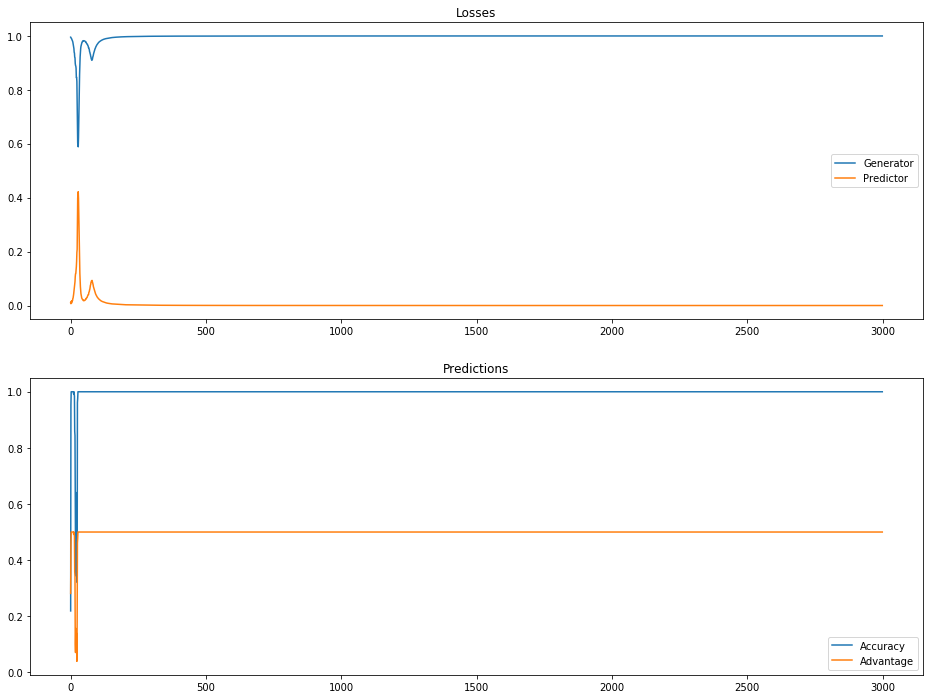

In [27]:
cprng_gan8.show_curves()